# Importing libraries and loading preprocessed data

In [1]:
import os
import re
import nltk
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score

# if you keras is not using tensorflow as backend set "KERAS_BACKEND=tensorflow" use this command
import tensorflow as tf
from tensorflow.keras import utils
import seaborn as sns
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import BatchNormalization, Conv1D, MaxPooling1D, MaxPooling2D, LSTM, Bidirectional
from tensorflow.keras.layers import Dense,Input,Activation, Embedding, Flatten, Conv2D, AveragePooling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Concatenate
import random as rn
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.initializers import glorot_uniform,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras import regularizers
from keras import backend
from itertools import combinations
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import datetime
%load_ext tensorboard

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\80316\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X_train, x_train_padding_pcomment, x_train_padding_comment, y_train = pickle.load(open("/content/drive/MyDrive/complete_preprocessed_train_data.pkl", 'rb'))
X_cv, x_cv_padding_pcomment, x_cv_padding_comment, y_cv = pickle.load(open("/content/drive/MyDrive/complete_preprocessed_cv_data.pkl", 'rb'))
# X_test, x_test_padding_pcomment, x_test_padding_comment, y_test = pickle.load(open("/content/drive/MyDrive/complete_preprocessed_test_data.pkl", 'rb'))
token_comment, token_pcomment =  pickle.load(open('/content/drive/MyDrive/tokens.pkl','rb'))

In [4]:
X_train.head()

author  subreddit     score       ups  downs  Neg_comment  \
468357  0.500437   0.515194  0.062949  0.089594      0        0.000   
241988  0.423178   0.500146  0.064312  0.091534      0        1.000   
789926  0.501311   0.464881  0.062949  0.089594      0        0.000   
259946  0.375328   0.540274  0.062949  0.089594      0        0.615   
230188  0.500437   0.486263  0.062949  0.089594      0        0.000   

        Neu_comment  Pos_comment  Compound_comment  Neg_pcomment  \
468357        0.794        0.206          0.538627         0.000   
241988        0.000        0.000          0.340917         0.412   
789926        1.000        0.000          0.500025         0.000   
259946        0.385        0.000          0.253063         0.079   
230188        1.000        0.000          0.500025         0.000   

        Neu_pcomment  Pos_pcomment  Compound_pcomment  comment_len  \
468357         1.000         0.000           0.500050     0.002501   
241988         0.588         0.000           0.363436     0.000500   
789926         1.000         0.000           0.500050     0.000000   
259946         0.504         0.417           0.906391     0.001001   
230188         1.000         0.000           0.500050     0.000500   

        pcomment_len  
468357      0.001665  
241988      0.000999  
789926      0.003663  
259946      0.006660  
230188      0.000333

In [5]:
print(X_train.shape)
print(X_cv.shape)
# print(X_test.shape)
print(x_train_padding_pcomment.shape)
print(x_train_padding_comment.shape)
print(y_train.shape)

(604320, 15)
(201440, 15)
(604320, 500)
(604320, 50)
(604320,)


In [6]:
x_train_num = X_train.values
x_cv_num = X_cv.values

# Glove vector embedding

In [ ]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
embedding_index={}
with open('/content/drive/MyDrive/glove.42B.300d.txt') as f:
  for line in f:
    value=line.split()
    word=value[0]
    vector=np.asarray(value[1:],dtype='float32')
    embedding_index[word]=vector

In [ ]:
embedding_matrix_comment_glove = np.zeros(((len(token_comment.word_index)+1), 300))
for word, i in token_comment.word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix_comment_glove[i] = embedding_vector

embedding_matrix_pcomment_glove = np.zeros(((len(token_pcomment.word_index)+1), 300))
for word, i in token_pcomment.word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix_pcomment_glove[i] = embedding_vector

In [ ]:
print(embedding_matrix_comment_glove.shape)
print(embedding_matrix_pcomment_glove.shape)

(126194, 300)
(175433, 300)


In [ ]:
print(len(token_comment.word_index))
print(len(token_pcomment.word_index))

126193
175432


# Fast text embedding

In [ ]:
embedding_index={}
with open('/content/drive/MyDrive/crawl-300d-2M.vec') as f:
  for line in f:
    value=line.split()
    word=value[0]
    vector=np.asarray(value[1:],dtype='float32')
    embedding_index[word]=vector

In [ ]:
embedding_matrix_comment_fast = np.zeros(((len(token_comment.word_index)+1), 300))
for word, i in token_comment.word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix_comment_fast[i] = embedding_vector

embedding_matrix_pcomment_fast = np.zeros(((len(token_pcomment.word_index)+1), 300))
for word, i in token_pcomment.word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix_pcomment_fast[i] = embedding_vector

In [ ]:
print(embedding_matrix_comment_fast.shape)
print(embedding_matrix_pcomment_fast.shape)

(126194, 300)
(175433, 300)


In [ ]:
print(len(token_comment.word_index))
print(len(token_pcomment.word_index))

126193
175432


In [ ]:
pickle.dump((embedding_matrix_comment_fast, embedding_matrix_pcomment_fast),open('/content/drive/MyDrive/embedding_matrix_fast.pkl','wb'))

In [4]:
embedding_matrix_comment_fast, embedding_matrix_pcomment_fast =  pickle.load(open('/content/drive/MyDrive/embedding_matrix_fast.pkl','rb'))

# 1. CNN 1 layer and 4 Dense layers

## 1.1 Using glove vector

### 1.1.1 trainable = False

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_glove],input_length=50,trainable=False, name='Emb_layer_comment')(input_layer_comment)
first_cov_comment = Conv1D(128, 4, activation='relu',padding="same", kernel_initializer=glorot_uniform(seed=42), name='1st_conv_comment')(embedding_layer_comment)
first_max_comment = MaxPooling1D(pool_size= 4,)(first_cov_comment)

flat_layer_comment = Flatten(name='Flat_layer_comment')(first_max_comment)

input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_glove],input_length=500,trainable=False, name='Emb_layer_pcomment')(input_layer_pcomment)
first_cov_pcomment = Conv1D(128, 4, activation='relu',padding="same", kernel_initializer=glorot_uniform(seed=42), name='1st_conv_pcomment')(embedding_layer_pcomment)
first_max_pcomment = MaxPooling1D(pool_size= 4,)(first_cov_pcomment)

flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(first_max_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(512, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer')(input_layer_num)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1')(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2')(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3')(batch_norm_2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

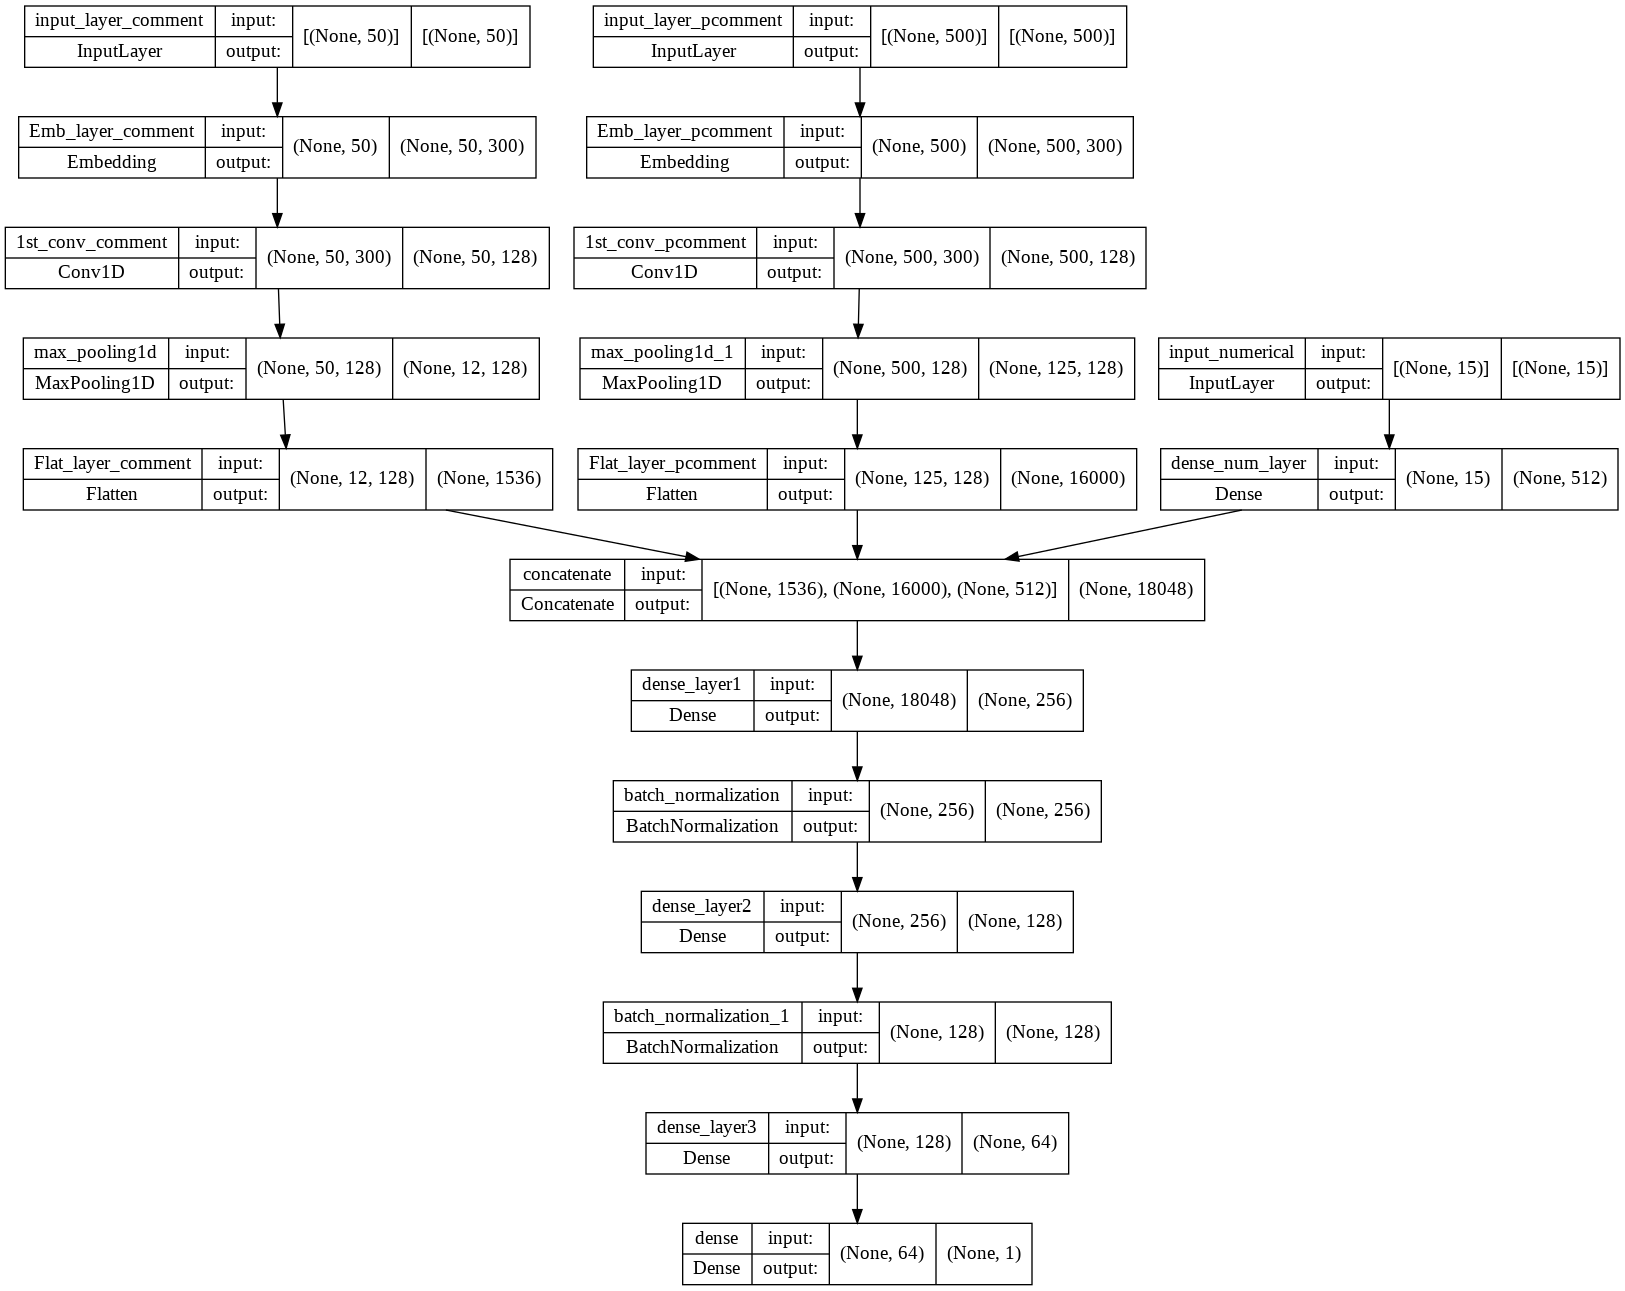

In [ ]:
path = '/content/drive/MyDrive/model1.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 148s 56ms/step - loss: 0.5879 - accuracy: 0.6808 - val_loss: 0.7045 - val_accuracy: 0.6064 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 128s 54ms/step - loss: 0.5413 - accuracy: 0.7203 - val_loss: 0.7008 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 133s 57ms/step - loss: 0.5123 - accuracy: 0.7419 - val_loss: 0.7003 - val_accuracy: 0.6324 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 134s 57ms/step - loss: 0.4834 - accuracy: 0.7621 - val_loss: 0.7049 - val_accuracy: 0.6373 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - 133s 56ms/step - loss: 0.4529 - accuracy: 0.7819 - val_loss: 0.7478 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 6/50
2361/2361 [==============================] - ETA: 0s - loss: 0.4228 - accuracy: 0.8004
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
2361/2

### 1.1.2 trainable = True

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_glove],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
first_cov_comment = Conv1D(128, 4, activation='relu',padding="same", kernel_initializer=glorot_uniform(seed=42), name='1st_conv_comment')(embedding_layer_comment)
first_max_comment = MaxPooling1D(pool_size= 4,)(first_cov_comment)

flat_layer_comment = Flatten(name='Flat_layer_comment')(first_max_comment)

input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_glove],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
first_cov_pcomment = Conv1D(128, 4, activation='relu',padding="same", kernel_initializer=glorot_uniform(seed=42), name='1st_conv_pcomment')(embedding_layer_pcomment)
first_max_pcomment = MaxPooling1D(pool_size= 4,)(first_cov_pcomment)

flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(first_max_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(512, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer')(input_layer_num)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1')(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2')(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3')(batch_norm_2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

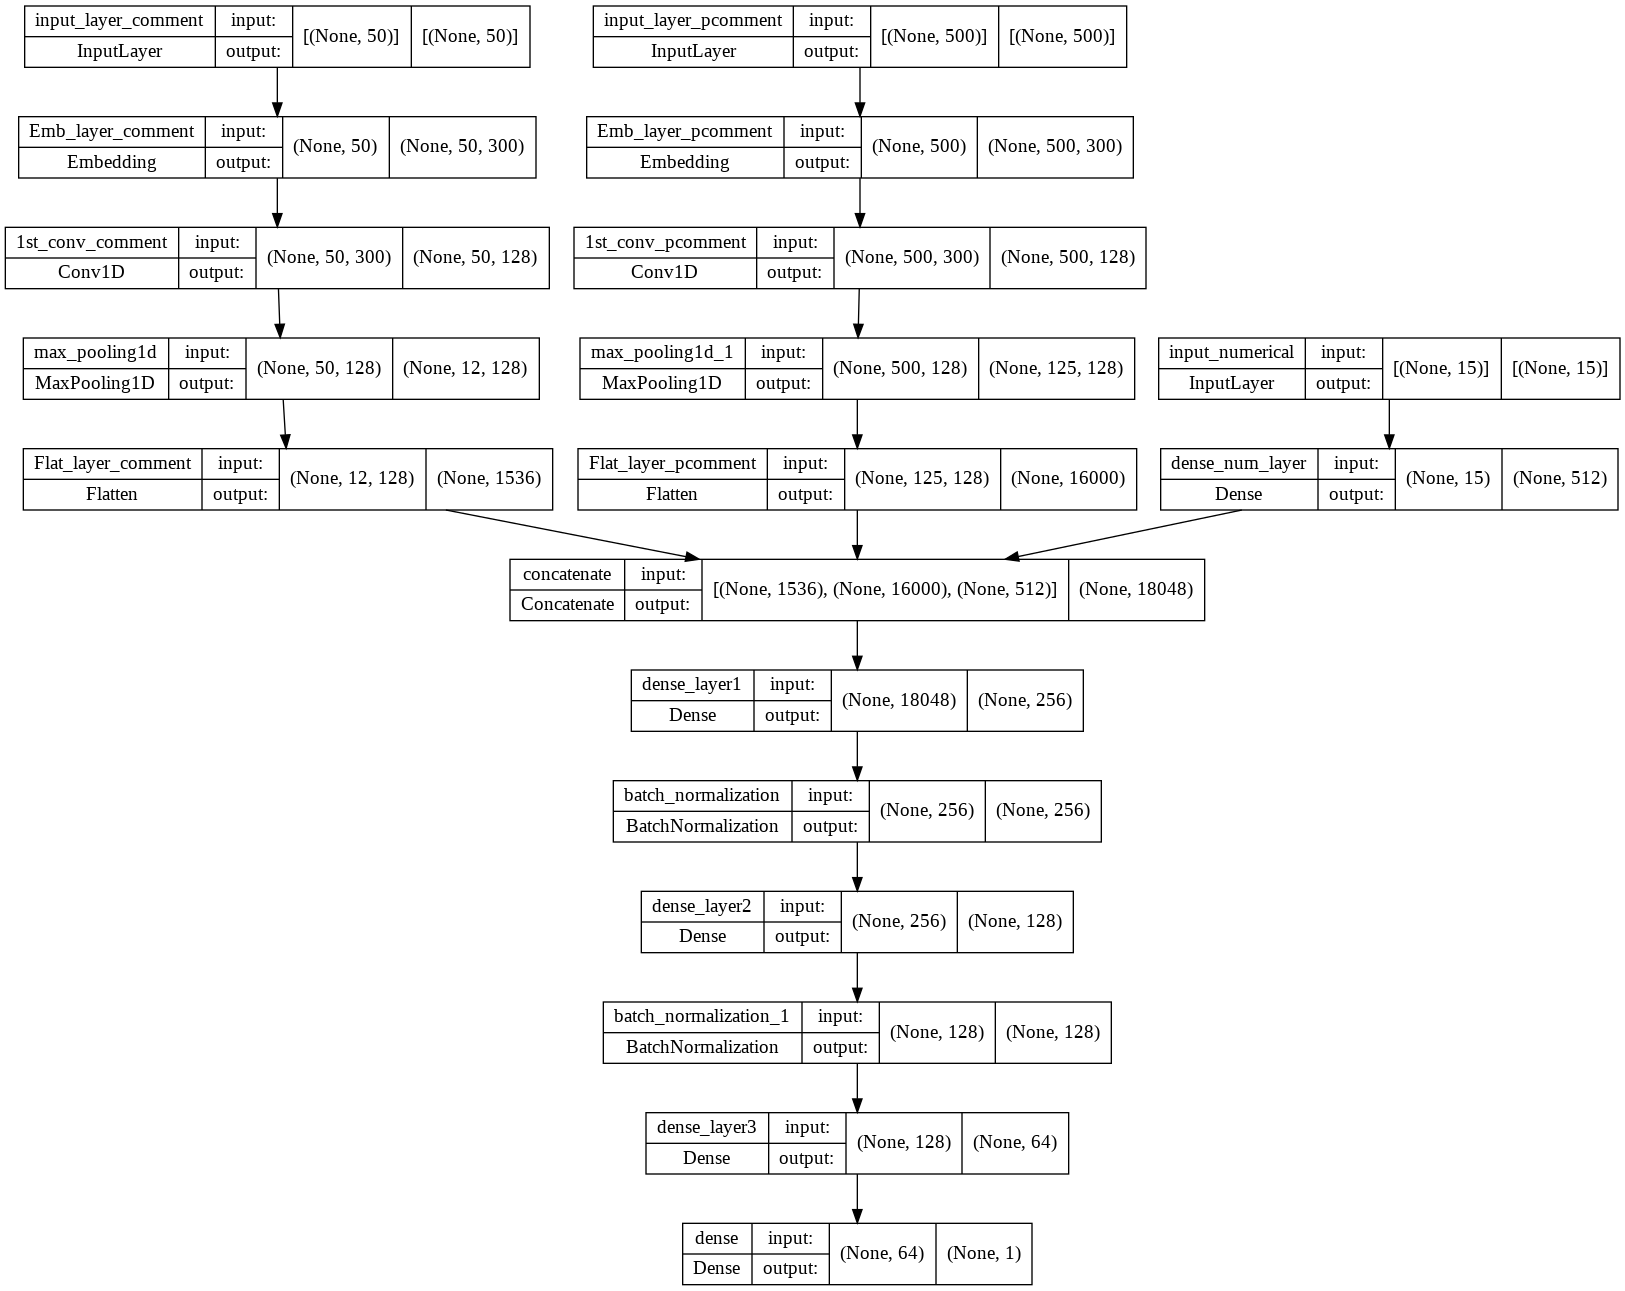

In [ ]:
path = '/content/drive/MyDrive/model2.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 294s 119ms/step - loss: 0.5752 - accuracy: 0.6915 - val_loss: 0.6850 - val_accuracy: 0.6233 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 274s 116ms/step - loss: 0.5169 - accuracy: 0.7400 - val_loss: 0.6821 - val_accuracy: 0.6449 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 274s 116ms/step - loss: 0.4705 - accuracy: 0.7731 - val_loss: 0.7046 - val_accuracy: 0.6499 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 279s 118ms/step - loss: 0.4078 - accuracy: 0.8127 - val_loss: 0.7742 - val_accuracy: 0.6447 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.8533
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
2361/2361 [==============================] - 279s 118ms/step - loss: 0.3352 - accuracy: 0.8533 - val_loss: 0.8641 - val_accuracy: 0.6366 - lr: 1.0000e-04
Epoch 6/50
2

## 1.2 Using fast text embedding

### 1.2.1 trainable = false

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=False, name='Emb_layer_comment')(input_layer_comment)
first_cov_comment = Conv1D(128, 4, activation='relu',padding="same", kernel_initializer=glorot_uniform(seed=42), name='1st_conv_comment')(embedding_layer_comment)
first_max_comment = MaxPooling1D(pool_size= 4,)(first_cov_comment)

flat_layer_comment = Flatten(name='Flat_layer_comment')(first_max_comment)

input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=False, name='Emb_layer_pcomment')(input_layer_pcomment)
first_cov_pcomment = Conv1D(128, 4, activation='relu',padding="same", kernel_initializer=glorot_uniform(seed=42), name='1st_conv_pcomment')(embedding_layer_pcomment)
first_max_pcomment = MaxPooling1D(pool_size= 4,)(first_cov_pcomment)

flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(first_max_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(512, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer')(input_layer_num)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1')(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2')(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3')(batch_norm_2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

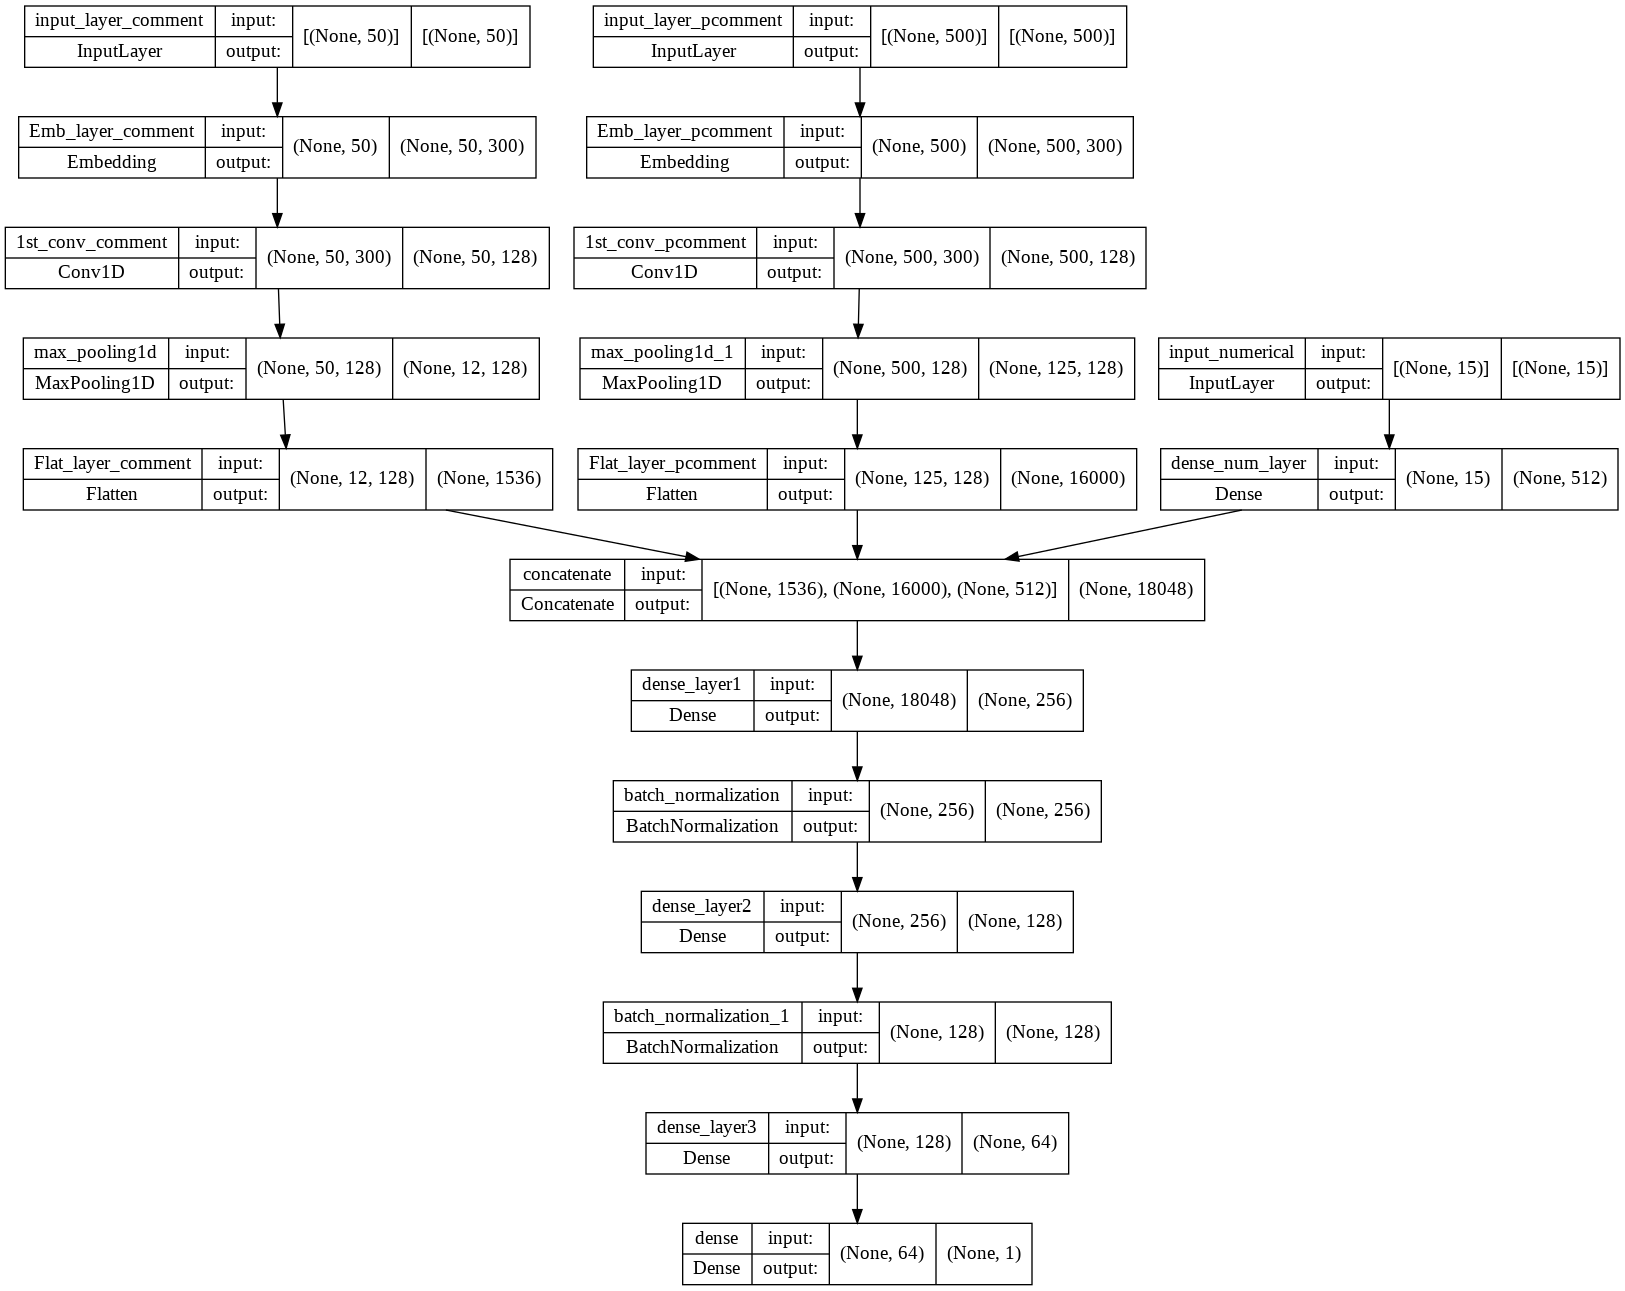

In [ ]:
path = '/content/drive/MyDrive/model2.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 144s 55ms/step - loss: 0.5815 - accuracy: 0.6869 - val_loss: 0.6999 - val_accuracy: 0.6181 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 131s 56ms/step - loss: 0.5342 - accuracy: 0.7256 - val_loss: 0.7041 - val_accuracy: 0.6316 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 130s 55ms/step - loss: 0.5044 - accuracy: 0.7474 - val_loss: 0.7028 - val_accuracy: 0.6405 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 136s 58ms/step - loss: 0.4742 - accuracy: 0.7683 - val_loss: 0.7194 - val_accuracy: 0.6381 - lr: 1.0000e-04
Epoch 5/50
2360/2361 [============================>.] - ETA: 0s - loss: 0.4420 - accuracy: 0.7885
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
2361/2361 [==============================] - 136s 57ms/step - loss: 0.4420 - accuracy: 0.7885 - val_loss: 0.7691 - val_accuracy: 0.6359 - lr: 1.0000e-04
Epoch 6/50
2361/2

### 1.2.2 Trainable = True

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
first_cov_comment = Conv1D(128, 4, activation='relu',padding="same", kernel_initializer=glorot_uniform(seed=42), name='1st_conv_comment')(embedding_layer_comment)
first_max_comment = MaxPooling1D(pool_size= 4,)(first_cov_comment)

flat_layer_comment = Flatten(name='Flat_layer_comment')(first_max_comment)

input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
first_cov_pcomment = Conv1D(128, 4, activation='relu',padding="same", kernel_initializer=glorot_uniform(seed=42), name='1st_conv_pcomment')(embedding_layer_pcomment)
first_max_pcomment = MaxPooling1D(pool_size= 4,)(first_cov_pcomment)

flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(first_max_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(512, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer')(input_layer_num)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1')(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2')(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3')(batch_norm_2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 2,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

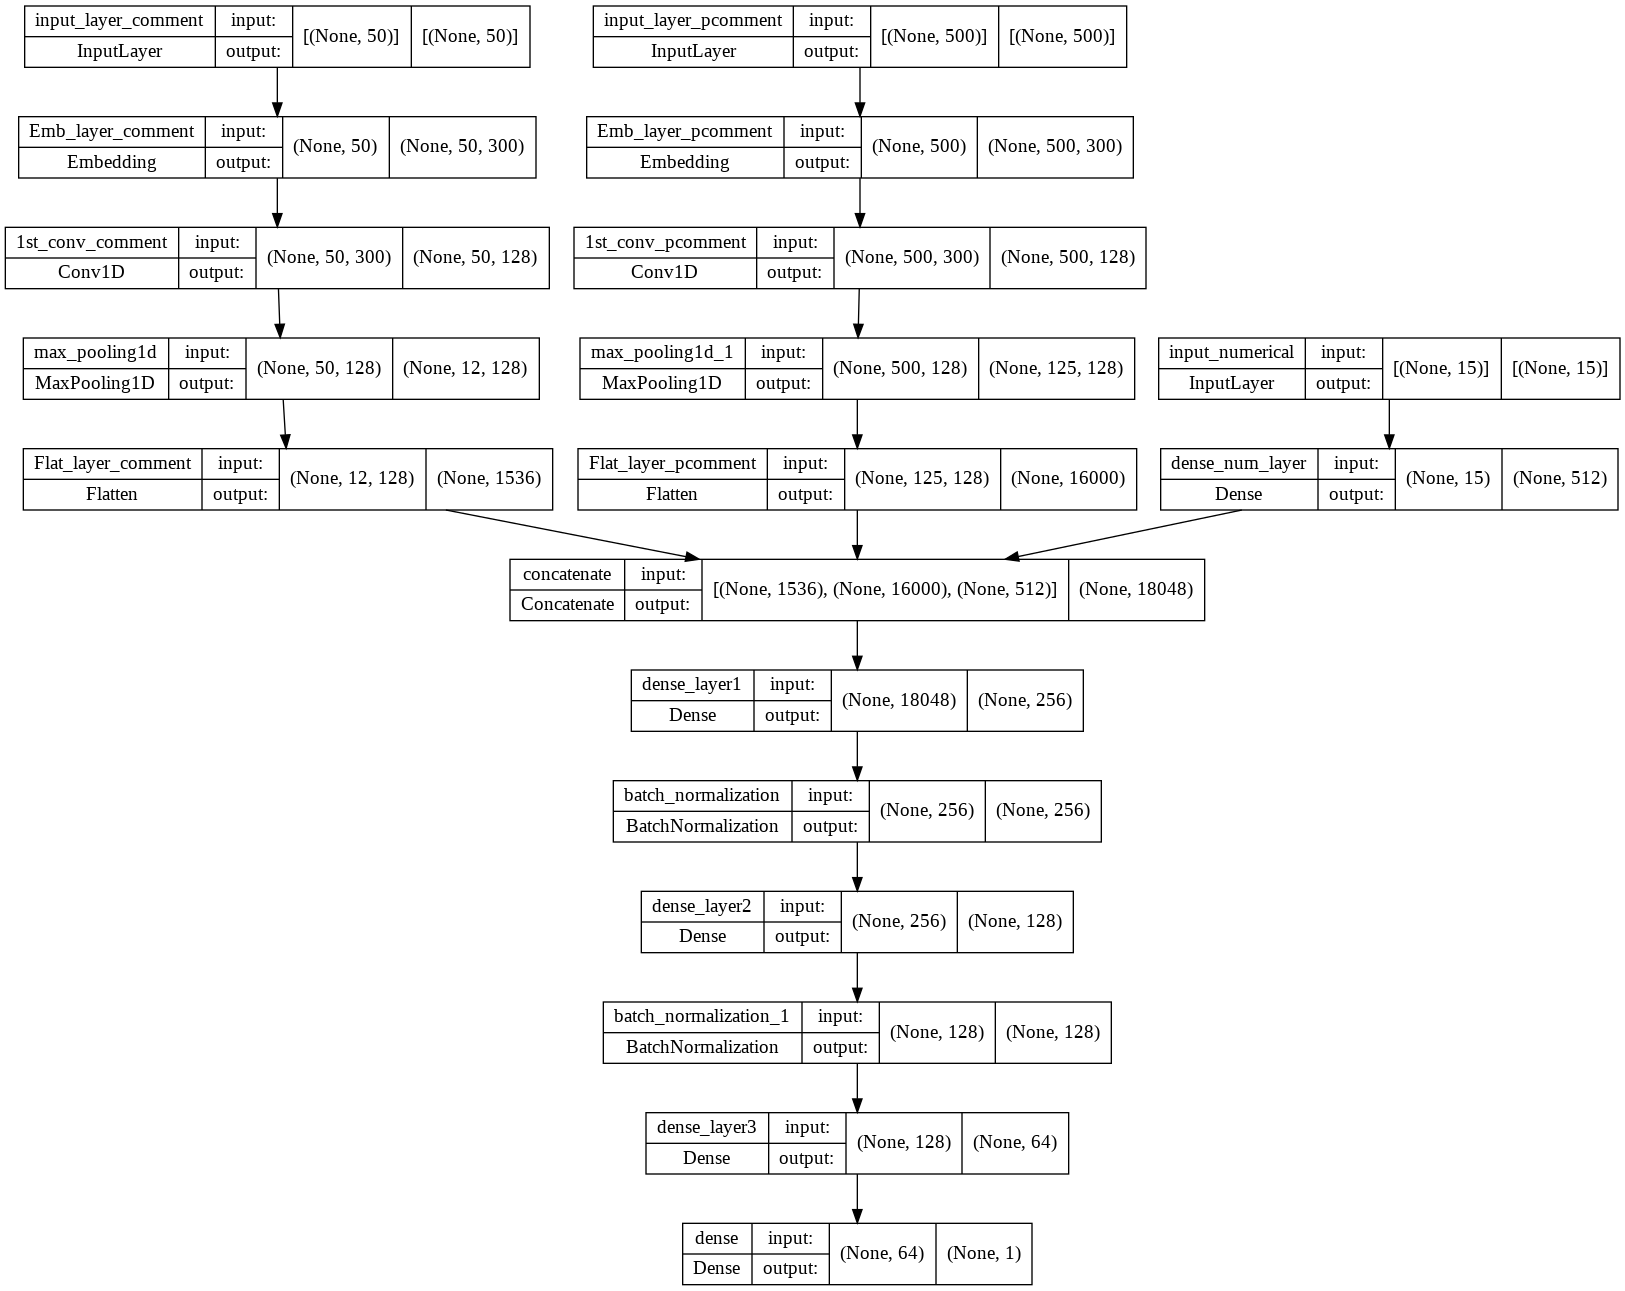

In [ ]:
path = 'model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 295s 120ms/step - loss: 0.5712 - accuracy: 0.6952 - val_loss: 0.7098 - val_accuracy: 0.6165 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 278s 118ms/step - loss: 0.5071 - accuracy: 0.7471 - val_loss: 0.6872 - val_accuracy: 0.6465 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 283s 120ms/step - loss: 0.4499 - accuracy: 0.7860 - val_loss: 0.7137 - val_accuracy: 0.6515 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8352
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
2361/2361 [==============================] - 278s 118ms/step - loss: 0.3670 - accuracy: 0.8352 - val_loss: 0.8143 - val_accuracy: 0.6472 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.8988
Epoch 5: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
2361

# 2. LSTM 1 layer and 5 Dense layers

## 2.1 Using Glove vector

### 2.1.1 trainable = False

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_glove],input_length=50,trainable=False, name='Emb_layer_comment')(input_layer_comment)
lstm_layer_comment = LSTM(100, dropout= 0.25, return_sequences=True, name= 'lstm_layer_comment')(embedding_layer_comment)

flat_layer_comment = Flatten(name='Flat_layer_comment')(lstm_layer_comment)

input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_glove],input_length=500,trainable=False, name='Emb_layer_pcomment')(input_layer_pcomment)
lstm_layer_pcomment = LSTM(100, dropout= 0.25, return_sequences=True, name= 'lstm_layer_pcomment')(embedding_layer_pcomment)

flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(lstm_layer_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(64, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.0001))(input_layer_num)
dense_num_layer = Dense(32, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.0001))(dense_num_layer)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(batch_norm_2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

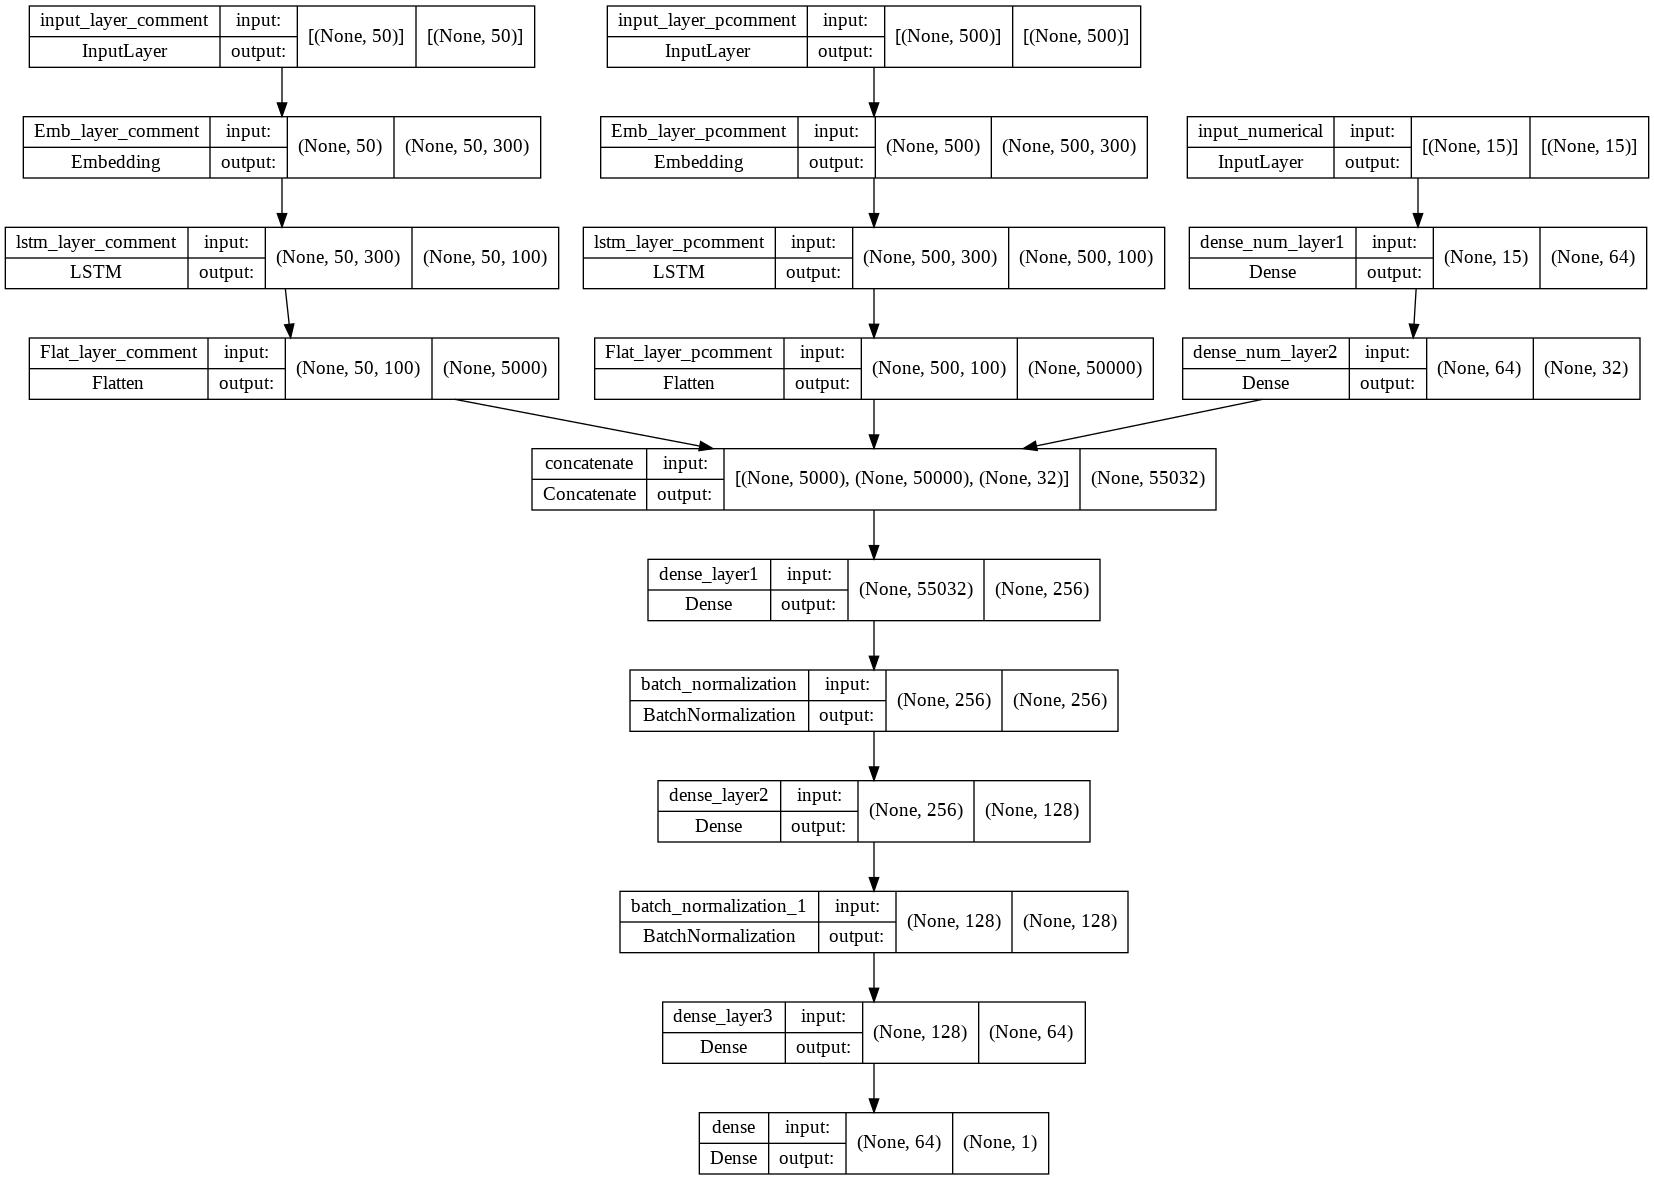

In [ ]:
path = '/content/drive/MyDrive/model3.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 257s 105ms/step - loss: 0.9680 - accuracy: 0.6732 - val_loss: 0.9472 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 264s 112ms/step - loss: 0.7343 - accuracy: 0.7038 - val_loss: 0.8215 - val_accuracy: 0.6172 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 267s 113ms/step - loss: 0.6584 - accuracy: 0.7149 - val_loss: 0.7813 - val_accuracy: 0.6326 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 263s 111ms/step - loss: 0.6194 - accuracy: 0.7231 - val_loss: 0.7595 - val_accuracy: 0.6385 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - 266s 113ms/step - loss: 0.5967 - accuracy: 0.7286 - val_loss: 0.7522 - val_accuracy: 0.6406 - lr: 1.0000e-04
Epoch 6/50
2361/2361 [==============================] - 249s 106ms/step - loss: 0.5808 - accuracy: 0.7341 - val_loss: 0.7298 - val_accuracy: 0.6473 - lr: 1.0000e-04
Epoch 7/50

### 2.1.2 trainable = True

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_glove],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
lstm_layer_comment = LSTM(100, dropout= 0.25, return_sequences=True, name= 'lstm_layer_comment')(embedding_layer_comment)

flat_layer_comment = Flatten(name='Flat_layer_comment')(lstm_layer_comment)

input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_glove],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
lstm_layer_pcomment = LSTM(100, dropout= 0.25, return_sequences=True, name= 'lstm_layer_pcomment')(embedding_layer_pcomment)

flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(lstm_layer_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(64, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.0001))(input_layer_num)
dense_num_layer = Dense(32, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.0001))(dense_num_layer)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(batch_norm_2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

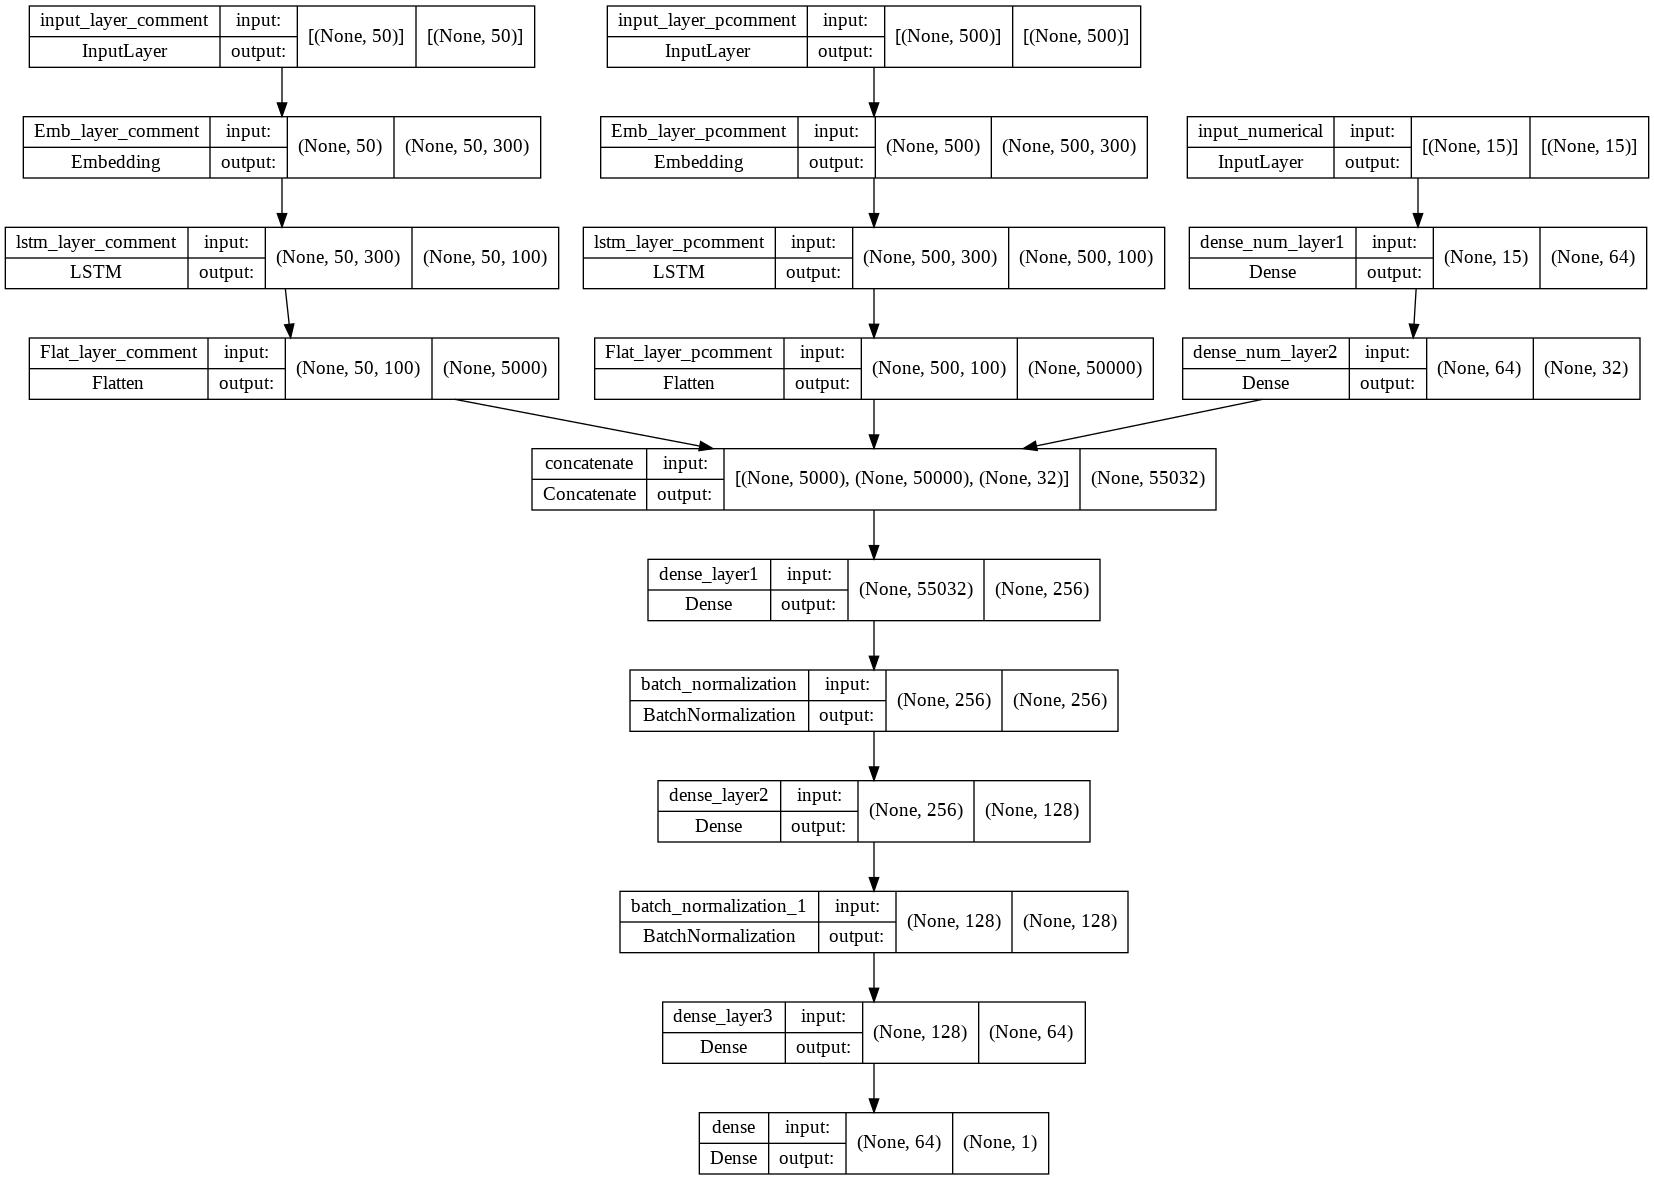

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 374s 154ms/step - loss: 0.9751 - accuracy: 0.6843 - val_loss: 0.9204 - val_accuracy: 0.6239 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 377s 160ms/step - loss: 0.7197 - accuracy: 0.7235 - val_loss: 0.8186 - val_accuracy: 0.6343 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 365s 155ms/step - loss: 0.6321 - accuracy: 0.7383 - val_loss: 0.7616 - val_accuracy: 0.6585 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 377s 160ms/step - loss: 0.5834 - accuracy: 0.7494 - val_loss: 0.7282 - val_accuracy: 0.6587 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - 377s 159ms/step - loss: 0.5510 - accuracy: 0.7610 - val_loss: 0.7310 - val_accuracy: 0.6610 - lr: 1.0000e-04
Epoch 6/50
2361/2361 [==============================] - 376s 159ms/step - loss: 0.5263 - accuracy: 0.7713 - val_loss: 0.7281 - val_accuracy: 0.6620 - lr: 1.0000e-04
Epoch 7/50

## 2.2 Using Fasttext

### 2.2.1 Trainable = False

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=False, name='Emb_layer_comment')(input_layer_comment)
lstm_layer_comment = LSTM(100, dropout= 0.25, return_sequences=True, name= 'lstm_layer_comment')(embedding_layer_comment)

flat_layer_comment = Flatten(name='Flat_layer_comment')(lstm_layer_comment)

input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=False, name='Emb_layer_pcomment')(input_layer_pcomment)
lstm_layer_pcomment = LSTM(100, dropout= 0.25, return_sequences=True, name= 'lstm_layer_pcomment')(embedding_layer_pcomment)

flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(lstm_layer_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(64, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.0001))(input_layer_num)
dense_num_layer = Dense(32, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.0001))(dense_num_layer)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(batch_norm_2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 2,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

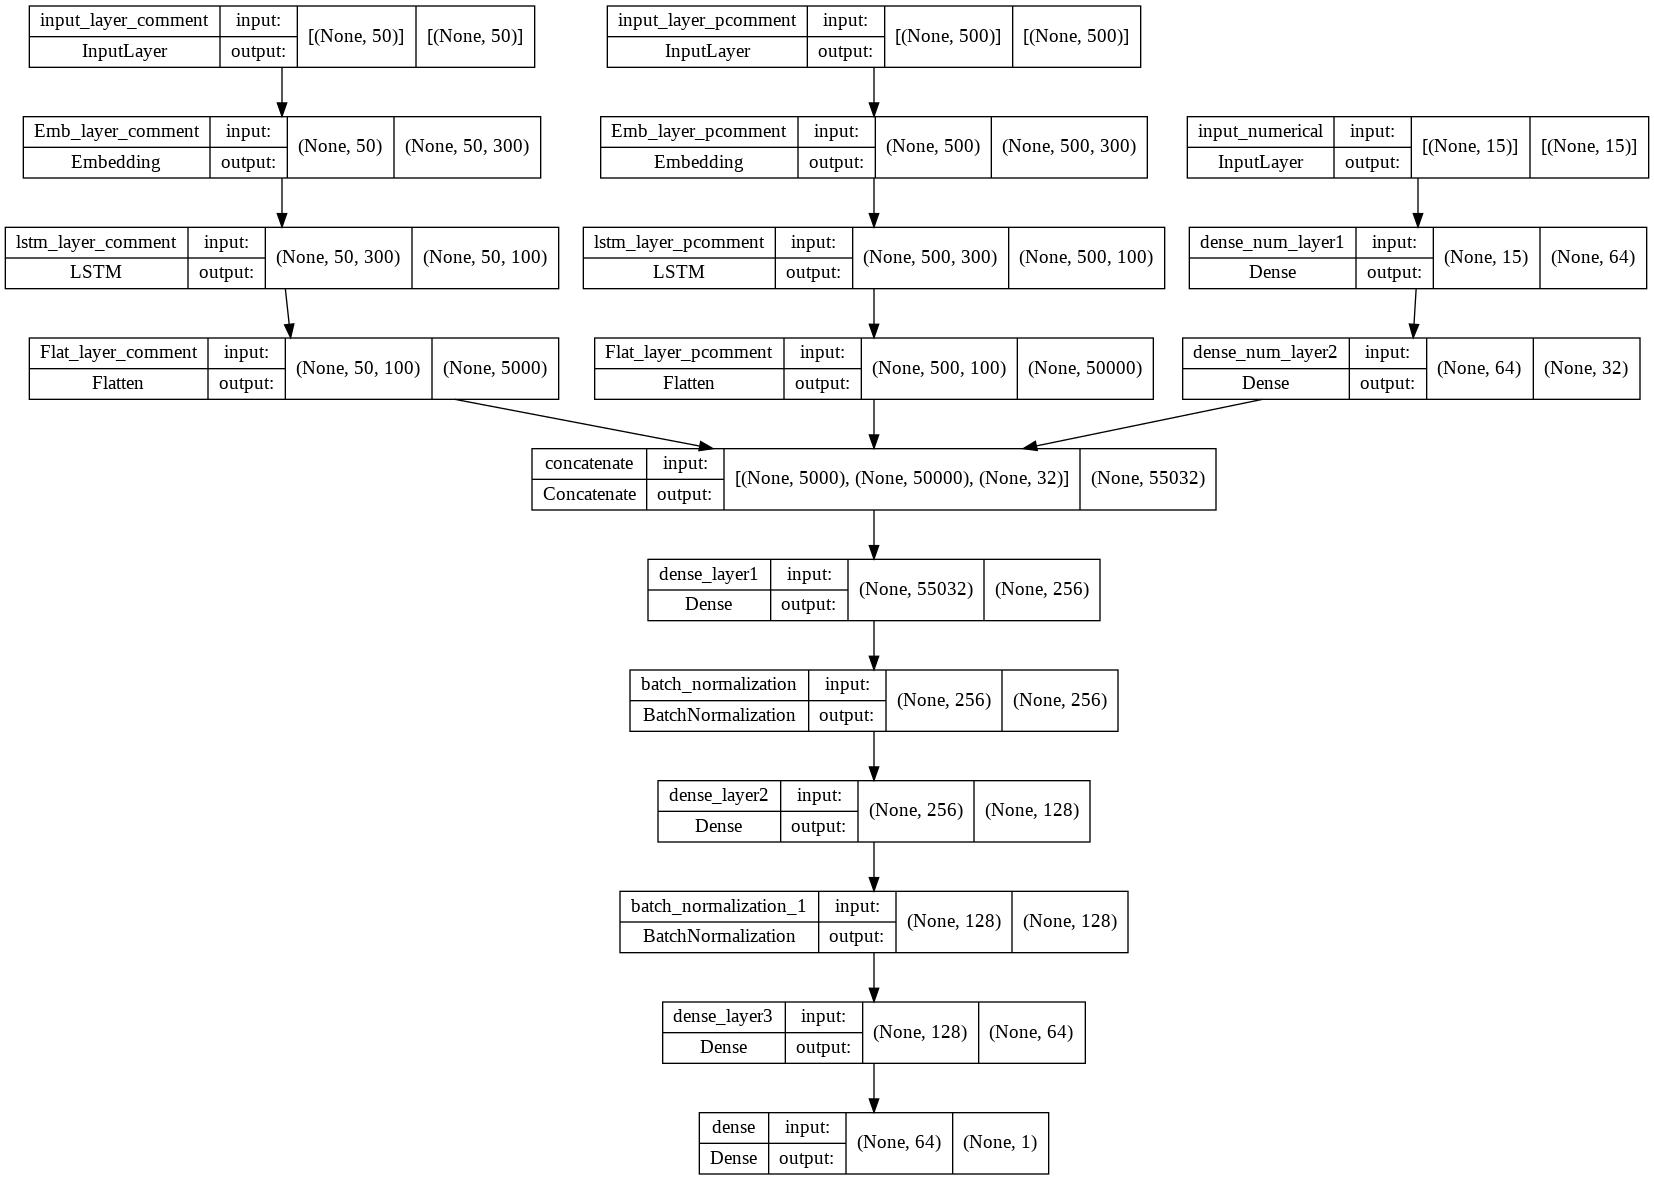

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 261s 107ms/step - loss: 1.0021 - accuracy: 0.6766 - val_loss: 0.9291 - val_accuracy: 0.6118 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 256s 108ms/step - loss: 0.7436 - accuracy: 0.7067 - val_loss: 0.8223 - val_accuracy: 0.6248 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 243s 103ms/step - loss: 0.6645 - accuracy: 0.7185 - val_loss: 0.7791 - val_accuracy: 0.6293 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 257s 109ms/step - loss: 0.6230 - accuracy: 0.7270 - val_loss: 0.7609 - val_accuracy: 0.6399 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - 257s 109ms/step - loss: 0.5975 - accuracy: 0.7339 - val_loss: 0.7538 - val_accuracy: 0.6440 - lr: 1.0000e-04
Epoch 6/50
2361/2361 [==============================] - 242s 103ms/step - loss: 0.5799 - accuracy: 0.7381 - val_loss: 0.7380 - val_accuracy: 0.6491 - lr: 1.0000e-04
Epoch 7/50

### 2.2.2 trainable = true

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
lstm_layer_comment = LSTM(100, dropout= 0.25, return_sequences=True, name= 'lstm_layer_comment')(embedding_layer_comment)

flat_layer_comment = Flatten(name='Flat_layer_comment')(lstm_layer_comment)

input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
lstm_layer_pcomment = LSTM(100, dropout= 0.25, return_sequences=True, name= 'lstm_layer_pcomment')(embedding_layer_pcomment)

flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(lstm_layer_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(64, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.0001))(input_layer_num)
dense_num_layer = Dense(32, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.0001))(dense_num_layer)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(batch_norm_2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 2,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

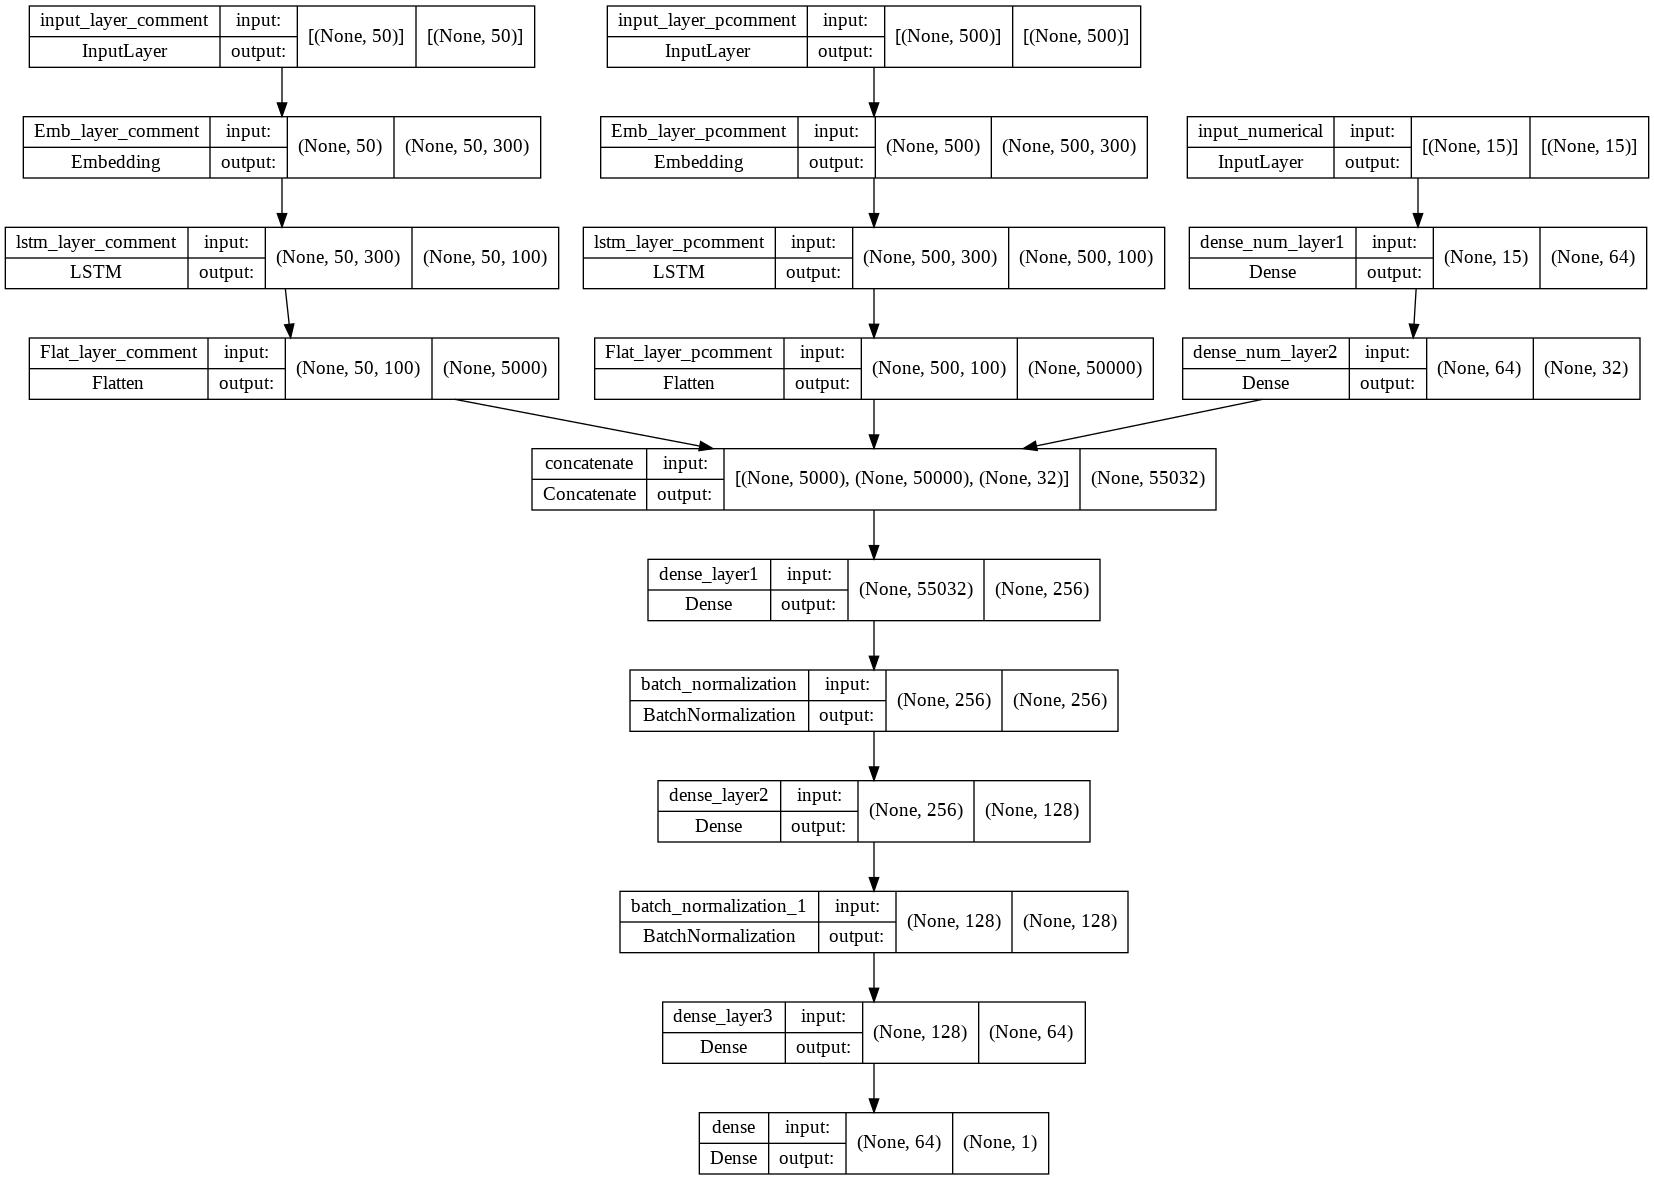

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 366s 151ms/step - loss: 1.0072 - accuracy: 0.6913 - val_loss: 0.9314 - val_accuracy: 0.6239 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 377s 160ms/step - loss: 0.7192 - accuracy: 0.7303 - val_loss: 0.8130 - val_accuracy: 0.6356 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 364s 154ms/step - loss: 0.6300 - accuracy: 0.7466 - val_loss: 0.7679 - val_accuracy: 0.6494 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 378s 160ms/step - loss: 0.5810 - accuracy: 0.7592 - val_loss: 0.7582 - val_accuracy: 0.6544 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - 378s 160ms/step - loss: 0.5458 - accuracy: 0.7718 - val_loss: 0.7356 - val_accuracy: 0.6641 - lr: 1.0000e-04
Epoch 6/50
2361/2361 [==============================] - 365s 154ms/step - loss: 0.5188 - accuracy: 0.7839 - val_loss: 0.7479 - val_accuracy: 0.6683 - lr: 1.0000e-04
Epoch 7/50

# As observed, fast text embedding when trainable = true works better than other methods. So, I stick to fast text embedding when trainable = true and try different architechtures.

# 3. LSTM 1 layer and 8 dense layers

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
lstm_layer_comment = LSTM(100, dropout= 0.25, return_sequences=True, name= 'lstm_layer_comment')(embedding_layer_comment)

flat_layer_comment = Flatten(name='Flat_layer_comment')(lstm_layer_comment)

input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
lstm_layer_pcomment = LSTM(100, dropout= 0.25, return_sequences=True, name= 'lstm_layer_pcomment')(embedding_layer_pcomment)

flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(lstm_layer_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer1 = Dense(512, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.0001))(input_layer_num)
batch_num_1 = BatchNormalization()(dense_num_layer1)
drop_num1 = Dropout(0.4)(batch_num_1)
dense_num_layer2 = Dense(256, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.0001))(drop_num1)
batch_num_2 = BatchNormalization()(dense_num_layer2)
drop_num2 = Dropout(0.4)(batch_num_2)
dense_num_layer3 = Dense(128, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer3', kernel_regularizer=l2(0.0001))(drop_num2)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer3])

dense_layer1 = Dense(2048, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.6)(batch_norm_1)
dense_layer2 = Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.4)(batch_norm_2)
dense_layer3 = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(drop_layer2)
batch_norm_3 = BatchNormalization()(dense_layer3)
drop_layer3 = Dropout(0.3)(batch_norm_3)
dense_layer4 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer4', kernel_regularizer=l2(0.001))(drop_layer3)
batch_norm_4 = BatchNormalization()(dense_layer4)
drop_layer4 = Dropout(0.2)(batch_norm_4)
dense_layer5 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer5', kernel_regularizer=l2(0.001))(drop_layer4)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 2,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_numerical (InputLayer)   [(None, 15)]         0           []                               
                                                                                                  
 dense_num_layer1 (Dense)       (None, 512)          8192        ['input_numerical[0][0]']        
                                                                                                  
 batch_normalization (BatchNorm  (None, 512)         2048        ['dense_num_layer1[0][0]']       
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['batch_normalization[0][0]']

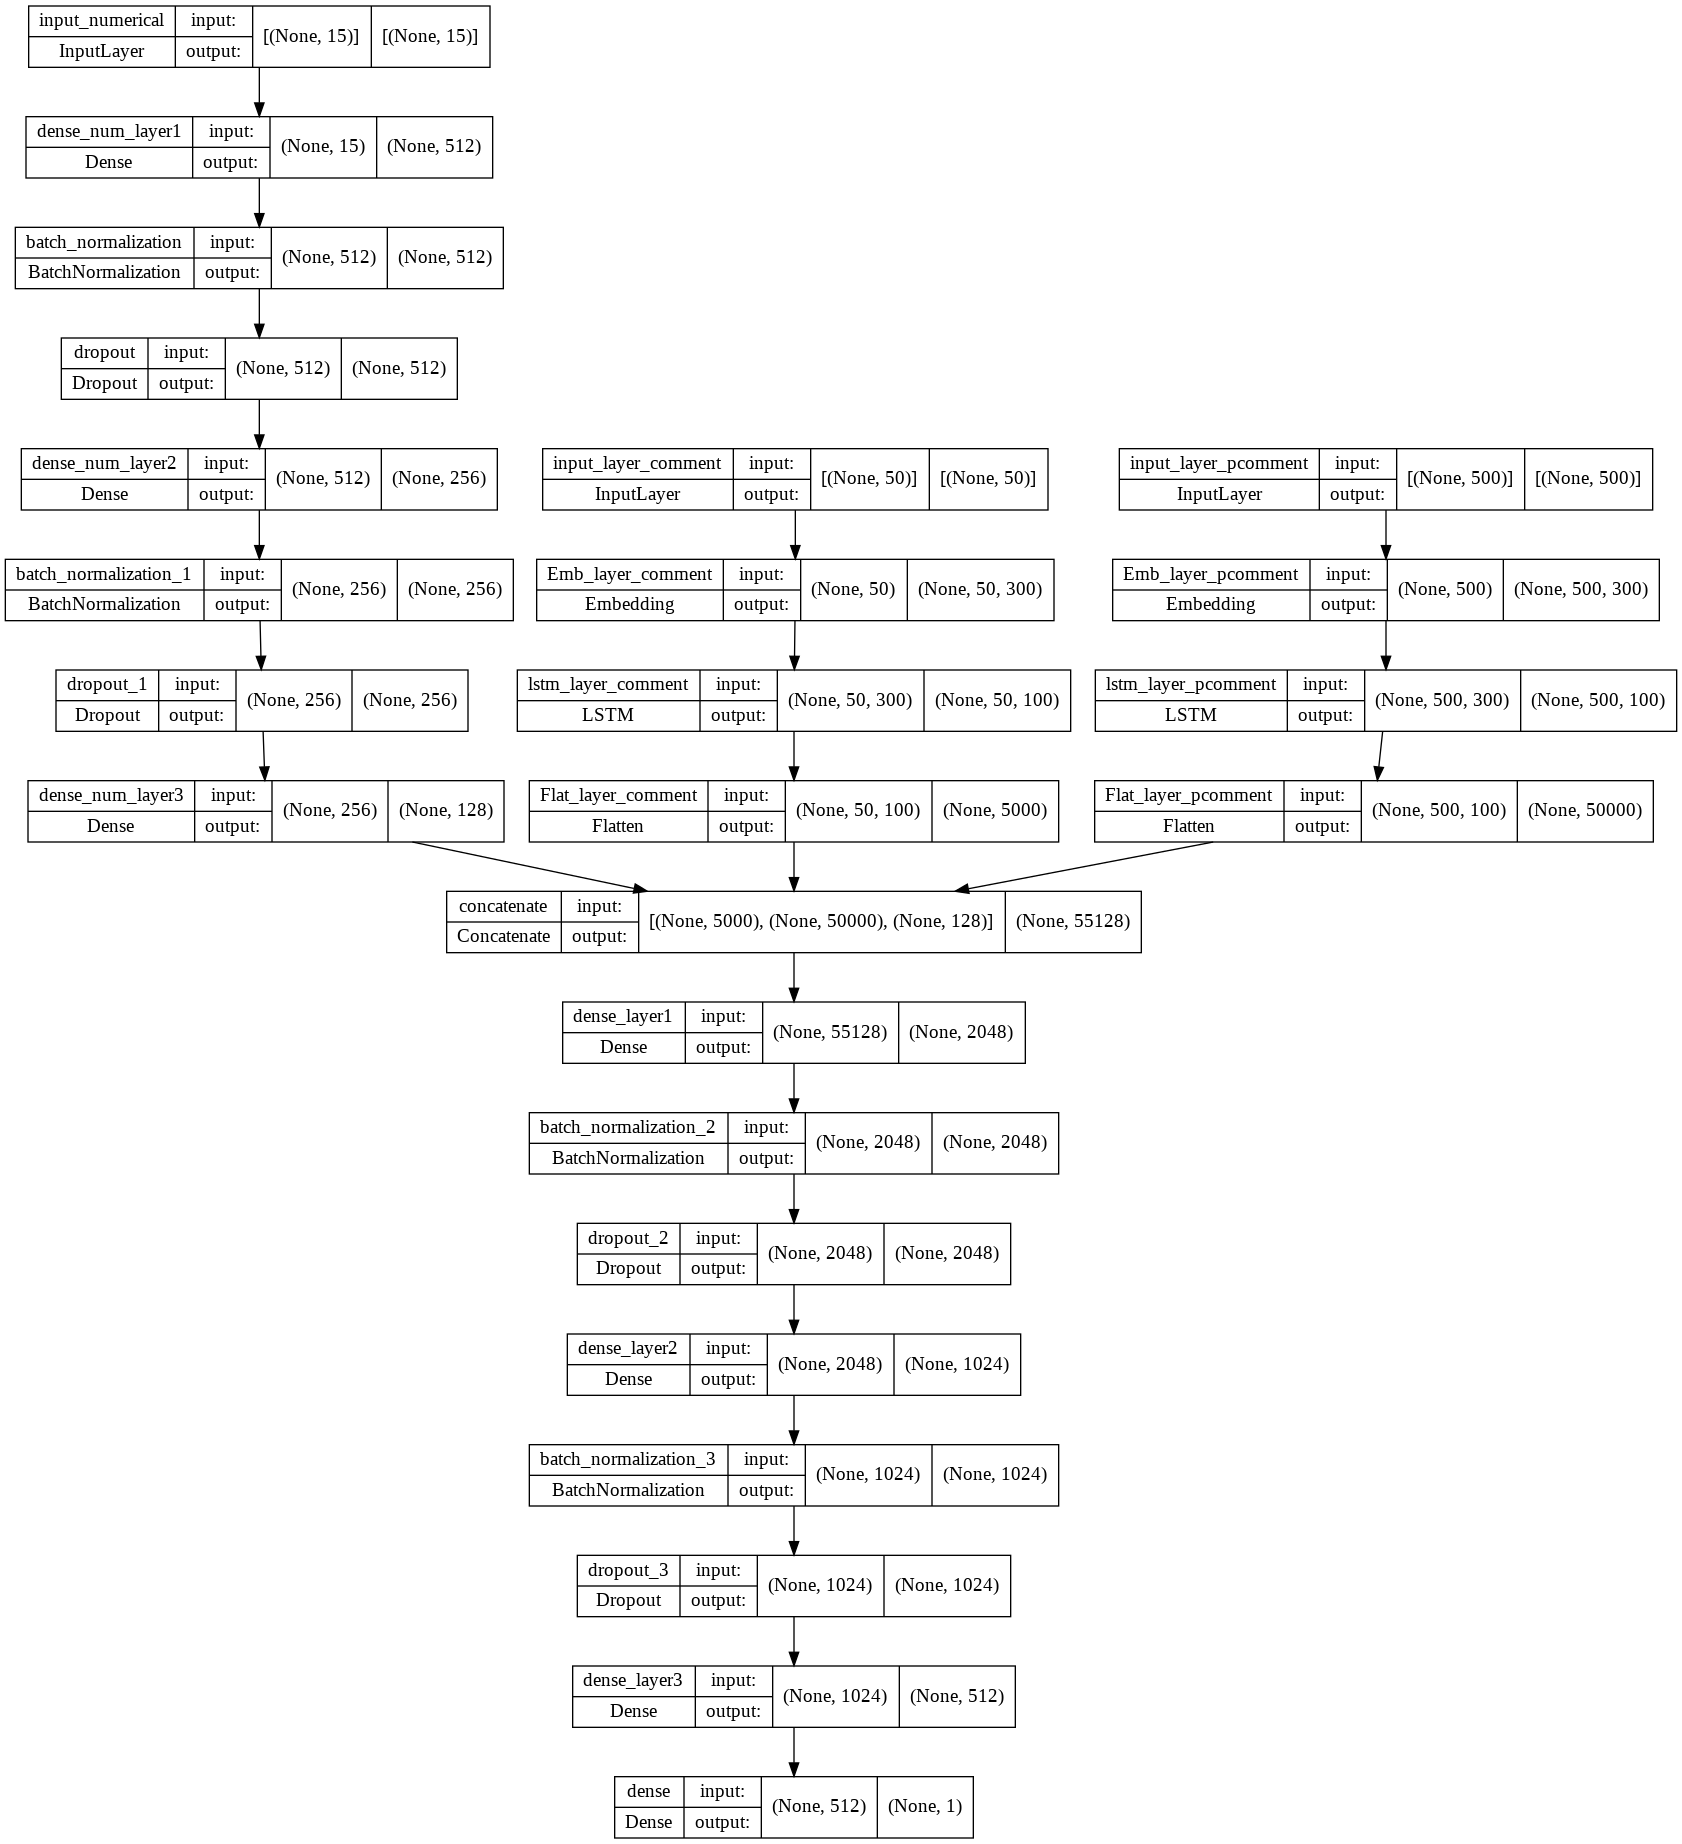

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 624s 259ms/step - loss: 3.3611 - accuracy: 0.6670 - val_loss: 2.0448 - val_accuracy: 0.6501 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - ETA: 0s - loss: 1.4264 - accuracy: 0.7171
Epoch 2: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
2361/2361 [==============================] - 613s 260ms/step - loss: 1.4264 - accuracy: 0.7171 - val_loss: 1.1847 - val_accuracy: 0.6156 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 574s 243ms/step - loss: 0.9538 - accuracy: 0.7360 - val_loss: 1.0397 - val_accuracy: 0.6566 - lr: 2.5000e-05
Epoch 4/50
2361/2361 [==============================] - 614s 260ms/step - loss: 0.8426 - accuracy: 0.7404 - val_loss: 0.9570 - val_accuracy: 0.6576 - lr: 2.5000e-05
Epoch 5/50
2361/2361 [==============================] - ETA: 0s - loss: 0.7692 - accuracy: 0.7442
Epoch 5: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
2361

# 4. LSTM 2 parallel layers and 5 dense layers

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
lstm_layer_comment1 = LSTM(100, dropout= 0.3, return_sequences=True, name= 'lstm_layer_comment1')(embedding_layer_comment)
lstm_layer_comment2 = LSTM(100, dropout= 0.3, return_sequences=True, name= 'lstm_layer_comment2')(embedding_layer_comment)

flat_layer_comment1 = Flatten()(lstm_layer_comment1)
flat_layer_comment2 = Flatten()(lstm_layer_comment2)

concat_comment = Concatenate(axis=-1)([flat_layer_comment1, flat_layer_comment2])


input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
lstm_layer_pcomment1 = LSTM(100, dropout= 0.3, return_sequences=True, name= 'lstm_layer_pcomment1')(embedding_layer_pcomment)
lstm_layer_pcomment2 = LSTM(100, dropout= 0.3, return_sequences=True, name= 'lstm_layer_pcomment2')(embedding_layer_pcomment)

flat_layer_pcomment1 = Flatten()(lstm_layer_pcomment1)
flat_layer_pcomment2 = Flatten()(lstm_layer_pcomment2)

concat_pcomment = Concatenate(axis=-1)([flat_layer_pcomment1, flat_layer_pcomment2])

input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(64, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.0001))(input_layer_num)
dense_num_layer = Dense(32, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.0001))(dense_num_layer)

merged_layer = Concatenate(axis=-1)([concat_comment,concat_pcomment,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.3)(batch_norm_1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.2)(batch_norm_2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(drop_layer2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 2,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

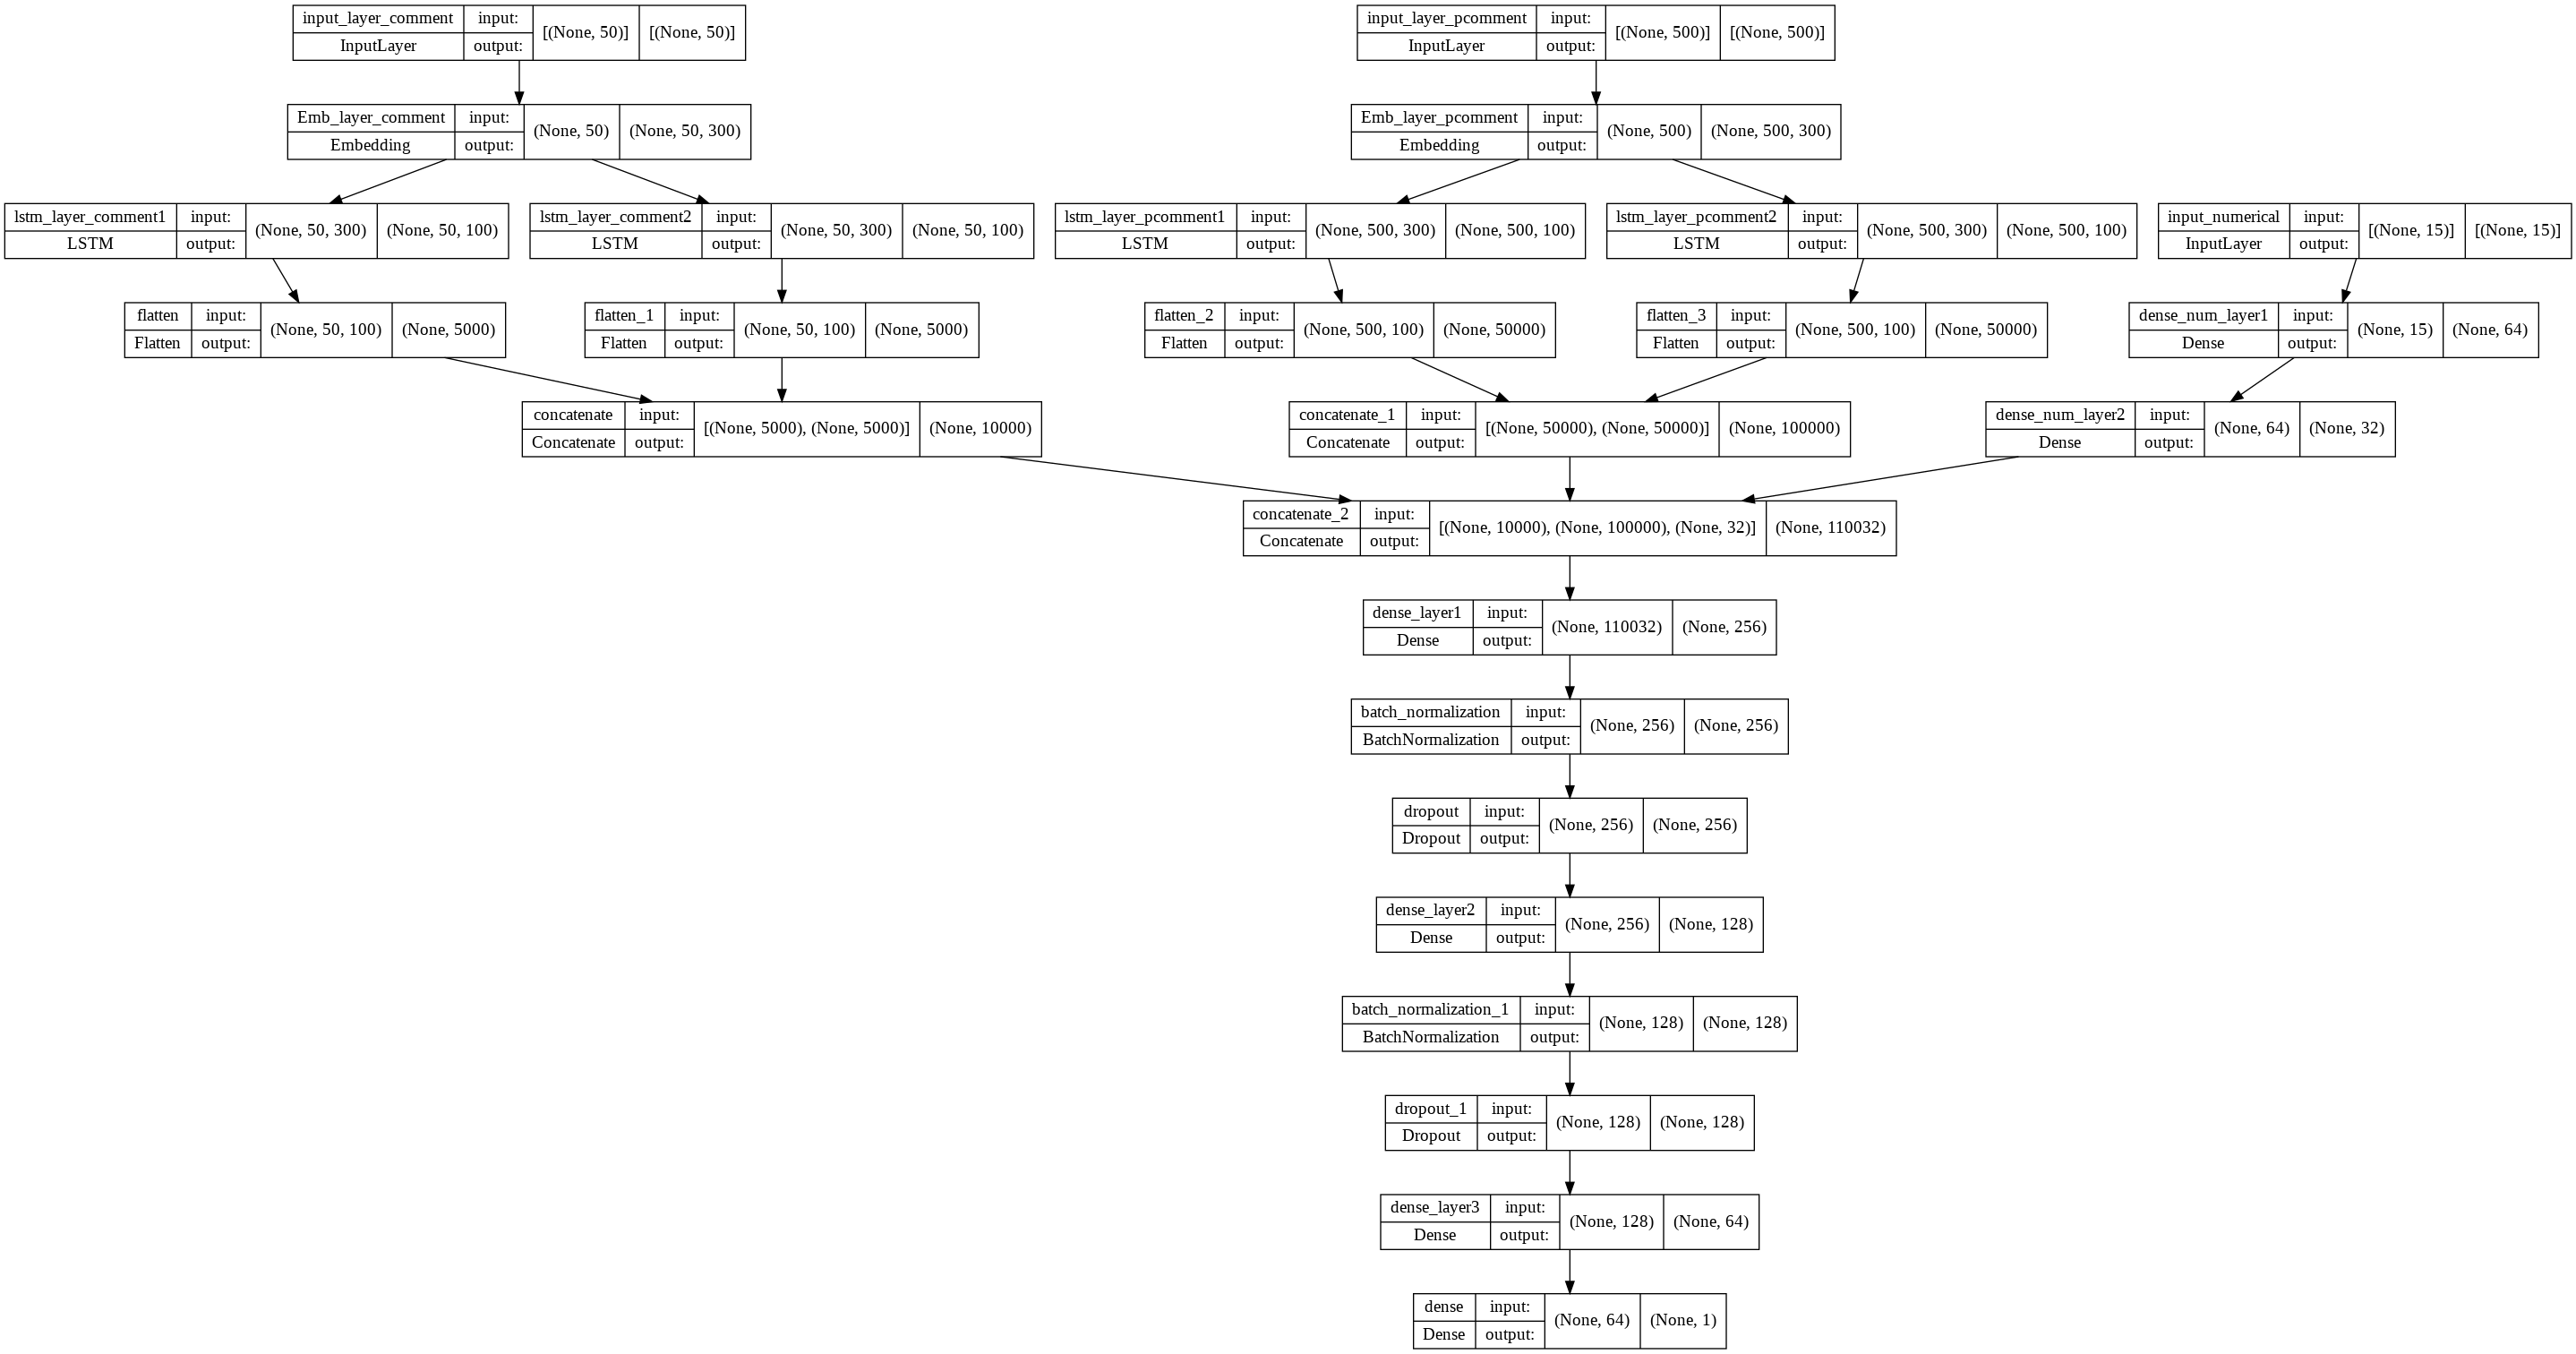

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 670s 280ms/step - loss: 1.0450 - accuracy: 0.6789 - val_loss: 0.9554 - val_accuracy: 0.6404 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 685s 290ms/step - loss: 0.7689 - accuracy: 0.7259 - val_loss: 0.8371 - val_accuracy: 0.6416 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 682s 289ms/step - loss: 0.6552 - accuracy: 0.7422 - val_loss: 0.7674 - val_accuracy: 0.6593 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 681s 289ms/step - loss: 0.5917 - accuracy: 0.7544 - val_loss: 0.7227 - val_accuracy: 0.6664 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.7655
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
2361/2361 [==============================] - 683s 289ms/step - loss: 0.5516 - accuracy: 0.7655 - val_loss: 0.7113 - val_accuracy: 0.6644 - lr: 1.0000e-04
Epoch 6/50
2

# 5. LSTM 2 parallel layers followed by 2 dense layers and 5 dense layers  (embedding is fasttext and trainable=True)

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
lstm_layer_comment1 = LSTM(100, dropout= 0.3, return_sequences=True, name= 'lstm_layer_comment1')(embedding_layer_comment)
lstm_layer_comment2 = LSTM(100, dropout= 0.3, return_sequences=True, name= 'lstm_layer_comment2')(embedding_layer_comment)
flat_layer_comment1 = Flatten()(lstm_layer_comment1)
flat_layer_comment2 = Flatten()(lstm_layer_comment2)
concat_comment = Concatenate(axis=-1)([flat_layer_comment1, flat_layer_comment2])
dense_com1 = Dense(64, activation = "relu", kernel_initializer='he_normal', name='dense_com1', kernel_regularizer=l2(0.0001))(concat_comment)
dense_com2 = Dense(64, activation = "relu", kernel_initializer='he_normal', name='dense_com2', kernel_regularizer=l2(0.0001))(dense_com1)


input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
lstm_layer_pcomment1 = LSTM(100, dropout= 0.3, return_sequences=True, name= 'lstm_layer_pcomment1')(embedding_layer_pcomment)
lstm_layer_pcomment2 = LSTM(100, dropout= 0.3, return_sequences=True, name= 'lstm_layer_pcomment2')(embedding_layer_pcomment)
flat_layer_pcomment1 = Flatten()(lstm_layer_pcomment1)
flat_layer_pcomment2 = Flatten()(lstm_layer_pcomment2)
concat_pcomment = Concatenate(axis=-1)([flat_layer_pcomment1, flat_layer_pcomment2])
dense_pcom1 = Dense(64, activation = "relu", kernel_initializer='he_normal', name='dense_pcom1', kernel_regularizer=l2(0.0001))(concat_pcomment)
dense_pcom2 = Dense(64, activation = "relu", kernel_initializer='he_normal', name='dense_pcom2', kernel_regularizer=l2(0.0001))(dense_pcom1)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(64, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.0001))(input_layer_num)
dense_num_layer = Dense(32, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.0001))(dense_num_layer)

merged_layer = Concatenate(axis=-1)([dense_com2,dense_pcom2,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.3)(batch_norm_1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.2)(batch_norm_2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(drop_layer2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 2,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

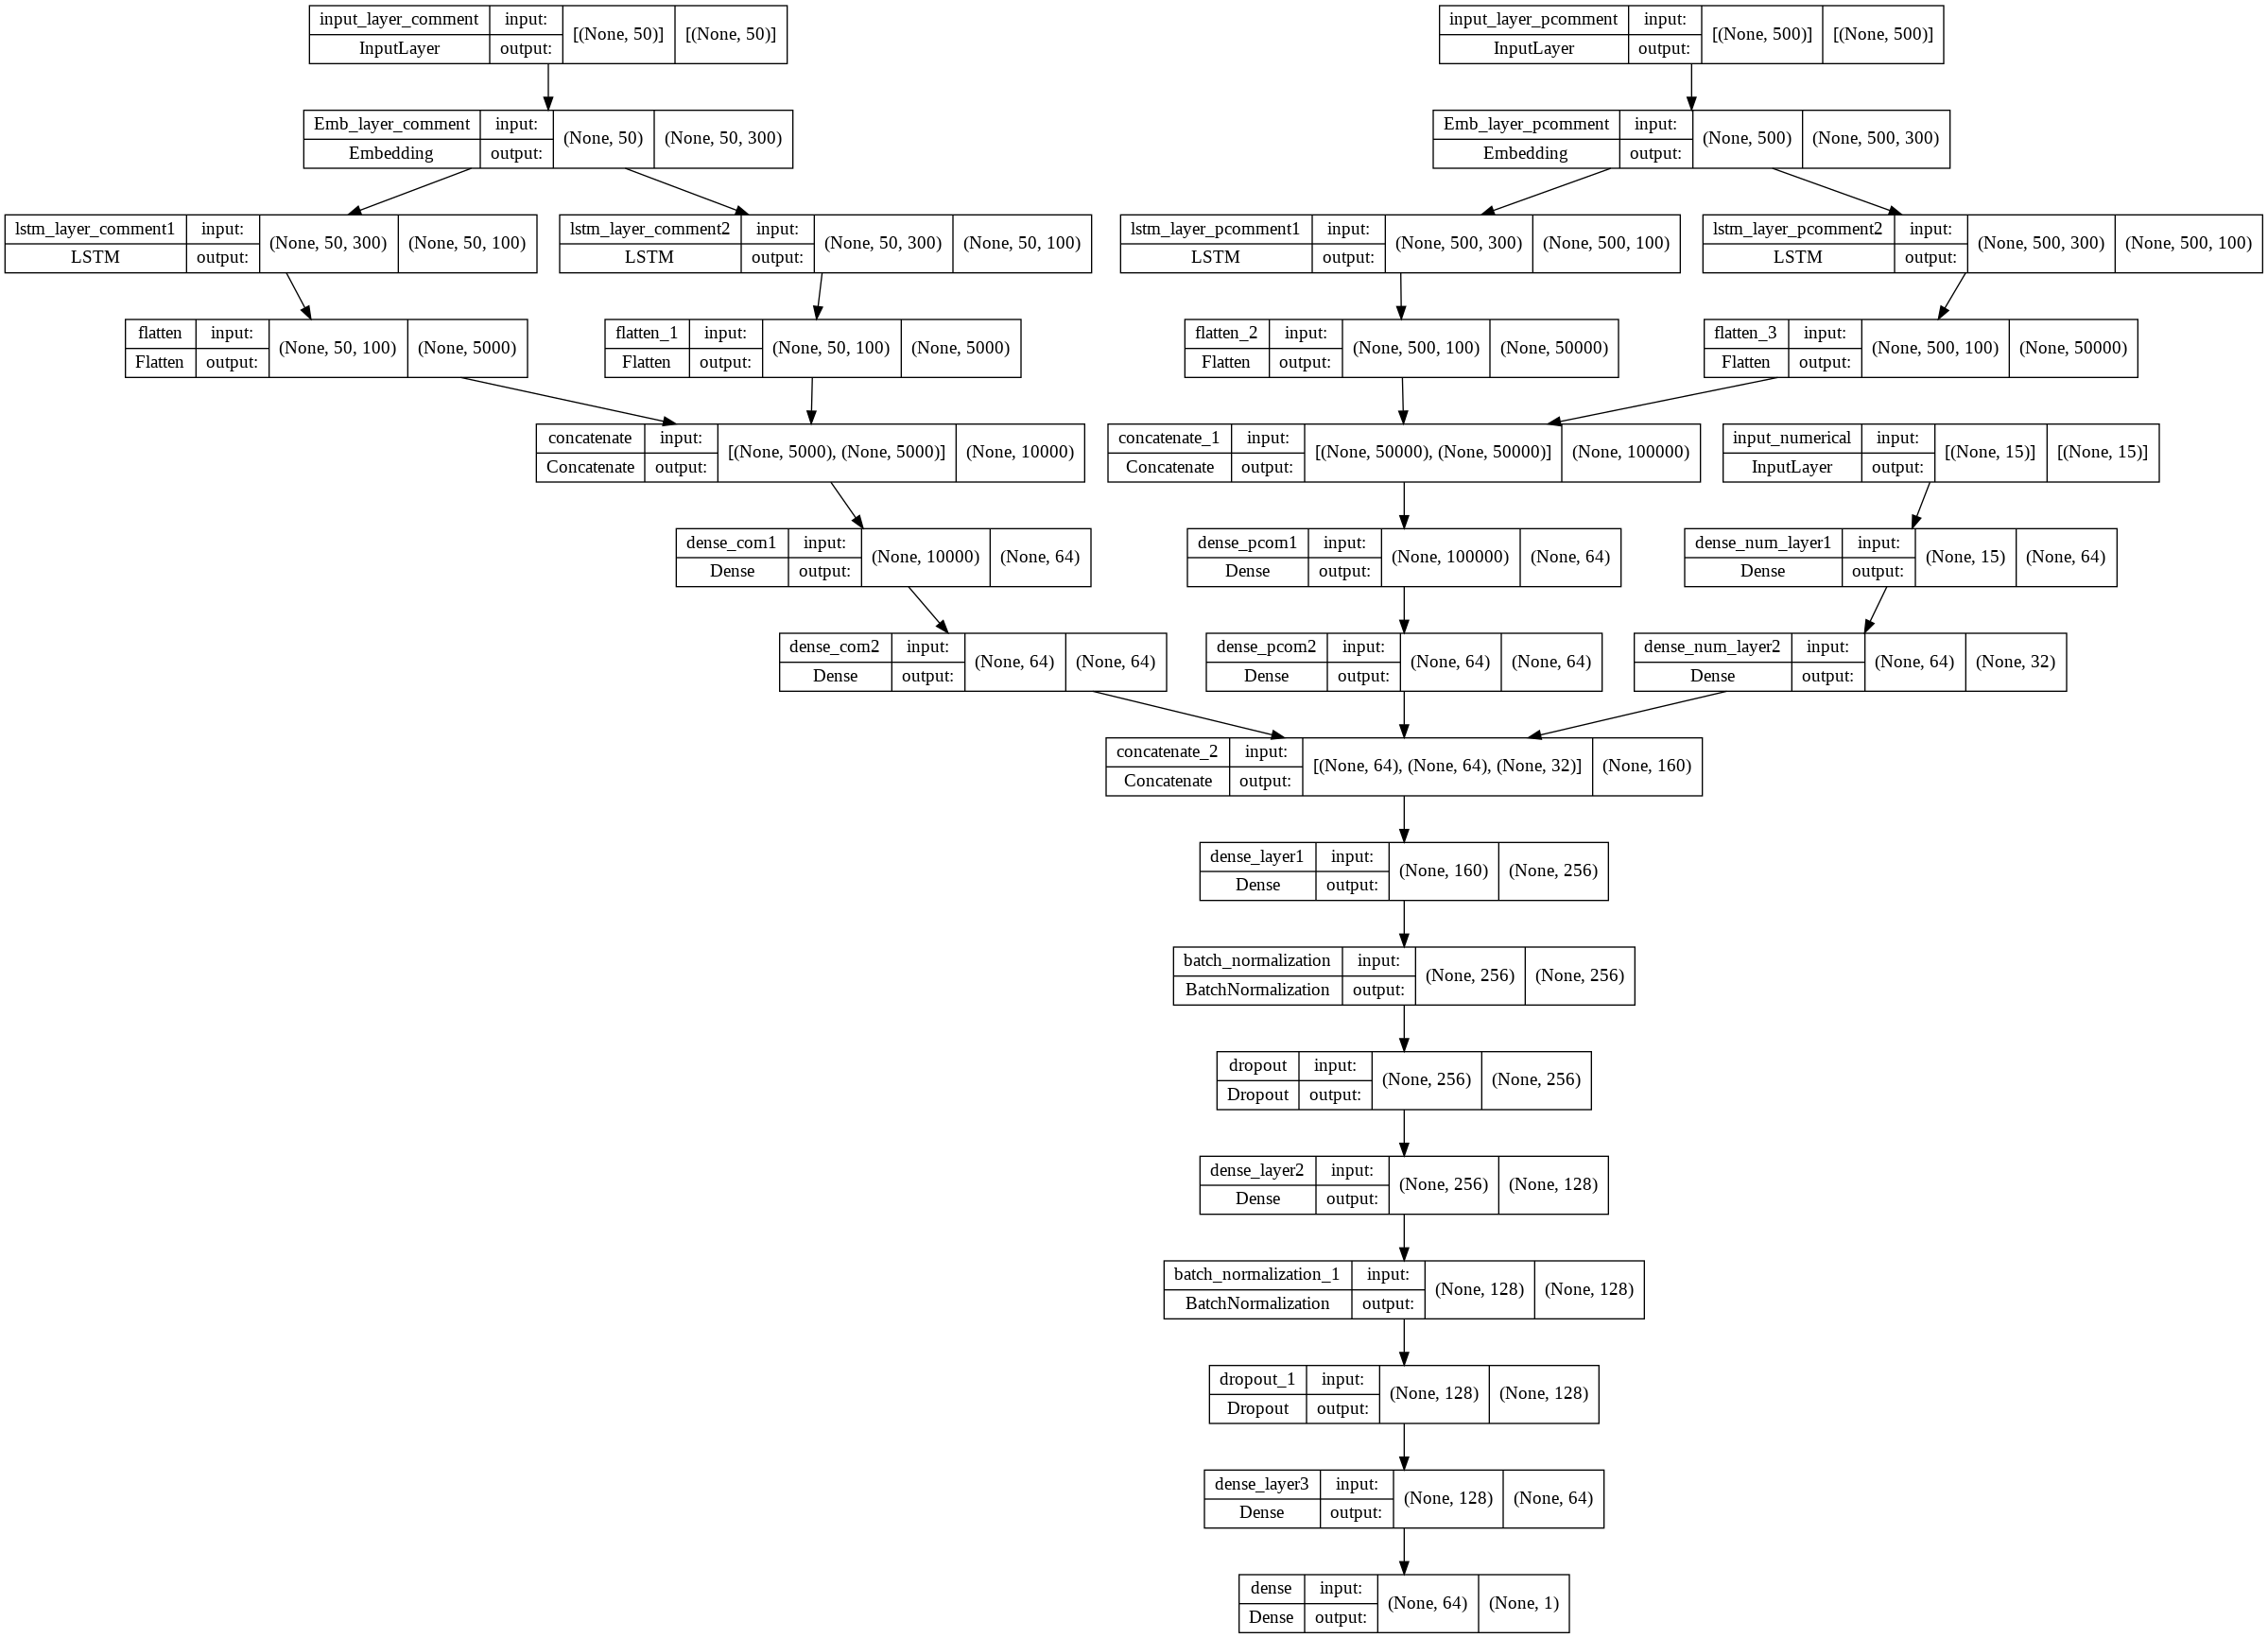

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 641s 266ms/step - loss: 1.2840 - accuracy: 0.6743 - val_loss: 1.1619 - val_accuracy: 0.6345 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 625s 265ms/step - loss: 0.9088 - accuracy: 0.7239 - val_loss: 0.9406 - val_accuracy: 0.6499 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 630s 267ms/step - loss: 0.7234 - accuracy: 0.7422 - val_loss: 0.8289 - val_accuracy: 0.6525 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 631s 267ms/step - loss: 0.6161 - accuracy: 0.7558 - val_loss: 0.7603 - val_accuracy: 0.6620 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.7695
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
2361/2361 [==============================] - 627s 265ms/step - loss: 0.5521 - accuracy: 0.7695 - val_loss: 0.7558 - val_accuracy: 0.6604 - lr: 1.0000e-04
Epoch 6/50
2

# 6. LSTM 2 layers and 5 dense layers (embedding is fasttext and trainable=True)

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)

lstm_layer_comment1 = LSTM(100, dropout = 0.3, name= 'lstm_layer_comment1', return_sequences=True)(embedding_layer_comment)
lstm_layer_comment2 = LSTM(100, dropout = 0.3, name= 'lstm_layer_comment2', return_sequences=True)(lstm_layer_comment1)

flat_layer_comment = Flatten(name='Flat_layer_comment')(lstm_layer_comment2)


input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)

lstm_layer_pcomment1 = LSTM(100, dropout = 0.3, name= 'lstm_layer_pcomment1', return_sequences=True)(embedding_layer_pcomment)
lstm_layer_pcomment2 = LSTM(100, dropout = 0.3, name= 'lstm_layer_pcomment2', return_sequences=True)(lstm_layer_pcomment1)


flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(lstm_layer_pcomment2)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer1 = Dense(256, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.001))(input_layer_num)
dense_num_layer2 = Dense(128, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.001))(dense_num_layer1)


merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer2])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.3)(batch_norm_1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.2)(batch_norm_2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(drop_layer2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 2, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

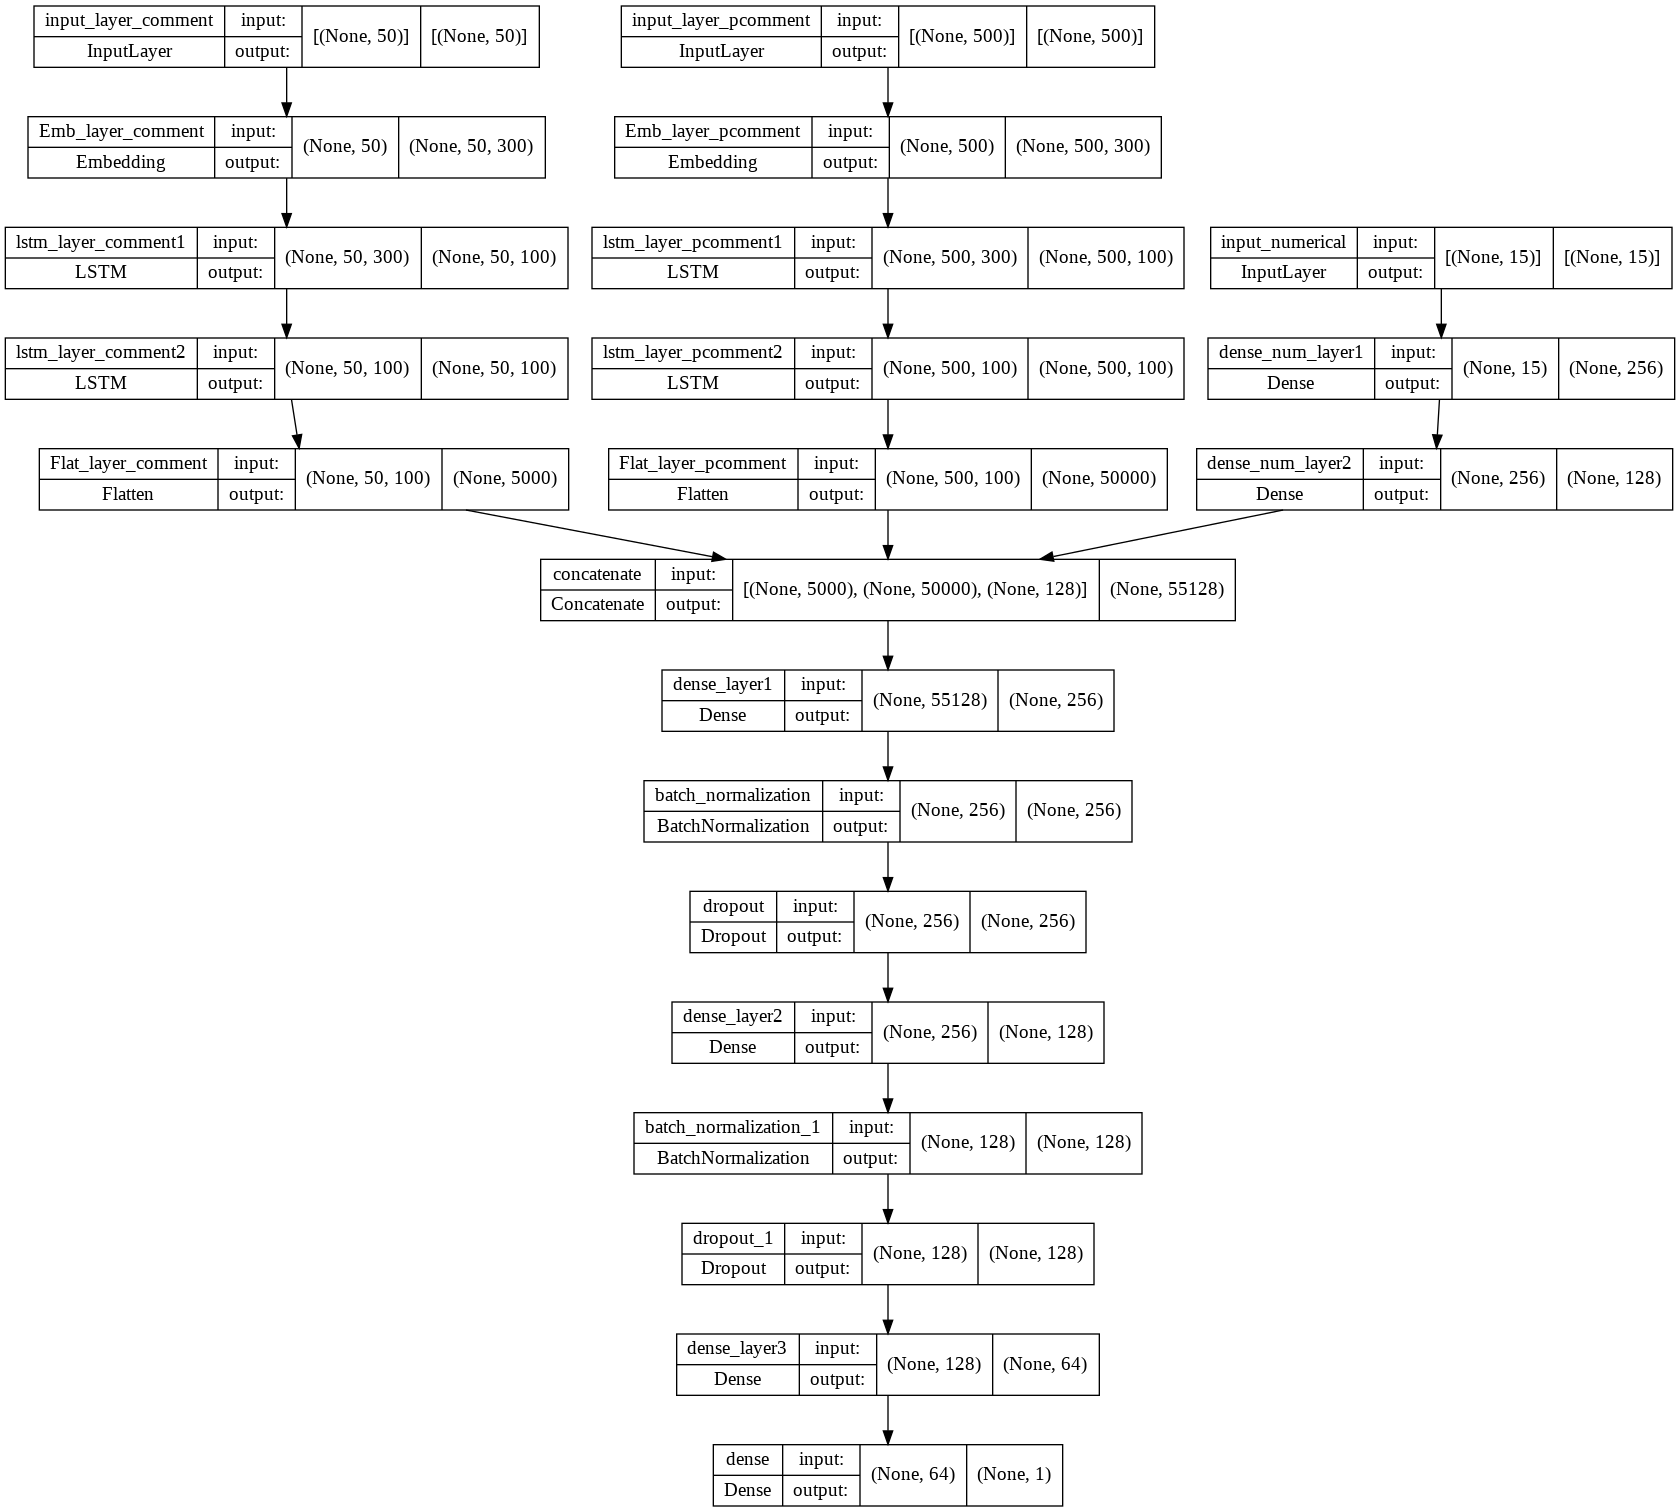

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
history = model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 563s 229ms/step - loss: 1.5228 - accuracy: 0.6781 - val_loss: 1.3232 - val_accuracy: 0.5989 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 499s 211ms/step - loss: 0.9519 - accuracy: 0.7174 - val_loss: 0.9787 - val_accuracy: 0.6349 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 499s 212ms/step - loss: 0.7231 - accuracy: 0.7327 - val_loss: 0.7886 - val_accuracy: 0.6535 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 537s 227ms/step - loss: 0.6177 - accuracy: 0.7431 - val_loss: 0.7490 - val_accuracy: 0.6543 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - 541s 229ms/step - loss: 0.5650 - accuracy: 0.7529 - val_loss: 0.7363 - val_accuracy: 0.6510 - lr: 1.0000e-04
Epoch 6/50
2361/2361 [==============================] - 540s 229ms/step - loss: 0.5328 - accuracy: 0.7623 - val_loss: 0.6692 - val_accuracy: 0.6681 - lr: 1.0000e-04
Epoch 7/50

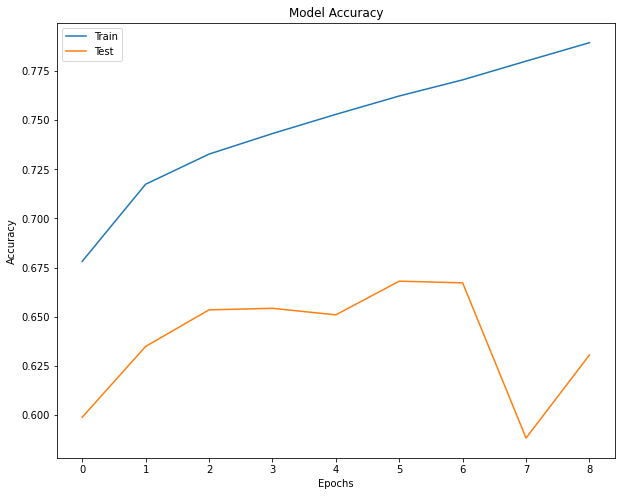

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

# 7. LSTM 2 parallel layers and 6 dense layers(embedding is fasttext and trainable=True)

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)

lstm_layer_comment1_1 = LSTM(100, dropout = 0.3, name= 'lstm_layer_comment1_1', return_sequences=True)(embedding_layer_comment)
lstm_layer_comment2_1 = LSTM(100, dropout = 0.3, name= 'lstm_layer_comment2_1', return_sequences=True)(lstm_layer_comment1_1)

flat_layer_comment1 = Flatten(name='Flat_layer_comment1')(lstm_layer_comment2_1)

lstm_layer_comment1_2 = LSTM(100, dropout = 0.3, name= 'lstm_layer_comment1', return_sequences=True)(embedding_layer_comment)
lstm_layer_comment2_2 = LSTM(100, dropout = 0.3, name= 'lstm_layer_comment2', return_sequences=True)(lstm_layer_comment1_2)

flat_layer_comment2 = Flatten(name='Flat_layer_comment2')(lstm_layer_comment2_2)

concat_layer_com = Concatenate(axis=-1)([flat_layer_comment1, flat_layer_comment2])


input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)

lstm_layer_pcomment1_1 = LSTM(100, dropout = 0.3, name= 'lstm_layer_pcomment1_1', return_sequences=True)(embedding_layer_pcomment)
lstm_layer_pcomment2_1 = LSTM(100, dropout = 0.3, name= 'lstm_layer_pcomment2_1', return_sequences=True)(lstm_layer_pcomment1_1)


flat_layer_pcomment1 = Flatten(name='Flat_layer_pcomment1')(lstm_layer_pcomment2_1)

lstm_layer_pcomment1_2 = LSTM(100, dropout = 0.3, name= 'lstm_layer_pcomment1_2', return_sequences=True)(embedding_layer_pcomment)
lstm_layer_pcomment2_2 = LSTM(100, dropout = 0.3, name= 'lstm_layer_pcomment2_2', return_sequences=True)(lstm_layer_pcomment1_2)


flat_layer_pcomment2 = Flatten(name='Flat_layer_pcomment2')(lstm_layer_pcomment2_2)

concat_layer_pcom = Concatenate(axis=-1)([flat_layer_pcomment1, flat_layer_pcomment2])


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer1 = Dense(256, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.001))(input_layer_num)
dense_num_layer2 = Dense(128, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.001))(dense_num_layer1)
dense_num_layer3 = Dense(128, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer3', kernel_regularizer=l2(0.001))(dense_num_layer2)


merged_layer = Concatenate(axis=-1)([concat_layer_com,concat_layer_pcom,dense_num_layer3])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.3)(batch_norm_1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.2)(batch_norm_2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(drop_layer2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

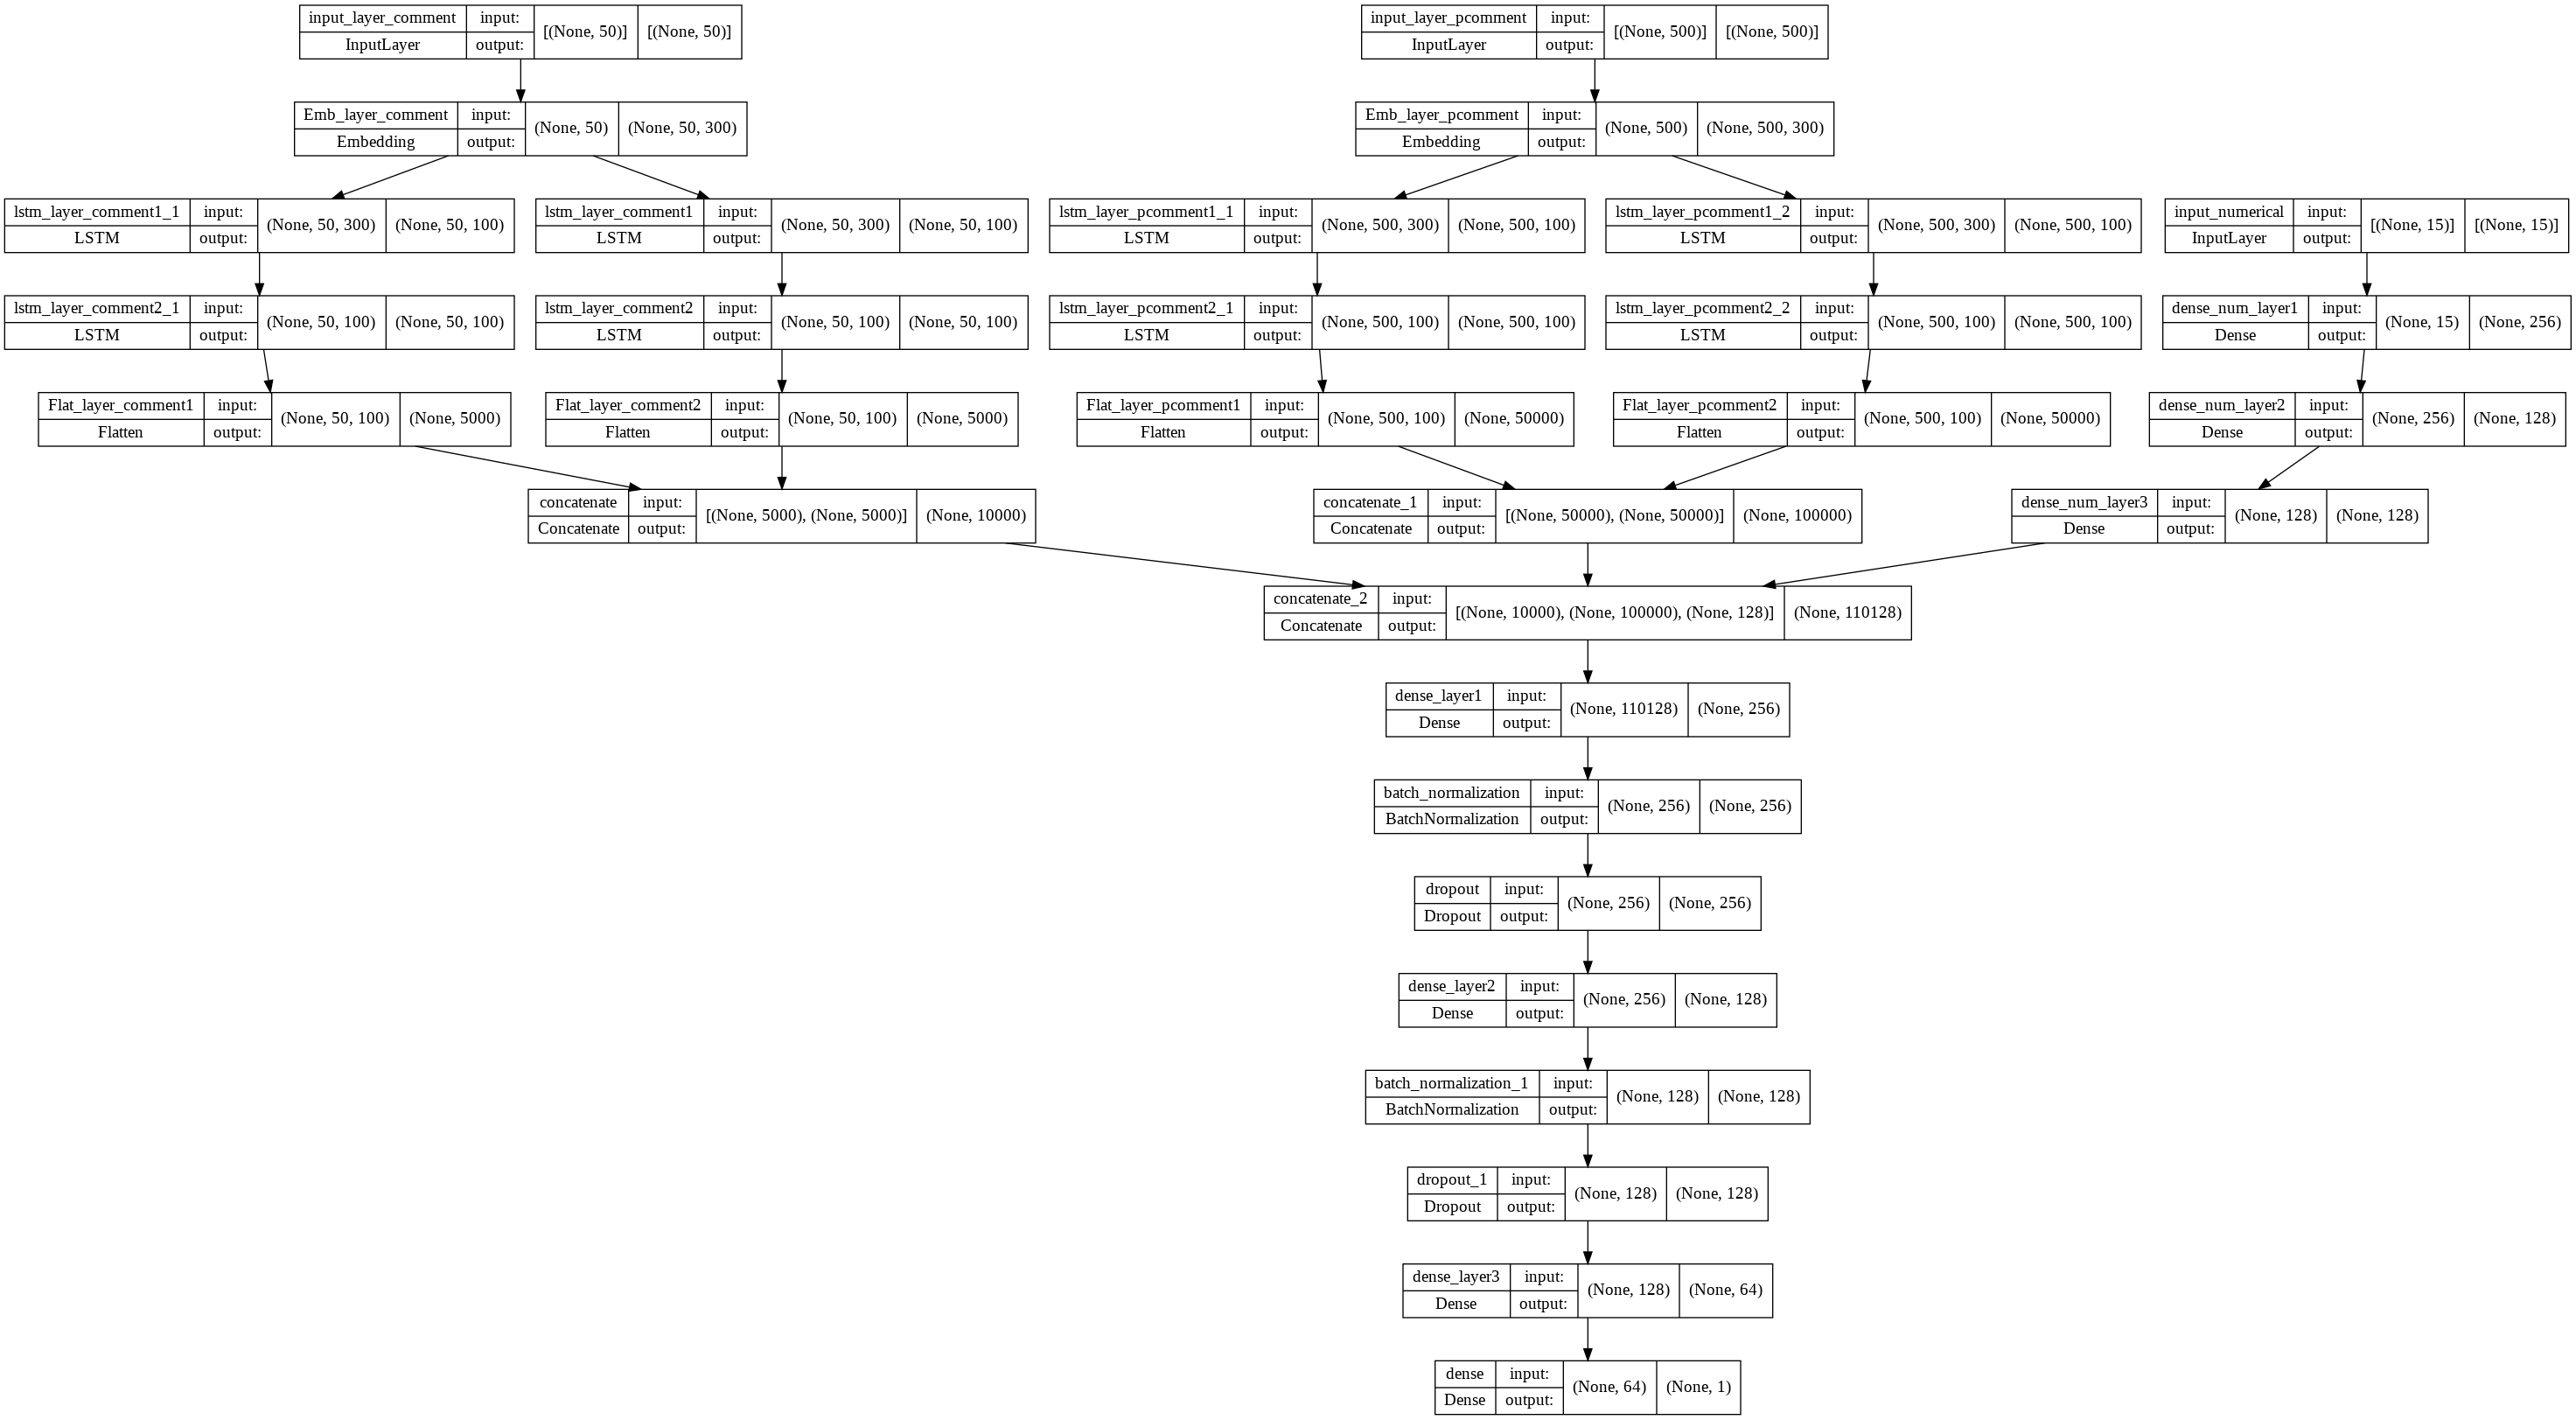

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
history = model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 912s 377ms/step - loss: 1.5734 - accuracy: 0.6872 - val_loss: 1.3550 - val_accuracy: 0.5754 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 888s 376ms/step - loss: 0.9212 - accuracy: 0.7257 - val_loss: 0.9464 - val_accuracy: 0.6208 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 892s 378ms/step - loss: 0.6989 - accuracy: 0.7397 - val_loss: 0.7735 - val_accuracy: 0.6544 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - ETA: 0s - loss: 0.6029 - accuracy: 0.7513
Epoch 4: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
2361/2361 [==============================] - 887s 376ms/step - loss: 0.6029 - accuracy: 0.7513 - val_loss: 0.7438 - val_accuracy: 0.6543 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - 895s 379ms/step - loss: 0.5529 - accuracy: 0.7629 - val_loss: 0.7128 - val_accuracy: 0.6576 - lr: 8.0000e-05
Epoch 6/50
2

# 8. CNN 2 layers and 5 dense layers (Embedding is fasttext and trainable = True)

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=81,trainable=True, name='Emb_layer_comment')(input_layer_comment)
dropout_layer_comment = Dropout(0.5, name='dropout_layer_comment')(embedding_layer_comment)

first_cov_comment = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_comment')(dropout_layer_comment)
first_maxpool_comment = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_comment')(first_cov_comment)
second_cov_comment = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_comment')(first_maxpool_comment)
second_maxpool_comment = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_comment')(second_cov_comment)
flat_layer_comment = Flatten(name='Flat_layer_comment')(second_maxpool_comment)


input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=574,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
dropout_layer_pcomment = Dropout(0.5, name='dropout_layer_pcomment')(embedding_layer_pcomment)

first_cov_pcomment = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_pcomment')(dropout_layer_pcomment)
first_maxpool_pcomment = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_pcomment')(first_cov_pcomment)
second_cov_pcomment = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_pcomment')(first_maxpool_pcomment)
second_maxpool_pcomment = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_pcomment')(second_cov_pcomment)
flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(second_maxpool_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer1 = Dense(256, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.001))(input_layer_num)
dense_num_layer2 = Dense(128, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.001))(dense_num_layer1)


merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer2])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.3)(batch_norm_1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.2)(batch_norm_2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(drop_layer2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

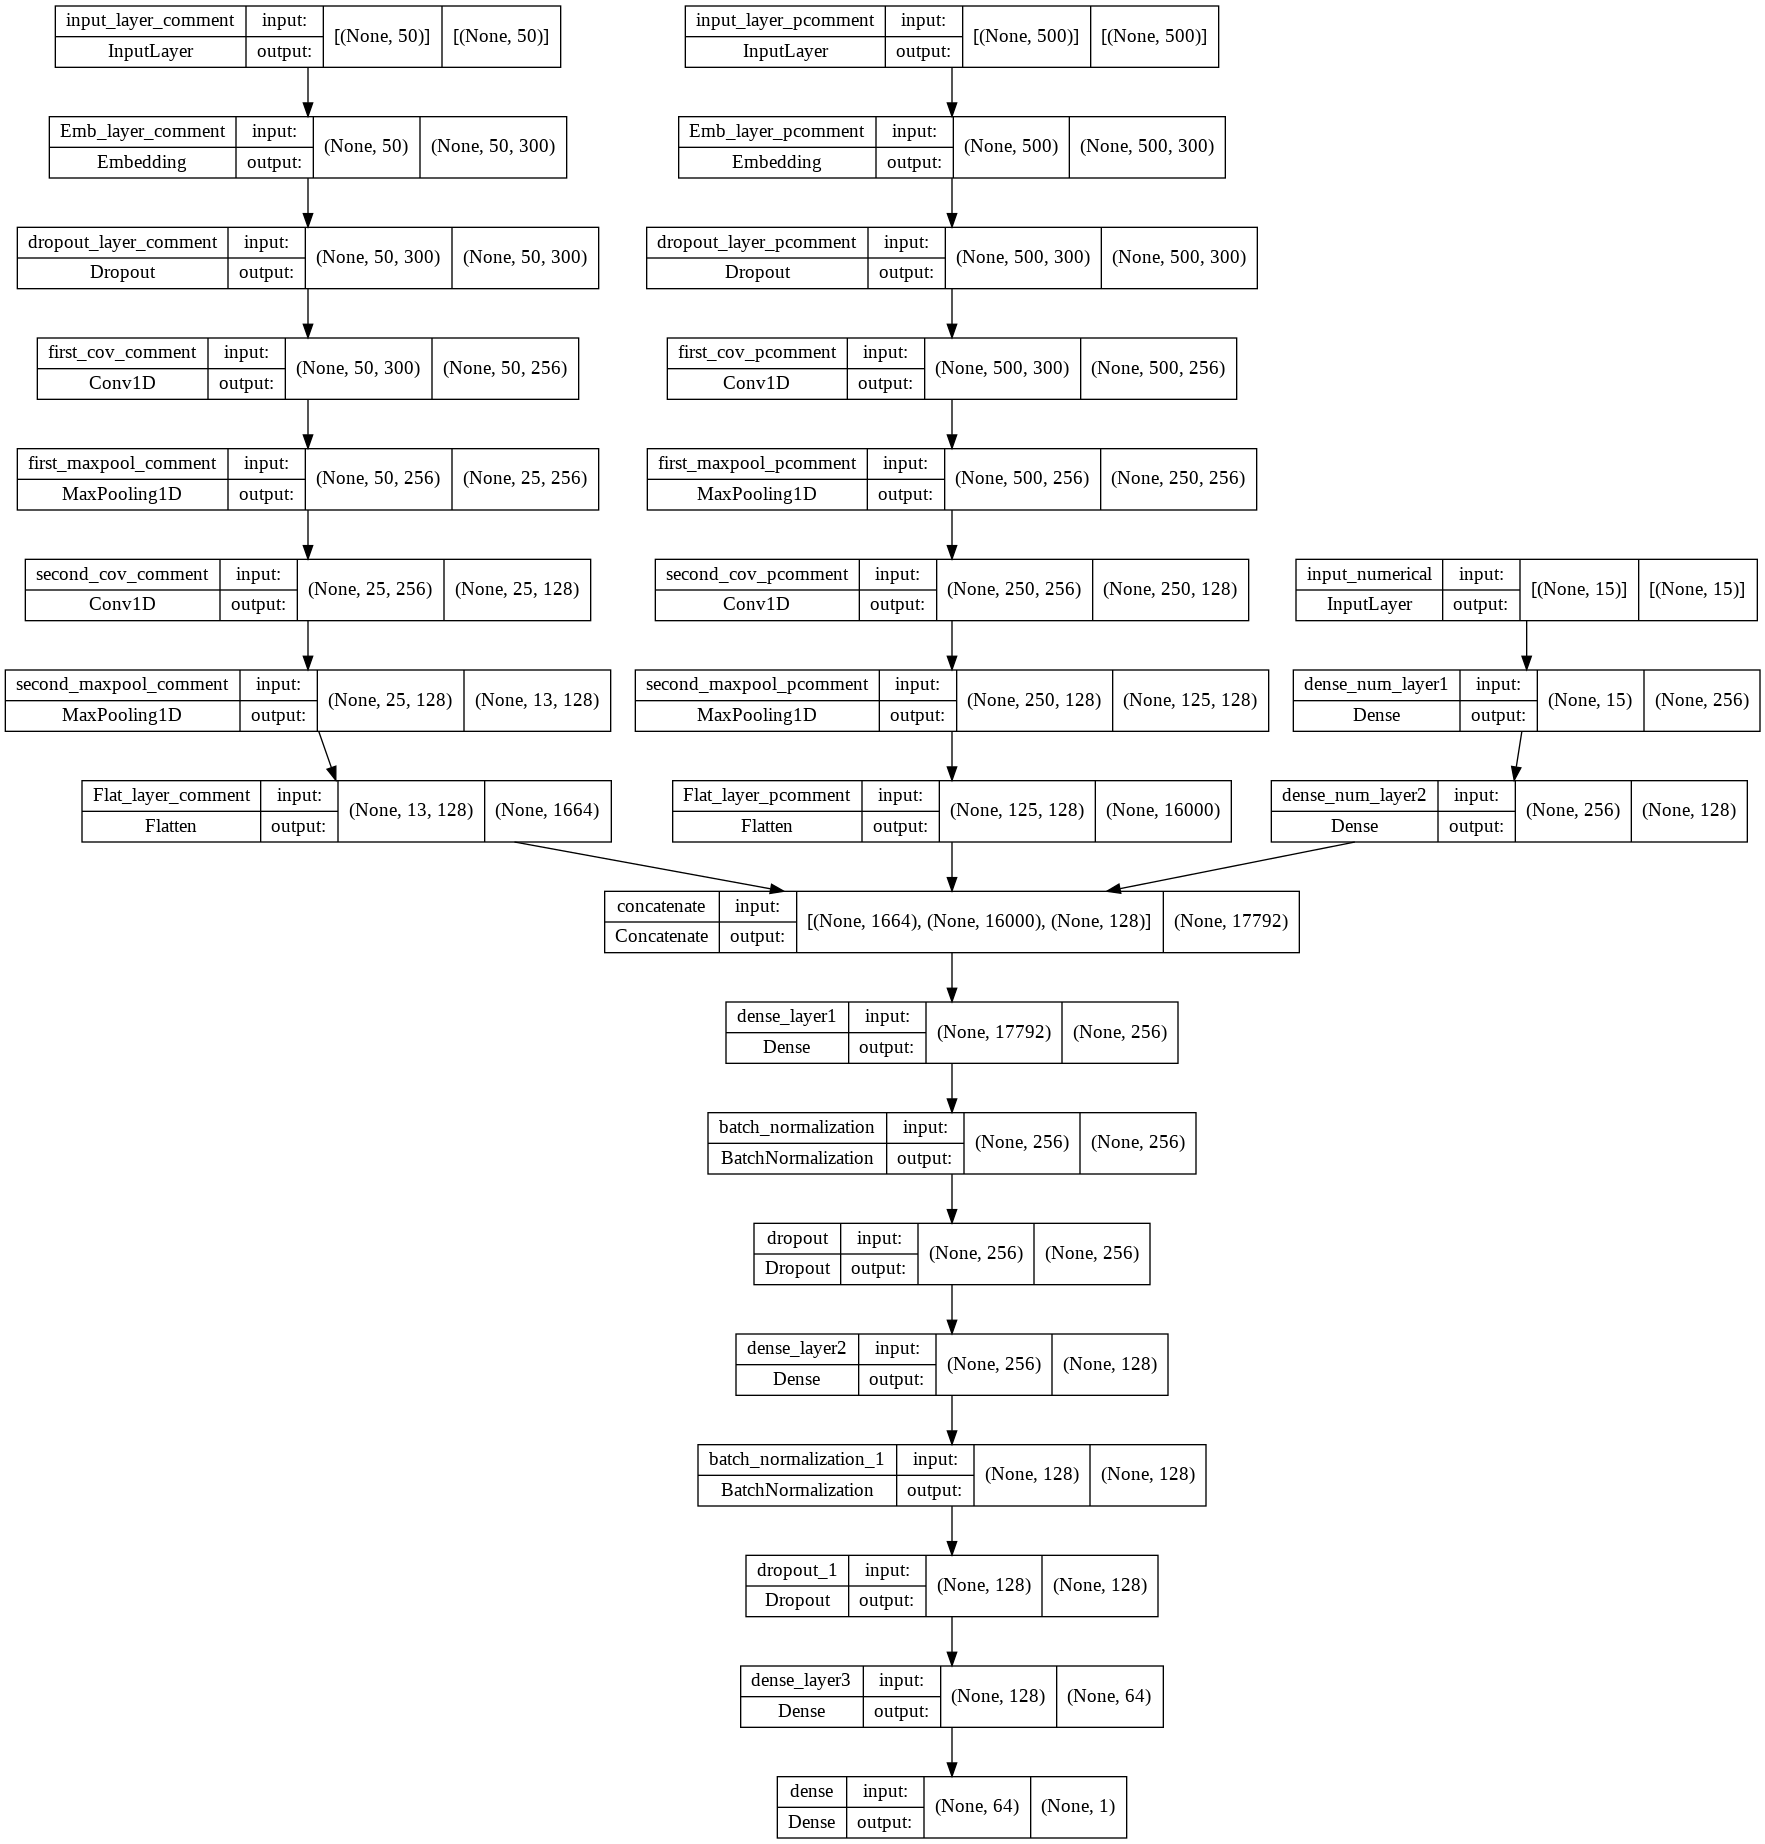

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
history = model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 417s 170ms/step - loss: 1.5376 - accuracy: 0.6598 - val_loss: 1.2817 - val_accuracy: 0.6119 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 405s 171ms/step - loss: 0.9618 - accuracy: 0.7095 - val_loss: 0.9607 - val_accuracy: 0.6336 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 405s 172ms/step - loss: 0.7321 - accuracy: 0.7238 - val_loss: 0.7956 - val_accuracy: 0.6517 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 391s 166ms/step - loss: 0.6278 - accuracy: 0.7334 - val_loss: 0.7445 - val_accuracy: 0.6576 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - 403s 171ms/step - loss: 0.5773 - accuracy: 0.7412 - val_loss: 0.7038 - val_accuracy: 0.6629 - lr: 1.0000e-04
Epoch 6/50
2361/2361 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.7486
Epoch 6: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
2

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

# 9. CNN 2 parallel layers and 5 dense layers (Embedding is fasttext and trainable = True)

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
dropout_layer_comment1 = Dropout(0.5, name='dropout_layer_comment1')(embedding_layer_comment)

first_cov_comment1 = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_comment1', kernel_regularizer=l2(0.001))(dropout_layer_comment1)
first_maxpool_comment1 = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_comment1')(first_cov_comment1)
second_cov_comment1 = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_comment1', kernel_regularizer=l2(0.001))(first_maxpool_comment1)
second_maxpool_comment1 = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_comment1')(second_cov_comment1)
flat_layer_comment1 = Flatten(name='Flat_layer_comment1')(second_maxpool_comment1)

dropout_layer_comment2 = Dropout(0.5, name='dropout_layer_comment2')(embedding_layer_comment)

first_cov_comment2 = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_comment2', kernel_regularizer=l2(0.001))(dropout_layer_comment2)
first_maxpool_comment2 = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_comment2')(first_cov_comment2)
second_cov_comment2 = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_comment2', kernel_regularizer=l2(0.001))(first_maxpool_comment2)
second_maxpool_comment2 = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_comment2')(second_cov_comment2)
flat_layer_comment2 = Flatten(name='Flat_layer_comment2')(second_maxpool_comment2)


input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
dropout_layer_pcomment1 = Dropout(0.5, name='dropout_layer_pcomment1')(embedding_layer_pcomment)

first_cov_pcomment1 = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_pcomment1', kernel_regularizer=l2(0.001))(dropout_layer_pcomment1)
first_maxpool_pcomment1 = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_pcomment1')(first_cov_pcomment1)
second_cov_pcomment1 = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_pcomment1', kernel_regularizer=l2(0.001))(first_maxpool_pcomment1)
second_maxpool_pcomment1 = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_pcomment1')(second_cov_pcomment1)
flat_layer_pcomment1 = Flatten(name='Flat_layer_pcomment1')(second_maxpool_pcomment1)

dropout_layer_pcomment2 = Dropout(0.5, name='dropout_layer_pcomment2')(embedding_layer_pcomment)

first_cov_pcomment2 = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_pcomment2', kernel_regularizer=l2(0.001))(dropout_layer_pcomment2)
first_maxpool_pcomment2 = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_pcomment2')(first_cov_pcomment2)
second_cov_pcomment2 = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_pcomment2', kernel_regularizer=l2(0.001))(first_maxpool_pcomment2)
second_maxpool_pcomment2 = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_pcomment2')(second_cov_pcomment2)
flat_layer_pcomment2 = Flatten(name='Flat_layer_pcomment2')(second_maxpool_pcomment2)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer1 = Dense(256, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.001))(input_layer_num)
dense_num_layer2 = Dense(128, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.001))(dense_num_layer1)


merged_layer = Concatenate(axis=-1)([flat_layer_comment1,flat_layer_pcomment1,flat_layer_comment2,flat_layer_pcomment2,dense_num_layer2])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.3)(batch_norm_1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.2)(batch_norm_2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(drop_layer2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

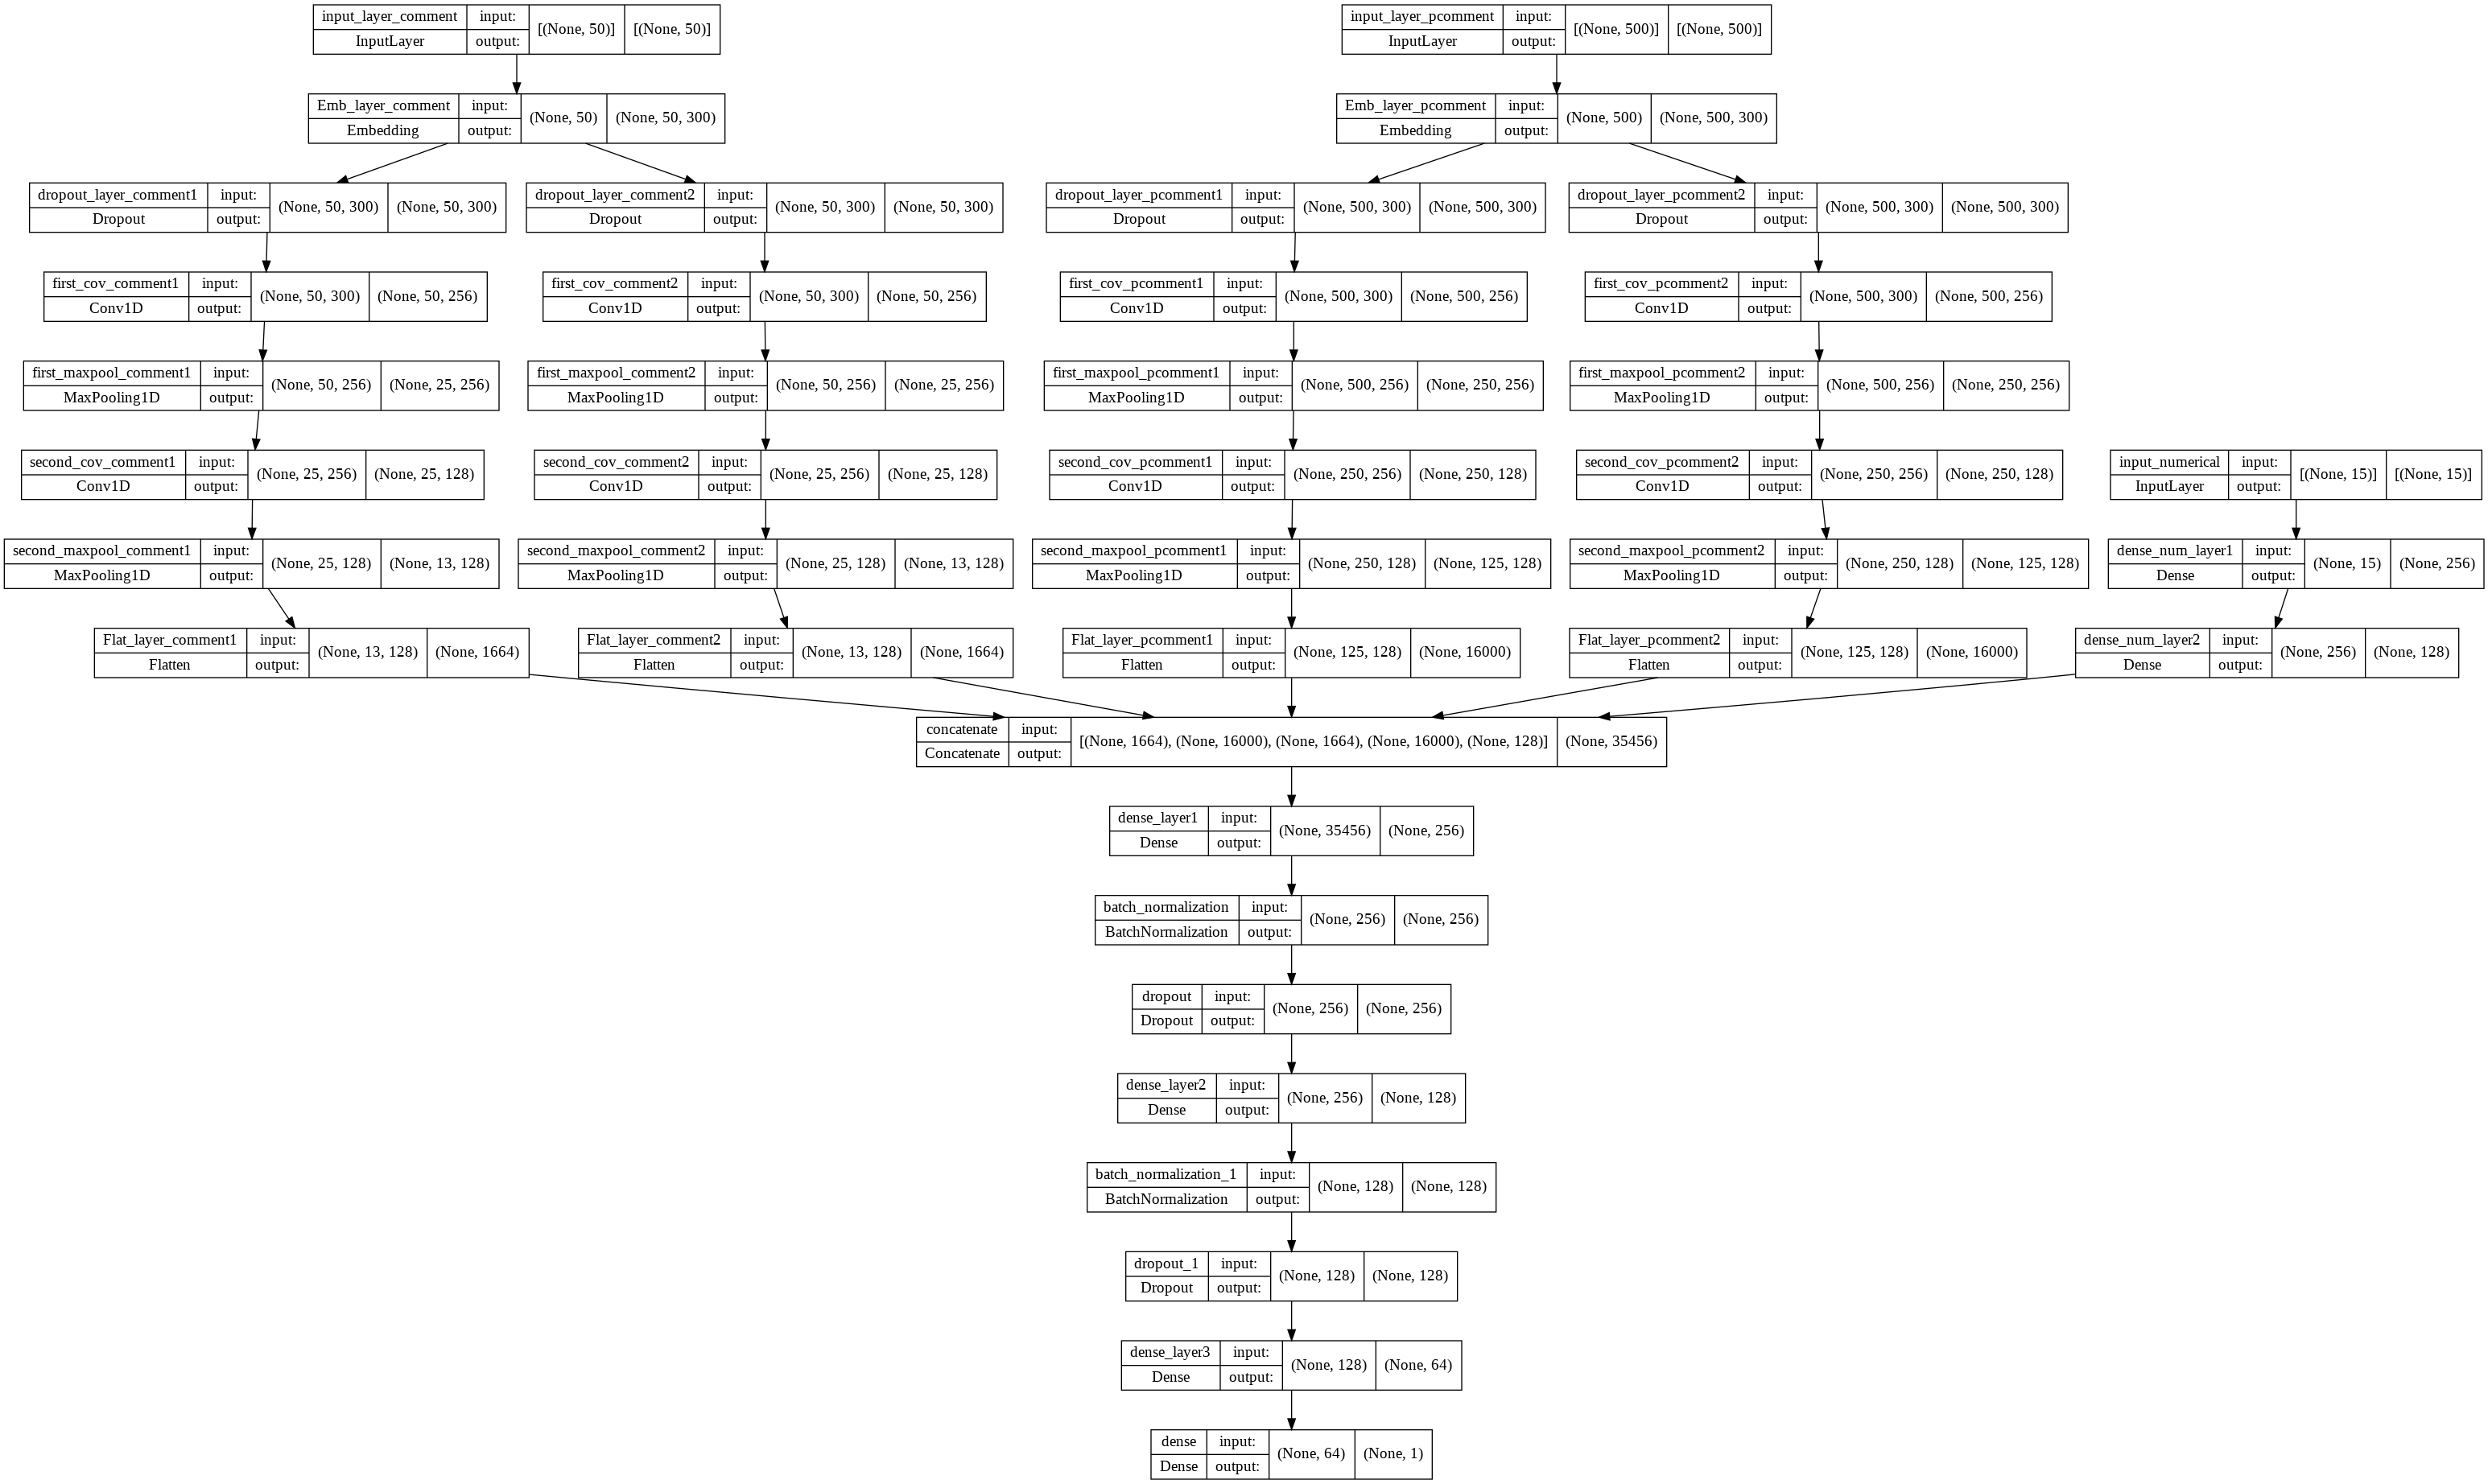

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
history = model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 686s 282ms/step - loss: 2.5626 - accuracy: 0.6704 - val_loss: 1.7542 - val_accuracy: 0.6141 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 693s 294ms/step - loss: 1.1818 - accuracy: 0.7187 - val_loss: 1.0585 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 693s 293ms/step - loss: 0.7795 - accuracy: 0.7348 - val_loss: 0.8432 - val_accuracy: 0.6535 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 691s 292ms/step - loss: 0.6476 - accuracy: 0.7442 - val_loss: 0.7630 - val_accuracy: 0.6606 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - ETA: 0s - loss: 0.5880 - accuracy: 0.7544
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
2361/2361 [==============================] - 656s 278ms/step - loss: 0.5880 - accuracy: 0.7544 - val_loss: 0.8031 - val_accuracy: 0.6482 - lr: 1.0000e-04
Epoch 6/50
2

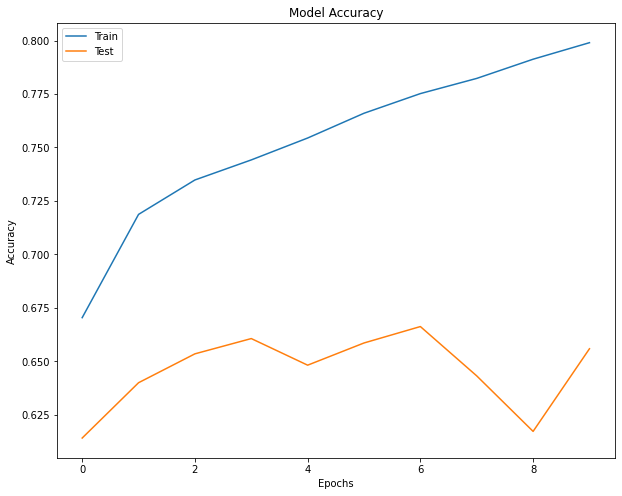

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

# 10. CNN 2 layers and 4 dense layers(embedding is fasttext and trainable=True)

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=81,trainable=True, name='Emb_layer_comment')(input_layer_comment)
dropout_layer_comment = Dropout(0.5, name='dropout_layer_comment')(embedding_layer_comment)

first_cov_comment = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_comment')(dropout_layer_comment)
first_maxpool_comment = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_comment')(first_cov_comment)
second_cov_comment = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_comment')(first_maxpool_comment)
second_maxpool_comment = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_comment')(second_cov_comment)
flat_layer_comment = Flatten(name='Flat_layer_comment')(second_maxpool_comment)


input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=574,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
dropout_layer_pcomment = Dropout(0.5, name='dropout_layer_pcomment')(embedding_layer_pcomment)

first_cov_pcomment = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_pcomment')(dropout_layer_pcomment)
first_maxpool_pcomment = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_pcomment')(first_cov_pcomment)
second_cov_pcomment = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_pcomment')(first_maxpool_pcomment)
second_maxpool_pcomment = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_pcomment')(second_cov_pcomment)
flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(second_maxpool_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(512, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer', kernel_regularizer=l2(0.001))(input_layer_num)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.3)(batch_norm_1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.2)(batch_norm_2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(drop_layer2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

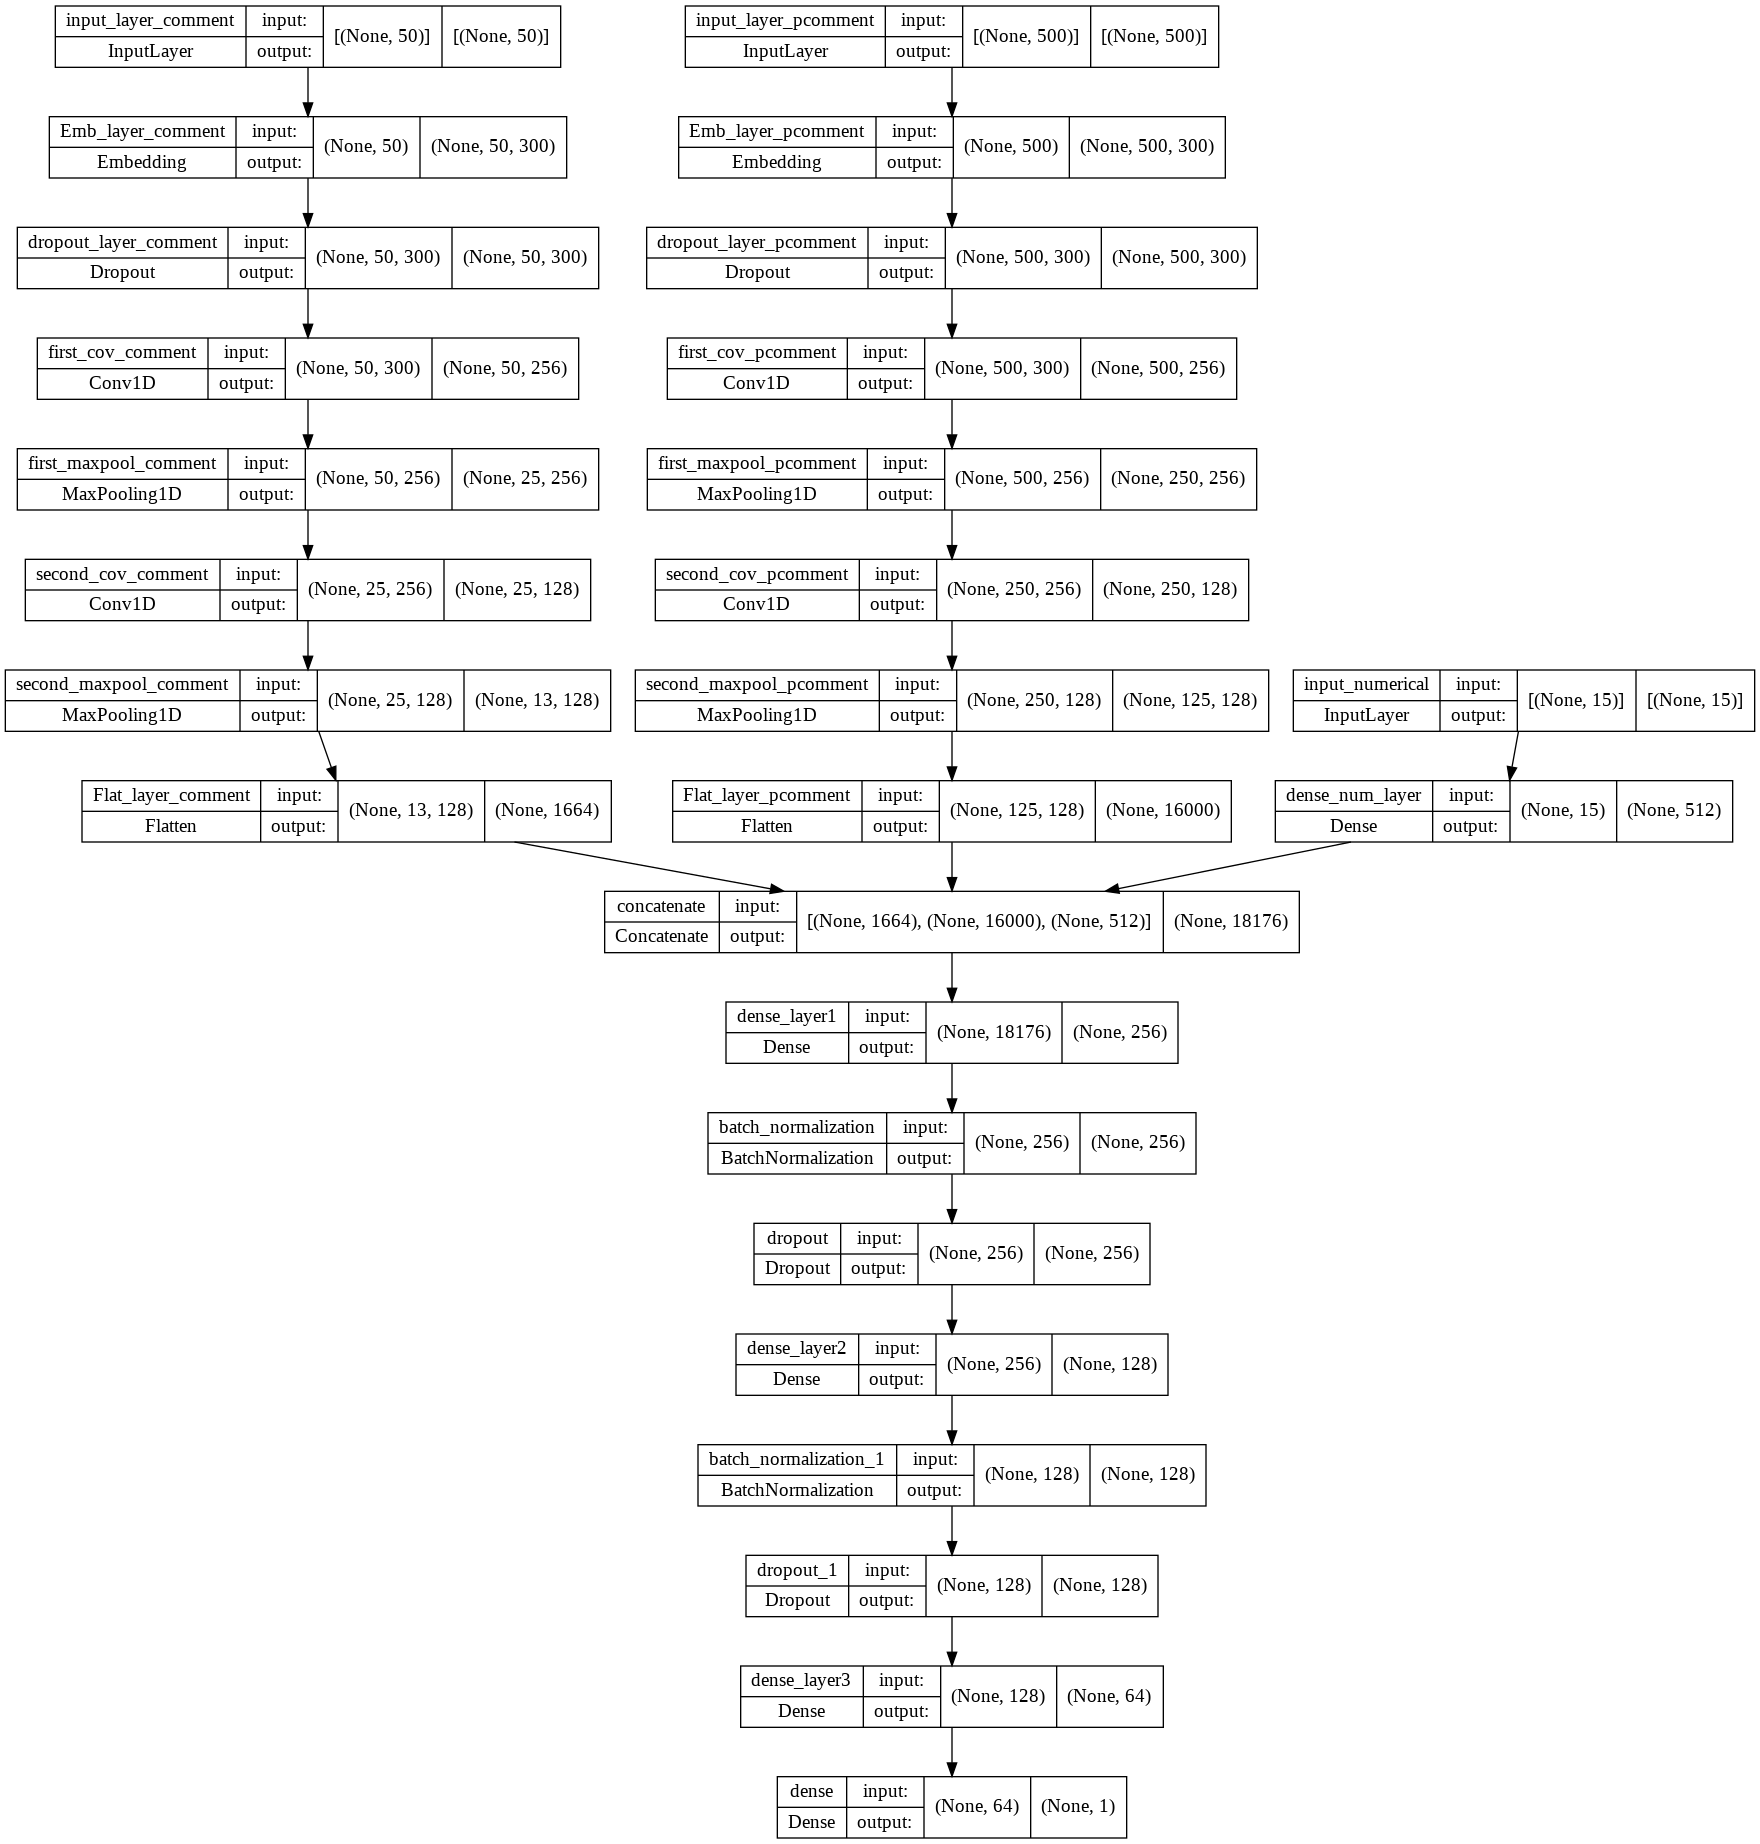

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
history = model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 430s 174ms/step - loss: 1.7093 - accuracy: 0.6674 - val_loss: 1.3783 - val_accuracy: 0.6163 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 408s 173ms/step - loss: 1.0128 - accuracy: 0.7118 - val_loss: 0.9587 - val_accuracy: 0.6471 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 407s 173ms/step - loss: 0.7298 - accuracy: 0.7250 - val_loss: 0.7942 - val_accuracy: 0.6481 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 406s 172ms/step - loss: 0.6129 - accuracy: 0.7361 - val_loss: 0.7256 - val_accuracy: 0.6534 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - 406s 172ms/step - loss: 0.5629 - accuracy: 0.7435 - val_loss: 0.7123 - val_accuracy: 0.6602 - lr: 1.0000e-04
Epoch 6/50
2361/2361 [==============================] - 406s 172ms/step - loss: 0.5362 - accuracy: 0.7495 - val_loss: 0.6710 - val_accuracy: 0.6679 - lr: 1.0000e-04
Epoch 7/50

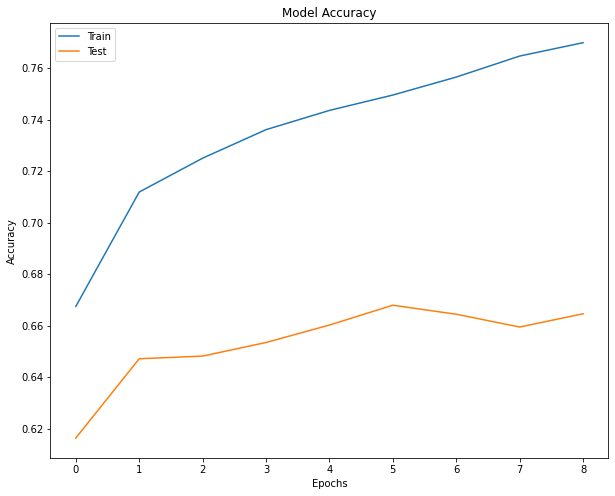

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

# 11. CNN 2 layers and 8 dense layers(embedding is fasttext and trainable=True)

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
dropout_layer_comment = Dropout(0.4, name='dropout_layer_comment')(embedding_layer_comment)

first_cov_comment = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_comment')(dropout_layer_comment)
first_maxpool_comment = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_comment')(first_cov_comment)
second_cov_comment = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_comment')(first_maxpool_comment)
second_maxpool_comment = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_comment')(second_cov_comment)
flat_layer_comment = Flatten(name='Flat_layer_comment')(second_maxpool_comment)


input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
dropout_layer_pcomment = Dropout(0.4, name='dropout_layer_pcomment')(embedding_layer_pcomment)

first_cov_pcomment = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_pcomment')(dropout_layer_pcomment)
first_maxpool_pcomment = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_pcomment')(first_cov_pcomment)
second_cov_pcomment = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_pcomment')(first_maxpool_pcomment)
second_maxpool_pcomment = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_pcomment')(second_cov_pcomment)
flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(second_maxpool_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer1 = Dense(512, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.0001))(input_layer_num)
batch_num_1 = BatchNormalization()(dense_num_layer1)
drop_num_1 = Dropout(0.3)(batch_num_1)
dense_num_layer2 = Dense(256, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.0001))(drop_num_1)
batch_num_2 = BatchNormalization()(dense_num_layer2)
drop_num_2 = Dropout(0.3)(batch_num_2)
dense_num_layer3 = Dense(128, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer3', kernel_regularizer=l2(0.0001))(drop_num_2)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer3])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.3)(batch_norm_1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.2)(batch_norm_2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(drop_layer2)
batch_norm_3 = BatchNormalization()(dense_layer3)
drop_layer3 = Dropout(0.2)(batch_norm_3)
dense_layer4 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer4', kernel_regularizer=l2(0.001))(drop_layer3)
batch_norm_4 = BatchNormalization()(dense_layer4)
drop_layer4 = Dropout(0.2)(batch_norm_4)
dense_layer5 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer5', kernel_regularizer=l2(0.001))(drop_layer4)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_numerical (InputLayer)   [(None, 15)]         0           []                               
                                                                                              

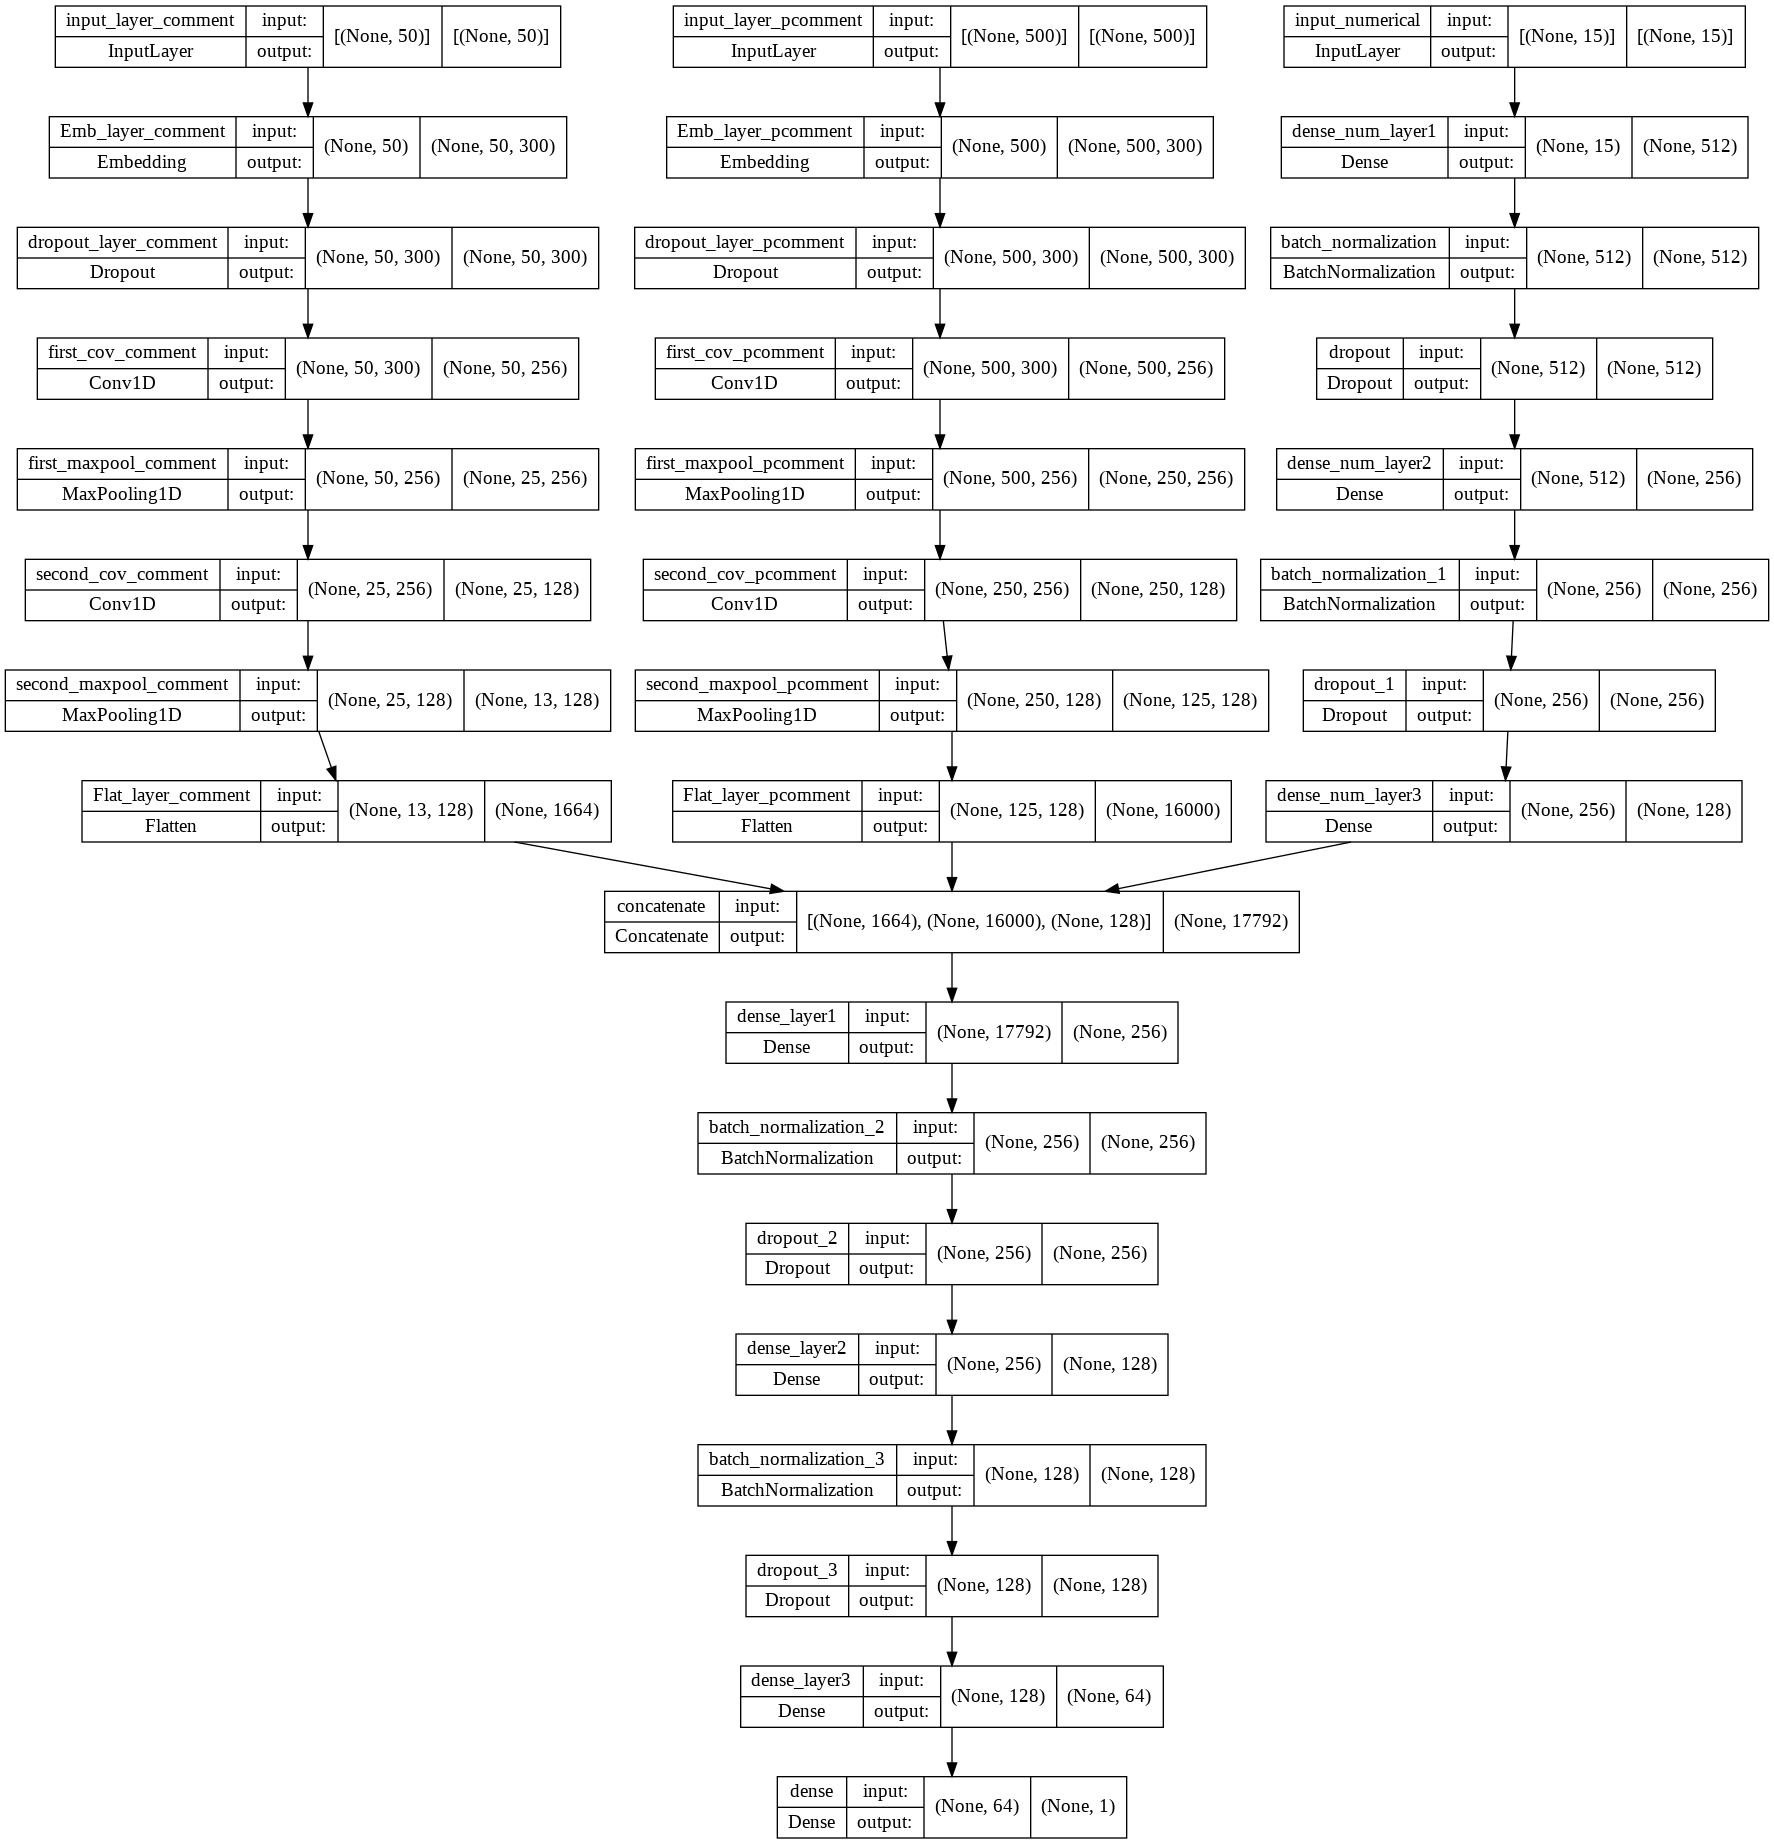

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
history = model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 415s 174ms/step - loss: 1.2143 - accuracy: 0.6571 - val_loss: 1.1091 - val_accuracy: 0.6340 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 410s 173ms/step - loss: 0.8997 - accuracy: 0.7138 - val_loss: 0.9597 - val_accuracy: 0.6519 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 410s 173ms/step - loss: 0.7575 - accuracy: 0.7311 - val_loss: 0.8689 - val_accuracy: 0.6591 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 409s 173ms/step - loss: 0.6711 - accuracy: 0.7428 - val_loss: 0.8309 - val_accuracy: 0.6608 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - 413s 175ms/step - loss: 0.6129 - accuracy: 0.7529 - val_loss: 0.7907 - val_accuracy: 0.6631 - lr: 1.0000e-04
Epoch 6/50
2361/2361 [==============================] - ETA: 0s - loss: 0.5713 - accuracy: 0.7628
Epoch 6: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
2

# 12. Bidirectional LSTM 1 layer and 5 dense layers (embedding is fasttext and trainable=True)

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
lstm_layer_comment = Bidirectional(LSTM(100, dropout= 0.25, return_sequences=True, name= 'lstm_layer_comment'))(embedding_layer_comment)

flat_layer_comment = Flatten(name='Flat_layer_comment')(lstm_layer_comment)

input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
lstm_layer_pcomment = Bidirectional(LSTM(100, dropout= 0.25, return_sequences=True, name= 'lstm_layer_pcomment'))(embedding_layer_pcomment)

flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(lstm_layer_pcomment)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(64, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.0001))(input_layer_num)
dense_num_layer = Dense(32, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.0001))(dense_num_layer)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(batch_norm_2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 2,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

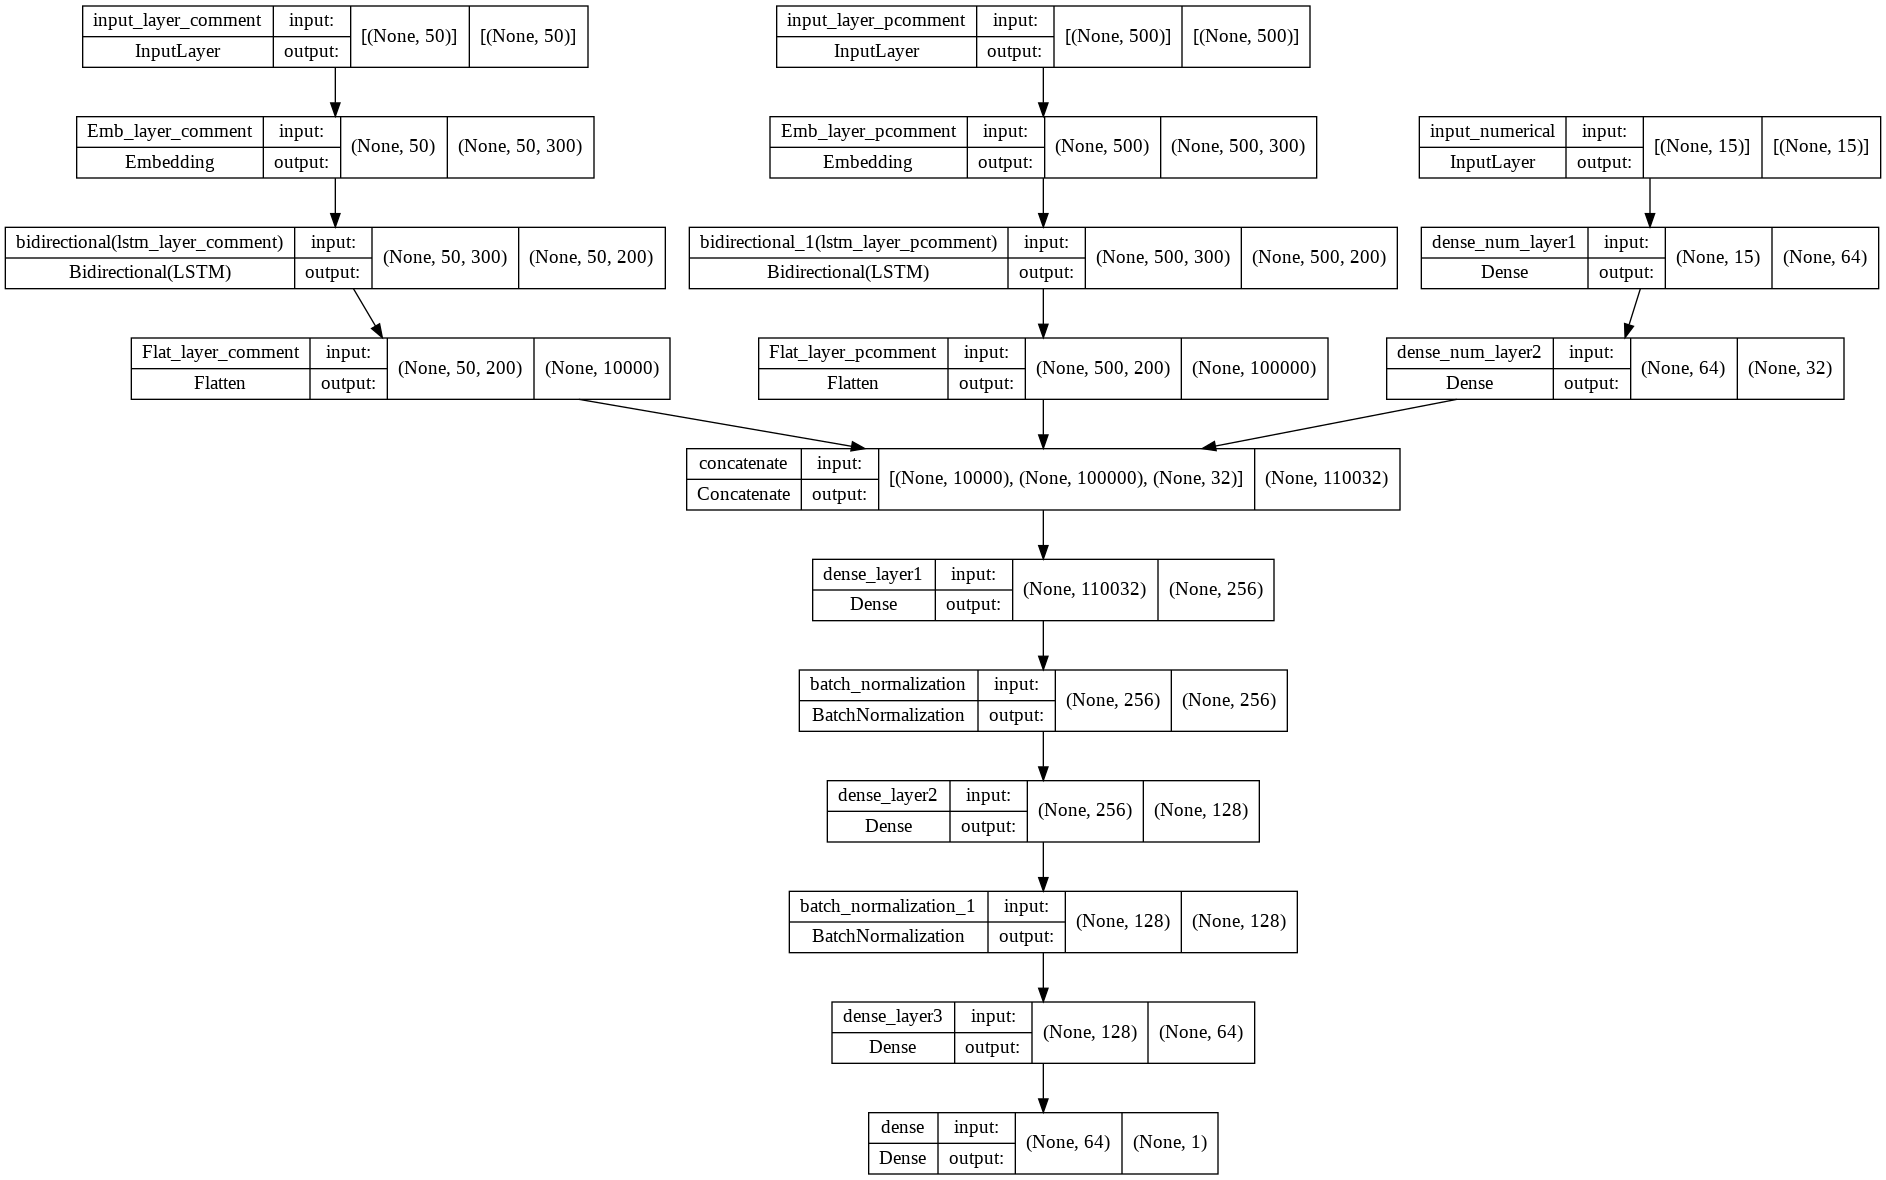

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
history = model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 682s 281ms/step - loss: 0.9831 - accuracy: 0.6932 - val_loss: 0.9116 - val_accuracy: 0.6451 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 667s 282ms/step - loss: 0.7211 - accuracy: 0.7349 - val_loss: 0.8138 - val_accuracy: 0.6485 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 665s 282ms/step - loss: 0.6324 - accuracy: 0.7518 - val_loss: 0.7664 - val_accuracy: 0.6581 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 663s 281ms/step - loss: 0.5832 - accuracy: 0.7664 - val_loss: 0.7538 - val_accuracy: 0.6676 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.7802
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
2361/2361 [==============================] - 669s 283ms/step - loss: 0.5474 - accuracy: 0.7802 - val_loss: 0.7539 - val_accuracy: 0.6583 - lr: 1.0000e-04
Epoch 6/50
2

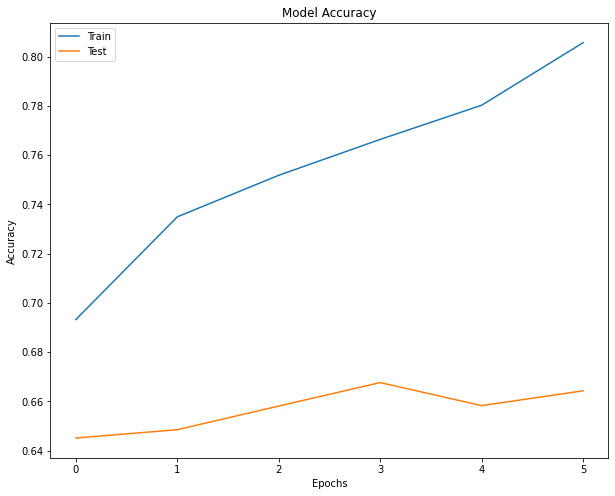

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

# 13. Bidirectional LSTM 2 layers and 5 dense layers (embedding is fasttext and trainable=True)

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
lstm_layer_comment1 = Bidirectional(LSTM(64, dropout= 0.35, return_sequences=True, name= 'lstm_layer_comment1'))(embedding_layer_comment)
lstm_layer_comment2 = Bidirectional(LSTM(64, dropout= 0.35, return_sequences=True, name= 'lstm_layer_comment2'))(lstm_layer_comment1)

flat_layer_comment = Flatten(name='Flat_layer_comment')(lstm_layer_comment2)

input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
lstm_layer_pcomment1 = Bidirectional(LSTM(64, dropout= 0.35, return_sequences=True, name= 'lstm_layer_pcomment1'))(embedding_layer_pcomment)
lstm_layer_pcomment2 = Bidirectional(LSTM(64, dropout= 0.35, return_sequences=True, name= 'lstm_layer_pcomment2'))(lstm_layer_pcomment1)

flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(lstm_layer_pcomment2)


input_layer_num = Input(shape=(15,), name = "input_numerical")
dense_num_layer = Dense(64, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer1', kernel_regularizer=l2(0.001))(input_layer_num)
dense_num_layer = Dense(32, activation = "relu", kernel_initializer='he_normal', name='dense_num_layer2', kernel_regularizer=l2(0.001))(dense_num_layer)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,dense_num_layer])

dense_layer1 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.001))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.3)(batch_norm_1)
dense_layer2 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.001))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.2)(batch_norm_2)
dense_layer3 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.001))(drop_layer2)

output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 2,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, input_layer_num], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

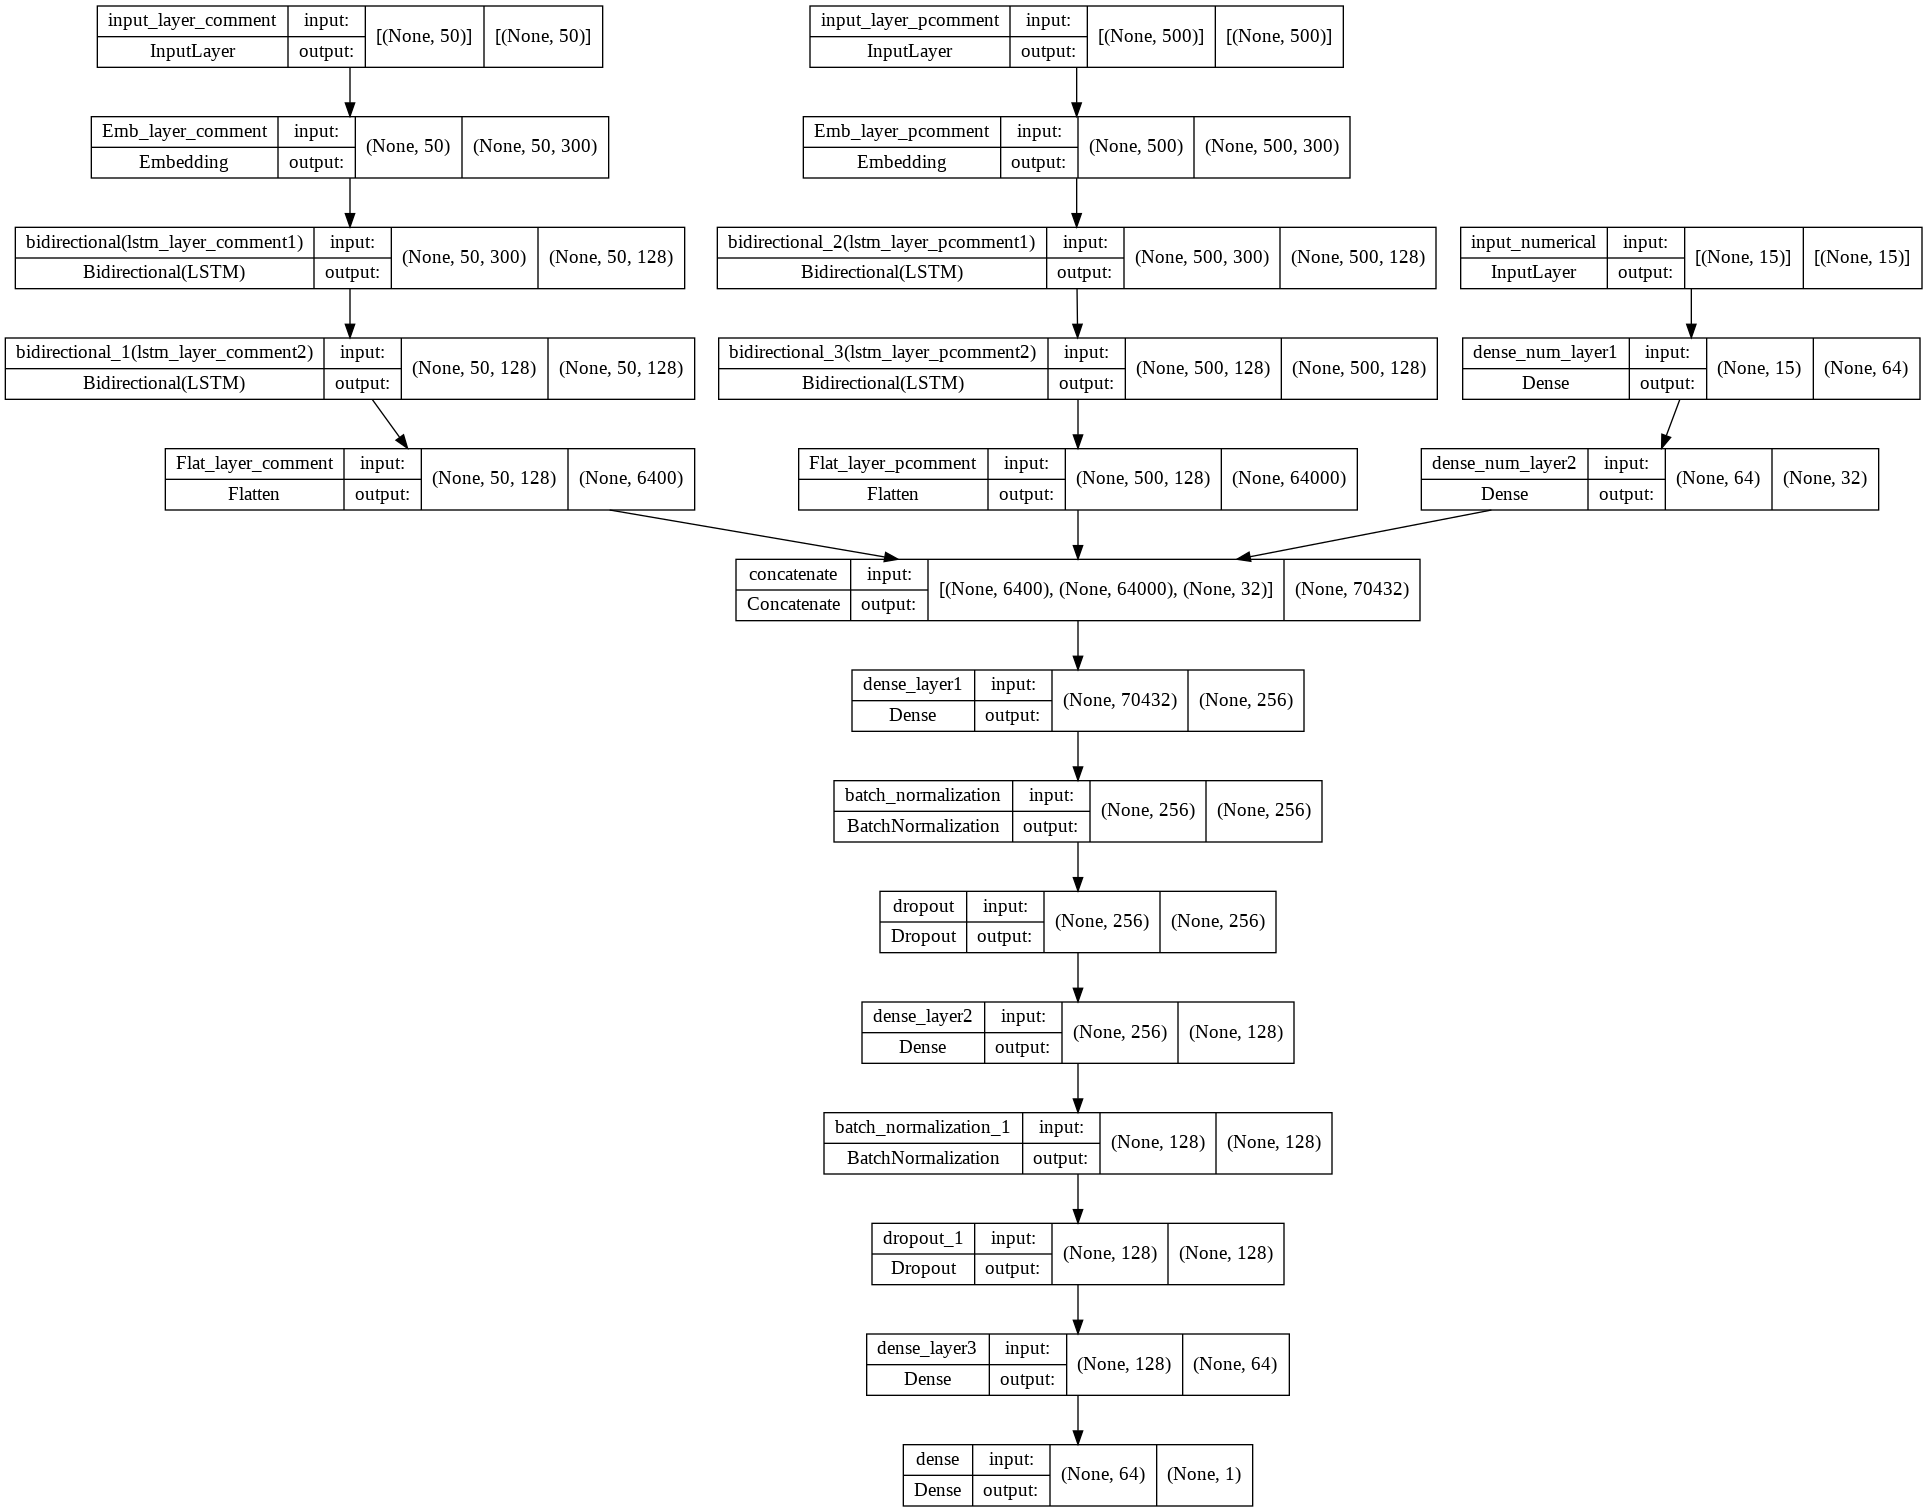

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
history = model.fit([x_train_padding_comment, x_train_padding_pcomment, x_train_num], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, x_cv_num], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 723s 301ms/step - loss: 1.1854 - accuracy: 0.6687 - val_loss: 1.0116 - val_accuracy: 0.6467 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - ETA: 0s - loss: 0.8211 - accuracy: 0.7164
Epoch 2: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
2361/2361 [==============================] - 711s 301ms/step - loss: 0.8211 - accuracy: 0.7164 - val_loss: 0.8768 - val_accuracy: 0.6338 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 684s 290ms/step - loss: 0.7072 - accuracy: 0.7333 - val_loss: 0.8151 - val_accuracy: 0.6479 - lr: 2.5000e-05
Epoch 4/50
2361/2361 [==============================] - 708s 300ms/step - loss: 0.6693 - accuracy: 0.7376 - val_loss: 0.7976 - val_accuracy: 0.6497 - lr: 2.5000e-05
Epoch 5/50
2361/2361 [==============================] - 712s 302ms/step - loss: 0.6410 - accuracy: 0.7426 - val_loss: 0.7718 - val_accuracy: 0.6582 - lr: 2.5000e-05
Epoch 6/50
2

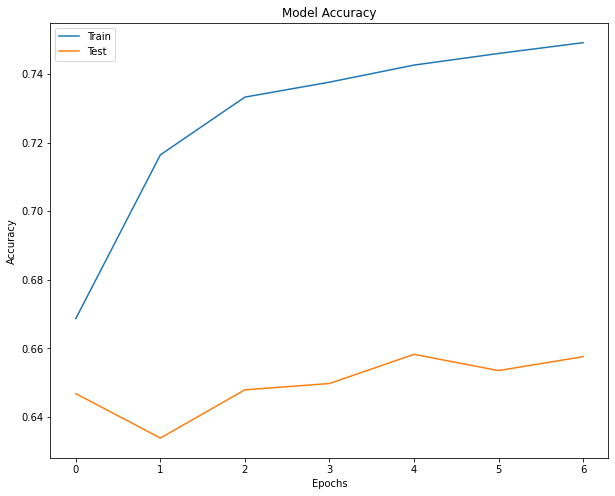

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

# 14. LSTM 1 layer on text data, CNN 1 layer on other feature(embedding is fasttext and trainable=True) 

In [ ]:
train_data = x_train_num[:,:,np.newaxis]
cv_data = x_cv_num[:,:,np.newaxis]

print(train_data.shape)
print(cv_data.shape)

(604320, 15, 1)
(201440, 15, 1)


In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
lstm_layer_comment = LSTM(100, dropout=0.4, return_sequences=True, name= 'lstm_layer_comment')(embedding_layer_comment)

flat_layer_comment = Flatten(name='Flat_layer_comment')(lstm_layer_comment)

input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
lstm_layer_pcomment = LSTM(100, dropout=0.4, return_sequences=True, name= 'lstm_layer_pcomment')(embedding_layer_pcomment)

flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(lstm_layer_pcomment)


otherthan_text_input = Input(shape=(15,1,), name='Otherthan_text_input')
conv_layer_1 = Conv1D(256, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_1', kernel_regularizer=l2(0.01))(otherthan_text_input)
max_pool_1 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_1')(conv_layer_1)
conv_layer_2 = Conv1D(128, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_2', kernel_regularizer=l2(0.01))(max_pool_1)
conv_layer_3 = Conv1D(64, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_3', kernel_regularizer=l2(0.01))(conv_layer_2)
max_pool_2 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_2')(conv_layer_3)
conv_layer_4 = Conv1D(32, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_4', kernel_regularizer=l2(0.01))(max_pool_2)

flattened_layer_2 = Flatten(name= 'flattened_layer_2')(conv_layer_4)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,flattened_layer_2])

dense_layer1 = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.01))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.6)(batch_norm_1)
dense_layer2 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.01))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.3)(batch_norm_2)
dense_layer3 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.01))(drop_layer2)


output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, otherthan_text_input], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Otherthan_text_input (InputLay  [(None, 15, 1)]     0           []                               
 er)                                                                                              
                                                                                                  
 conv_layer_1 (Conv1D)          (None, 15, 256)      1024        ['Otherthan_text_input[0][0]']   
                                                                                                  
 max_pool_1 (MaxPooling1D)      (None, 8, 256)       0           ['conv_layer_1[0][0]']           
                                                                                                  
 conv_layer_2 (Conv1D)          (None, 8, 128)       98432       ['max_pool_1[0][0]']         

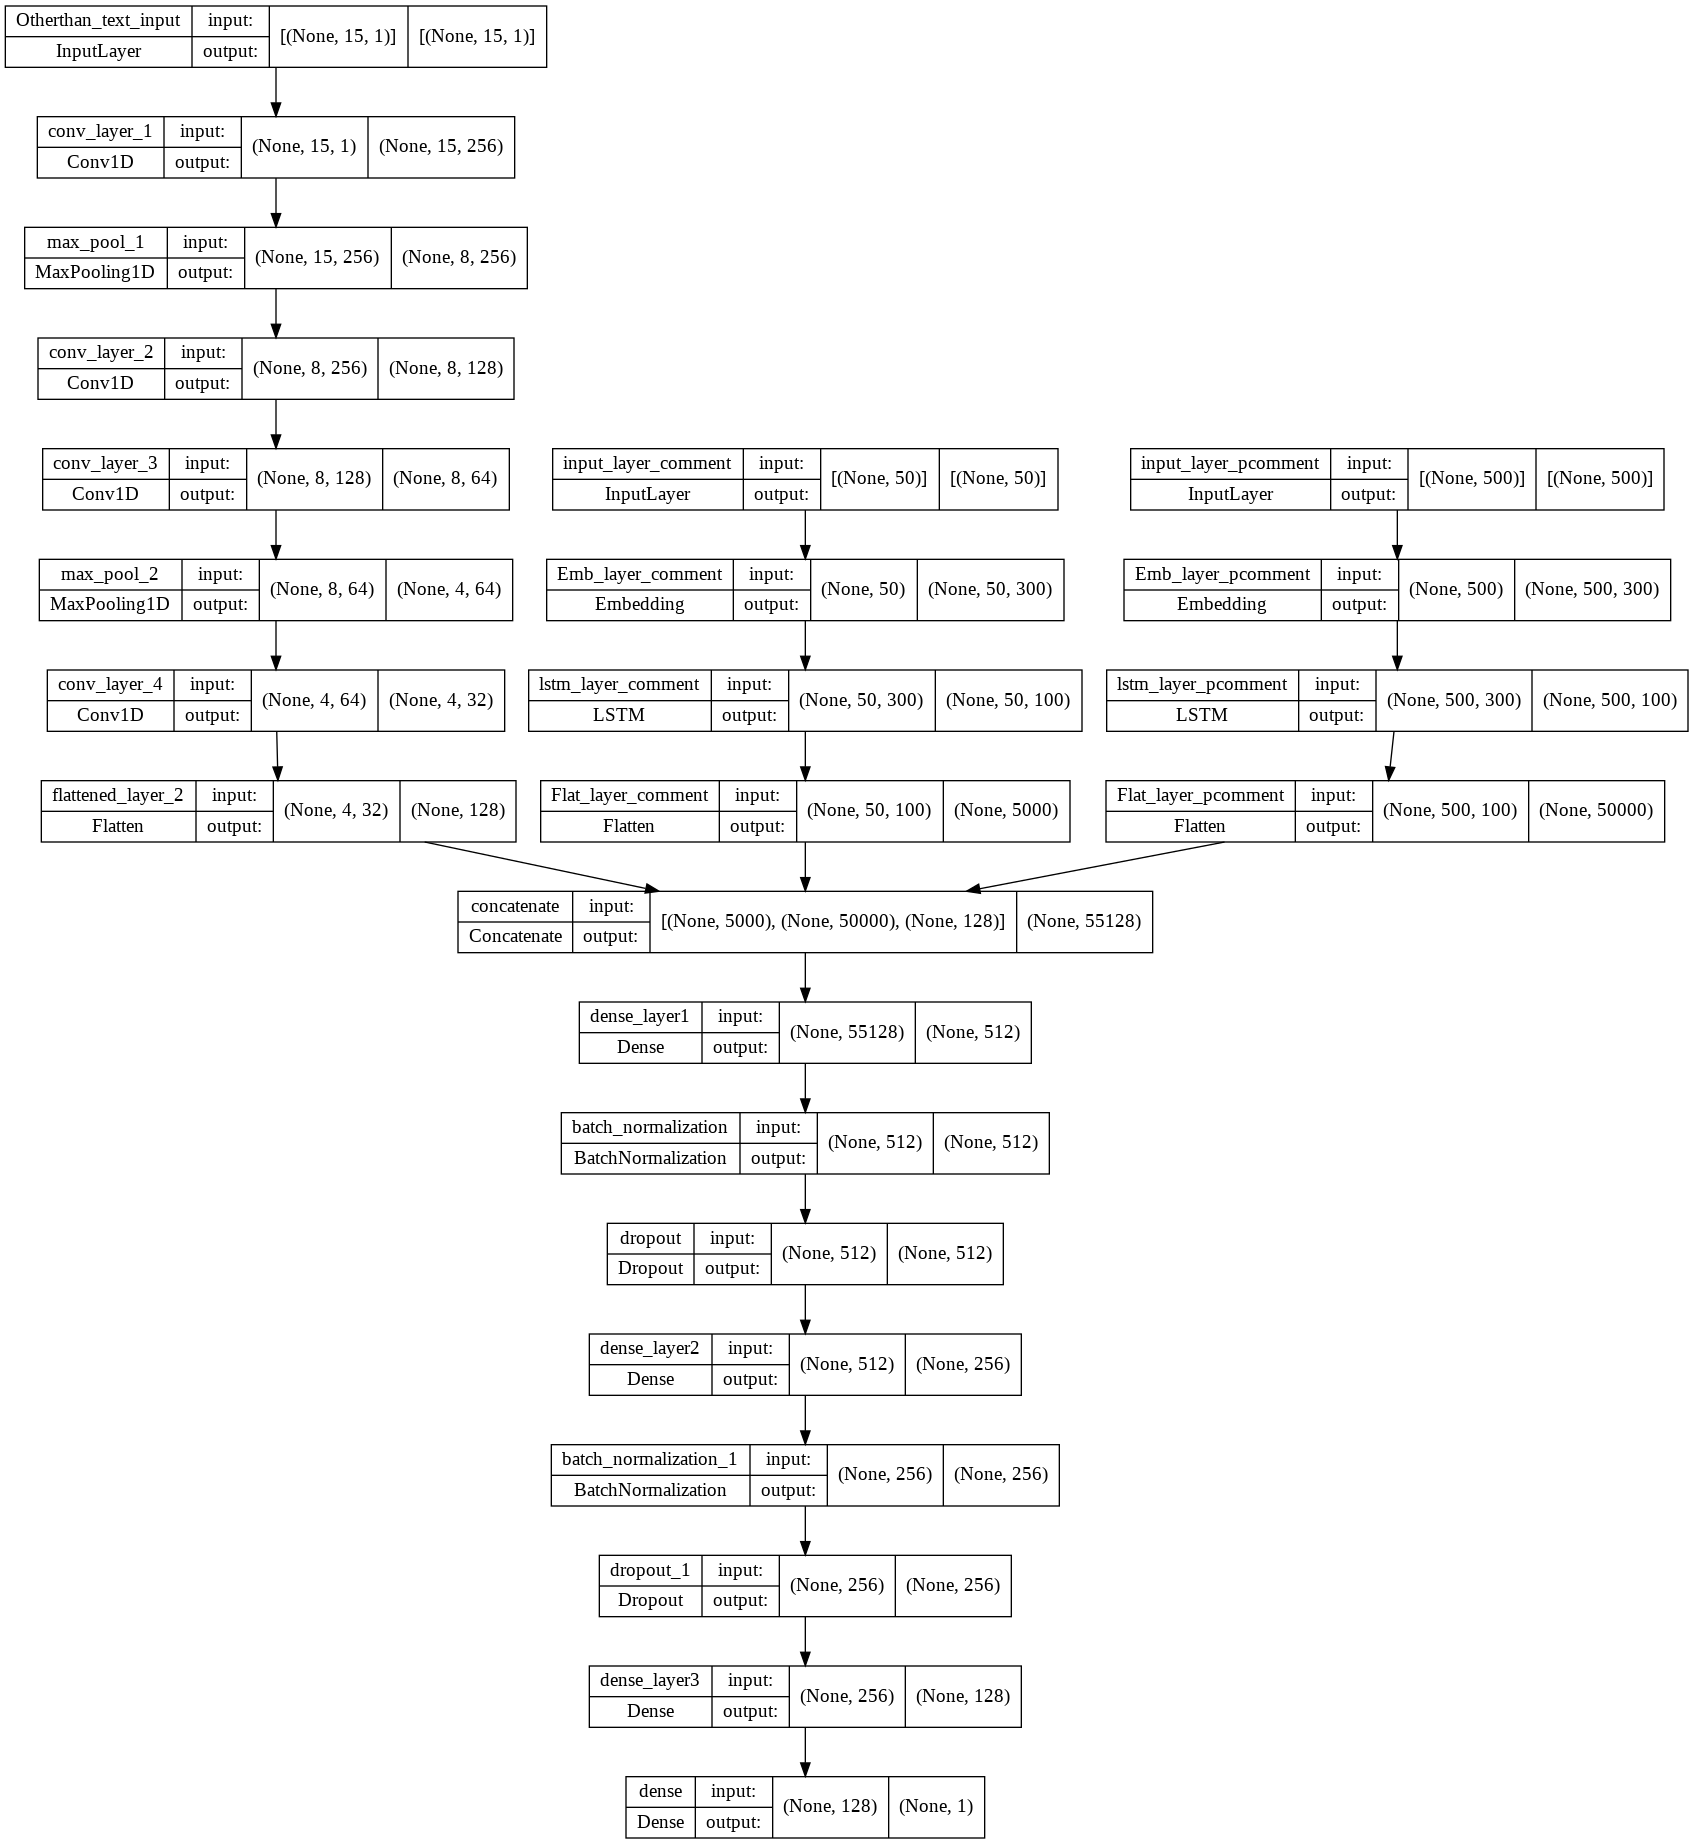

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
history = model.fit([x_train_padding_comment, x_train_padding_pcomment, train_data], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, cv_data], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 412s 167ms/step - loss: 3.8877 - accuracy: 0.6426 - val_loss: 0.8953 - val_accuracy: 0.6909 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 415s 176ms/step - loss: 0.6863 - accuracy: 0.6924 - val_loss: 0.6029 - val_accuracy: 0.7072 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 408s 173ms/step - loss: 0.5948 - accuracy: 0.7068 - val_loss: 0.5812 - val_accuracy: 0.7119 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 408s 173ms/step - loss: 0.5786 - accuracy: 0.7181 - val_loss: 0.5790 - val_accuracy: 0.7159 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - ETA: 0s - loss: 0.5656 - accuracy: 0.7275
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
2361/2361 [==============================] - 408s 173ms/step - loss: 0.5656 - accuracy: 0.7275 - val_loss: 0.5762 - val_accuracy: 0.7158 - lr: 1.0000e-04
Epoch 6/50
2

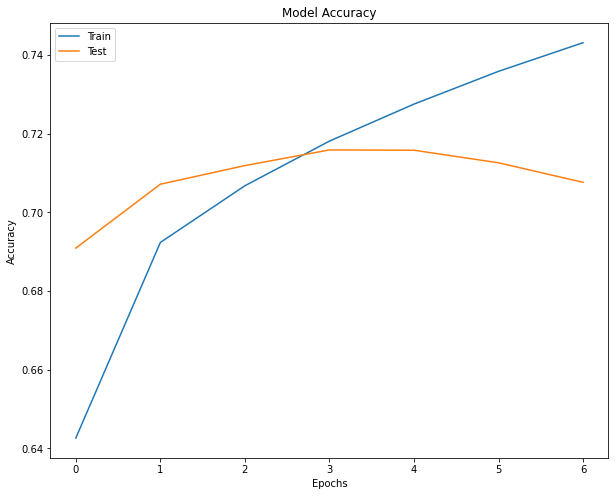

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

# 15. CNN on text data and CNN on other feature(embedding is fasttext and trainable=True)

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
dropout_layer_comment = Dropout(0.4, name='dropout_layer_comment')(embedding_layer_comment)

first_cov_comment = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_comment', kernel_initializer=glorot_uniform())(dropout_layer_comment)
first_maxpool_comment = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_comment')(first_cov_comment)
second_cov_comment = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_comment', kernel_initializer=glorot_uniform())(first_maxpool_comment)
second_maxpool_comment = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_comment')(second_cov_comment)
flat_layer_comment = Flatten(name='Flat_layer_comment')(second_maxpool_comment)


input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
dropout_layer_pcomment = Dropout(0.4, name='dropout_layer_pcomment')(embedding_layer_pcomment)

first_cov_pcomment = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_pcomment', kernel_initializer=glorot_uniform())(dropout_layer_pcomment)
first_maxpool_pcomment = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_pcomment')(first_cov_pcomment)
second_cov_pcomment = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_pcomment', kernel_initializer=glorot_uniform())(first_maxpool_pcomment)
second_maxpool_pcomment = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_pcomment')(second_cov_pcomment)
flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(second_maxpool_pcomment)


otherthan_text_input = Input(shape=(15,1,), name='Otherthan_text_input')
conv_layer_1 = Conv1D(256, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_1', kernel_regularizer=l2(0.01))(otherthan_text_input)
max_pool_1 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_1')(conv_layer_1)
conv_layer_2 = Conv1D(128, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_2', kernel_regularizer=l2(0.01))(max_pool_1)
conv_layer_3 = Conv1D(64, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_3', kernel_regularizer=l2(0.01))(conv_layer_2)
max_pool_2 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_2')(conv_layer_3)
conv_layer_4 = Conv1D(32, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_4', kernel_regularizer=l2(0.01))(max_pool_2)

flattened_layer_2 = Flatten(name= 'flattened_layer_2')(conv_layer_4)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,flattened_layer_2])

dense_layer1 = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.01))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.6)(batch_norm_1)
dense_layer2 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.01))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.3)(batch_norm_2)
dense_layer3 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.01))(drop_layer2)


output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, otherthan_text_input], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Otherthan_text_input (InputLay  [(None, 15, 1)]     0           []                               
 er)                                                                                          

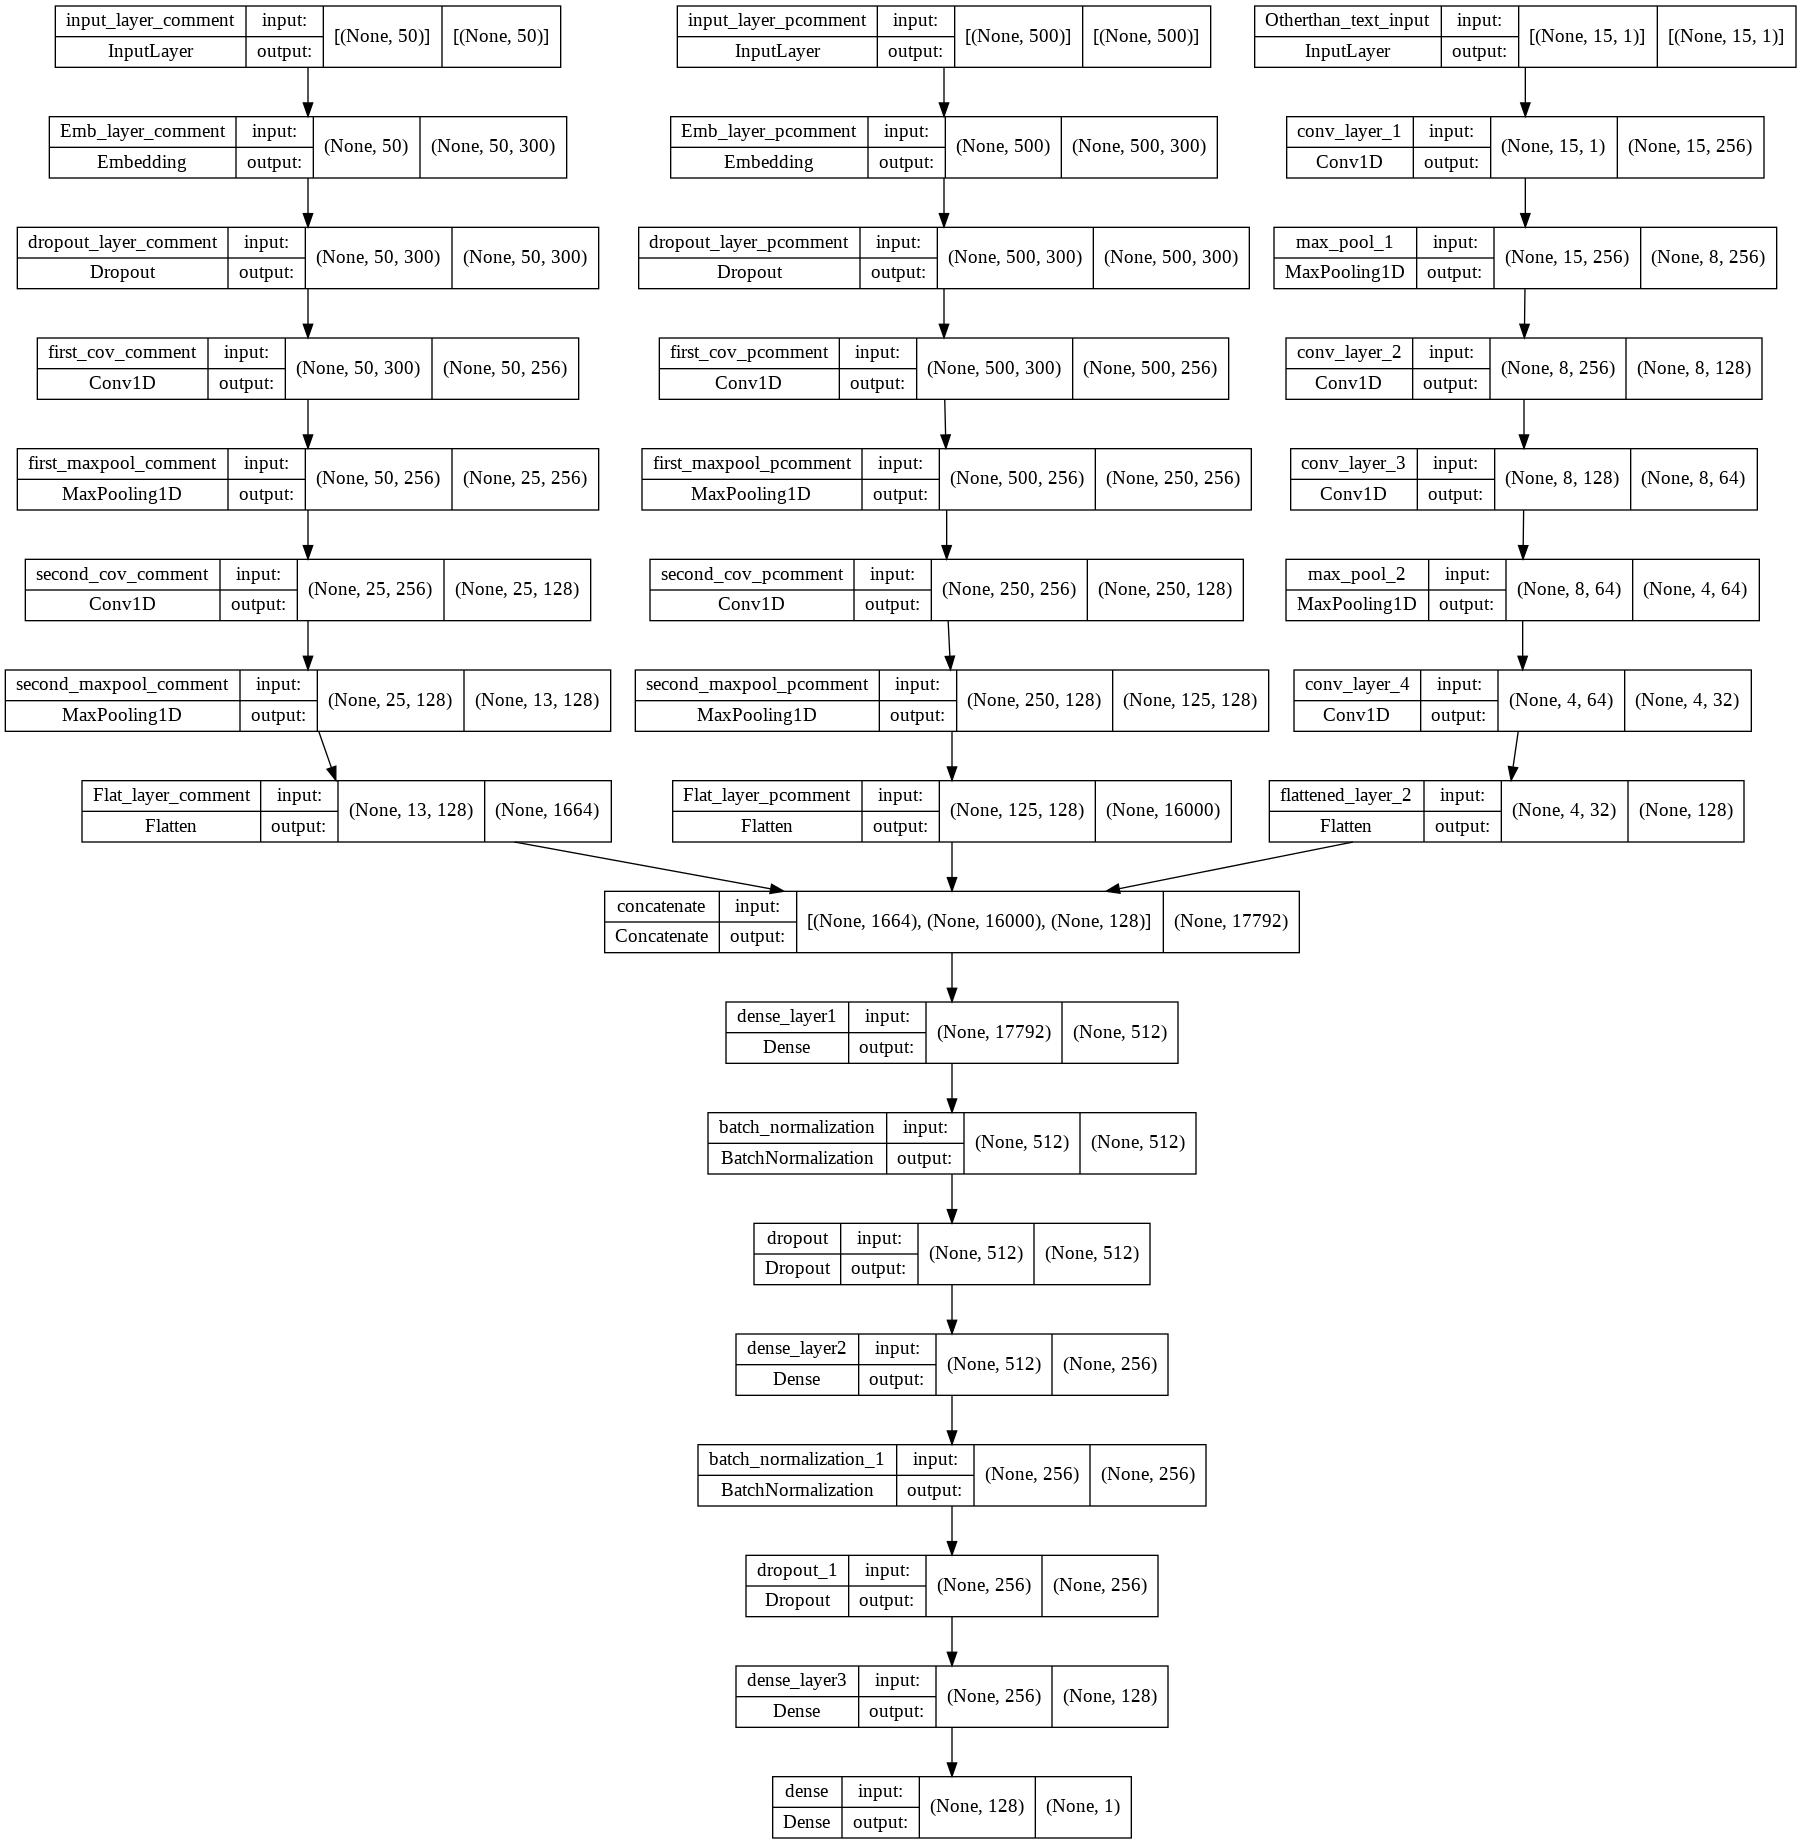

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
history = model.fit([x_train_padding_comment, x_train_padding_pcomment, train_data], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, cv_data], y_cv), 
           batch_size=256, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
2361/2361 [==============================] - 419s 171ms/step - loss: 4.0135 - accuracy: 0.6289 - val_loss: 0.9288 - val_accuracy: 0.6711 - lr: 1.0000e-04
Epoch 2/50
2361/2361 [==============================] - 422s 179ms/step - loss: 0.6830 - accuracy: 0.6936 - val_loss: 0.5860 - val_accuracy: 0.7058 - lr: 1.0000e-04
Epoch 3/50
2361/2361 [==============================] - 419s 177ms/step - loss: 0.5745 - accuracy: 0.7102 - val_loss: 0.5659 - val_accuracy: 0.7135 - lr: 1.0000e-04
Epoch 4/50
2361/2361 [==============================] - 419s 178ms/step - loss: 0.5573 - accuracy: 0.7219 - val_loss: 0.5628 - val_accuracy: 0.7178 - lr: 1.0000e-04
Epoch 5/50
2361/2361 [==============================] - 419s 177ms/step - loss: 0.5437 - accuracy: 0.7321 - val_loss: 0.5604 - val_accuracy: 0.7205 - lr: 1.0000e-04
Epoch 6/50
2361/2361 [==============================] - ETA: 0s - loss: 0.5309 - accuracy: 0.7422
Epoch 6: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
2

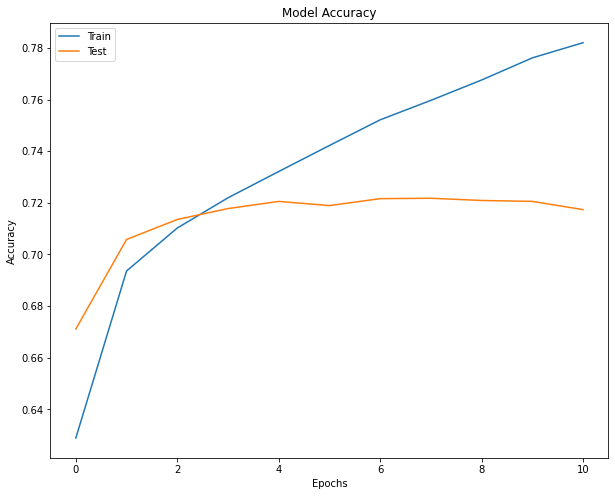

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

# 16. CNN2D on text features and CNN2D on other features(Embedding is fasttext and trainable is True)

In [ ]:
train_data = x_train_num[:,:,np.newaxis,np.newaxis]
cv_data = x_cv_num[:,:,np.newaxis,np.newaxis]

print(train_data.shape)
print(cv_data.shape)

(604320, 15, 1, 1)
(201440, 15, 1, 1)


In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
emb_comment = Reshape((50, 30, 10), input_shape=(50,300))(embedding_layer_comment)
dropout_layer_comment = Dropout(0.3, name='dropout_layer_comment')(emb_comment)

first_cov_comment = Conv2D(64, 3, activation='relu',padding="same", name='first_cov_comment', kernel_initializer=glorot_uniform())(dropout_layer_comment)
first_maxpool_comment = MaxPooling2D(pool_size=2, padding='same', name='first_maxpool_comment')(first_cov_comment)
second_cov_comment = Conv2D(32, 3, activation='relu',padding="same", name='second_cov_comment', kernel_initializer=glorot_uniform())(first_maxpool_comment)
second_maxpool_comment = MaxPooling2D(pool_size=2, padding='same', name='second_maxpool_comment')(second_cov_comment)
flat_layer_comment = Flatten(name='Flat_layer_comment')(second_maxpool_comment)


input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
emb_pcomment = Reshape((500, 30, 10), input_shape=(500,300))(embedding_layer_pcomment)
dropout_layer_pcomment = Dropout(0.3, name='dropout_layer_pcomment')(emb_pcomment)

first_cov_pcomment = Conv2D(64, 3, activation='relu',padding="same", name='first_cov_pcomment', kernel_initializer=glorot_uniform())(dropout_layer_pcomment)
first_maxpool_pcomment = MaxPooling2D(pool_size=2, padding='same', name='first_maxpool_pcomment')(first_cov_pcomment)
second_cov_pcomment = Conv2D(32, 3, activation='relu',padding="same", name='second_cov_pcomment', kernel_initializer=glorot_uniform())(first_maxpool_pcomment)
second_maxpool_pcomment = MaxPooling2D(pool_size=2, padding='same', name='second_maxpool_pcomment')(second_cov_pcomment)
flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(second_maxpool_pcomment)


otherthan_text_input = Input(shape=(15,1,1,), name='Otherthan_text_input')
conv_layer_1 = Conv2D(256, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_1', kernel_regularizer=l2(0.01))(otherthan_text_input)
max_pool_1 = MaxPooling2D(pool_size=2, padding='same', name='max_pool_1')(conv_layer_1)
conv_layer_2 = Conv2D(128, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_2', kernel_regularizer=l2(0.01))(max_pool_1)
conv_layer_3 = Conv2D(64, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_3', kernel_regularizer=l2(0.01))(conv_layer_2)
max_pool_2 = MaxPooling2D(pool_size=2, padding='same', name='max_pool_2')(conv_layer_3)
conv_layer_4 = Conv2D(32, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_4', kernel_regularizer=l2(0.01))(max_pool_2)

flattened_layer_2 = Flatten(name= 'flattened_layer_2')(conv_layer_4)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,flattened_layer_2])

dense_layer1 = Dense(512, activation='relu', kernel_initializer=glorot_uniform(), name='dense_layer1', kernel_regularizer=l2(0.01))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.6)(batch_norm_1)
dense_layer2 = Dense(256, activation='relu', kernel_initializer=glorot_uniform(), name='dense_layer2', kernel_regularizer=l2(0.01))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.3)(batch_norm_2)
dense_layer3 = Dense(128, activation='relu', kernel_initializer=glorot_uniform(), name='dense_layer3', kernel_regularizer=l2(0.01))(drop_layer2)


output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, otherthan_text_input], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Emb_layer_comment (Embedding)  (None, 50, 300)      37858200    ['input_layer_comment[0][0]']    
                                                                                              

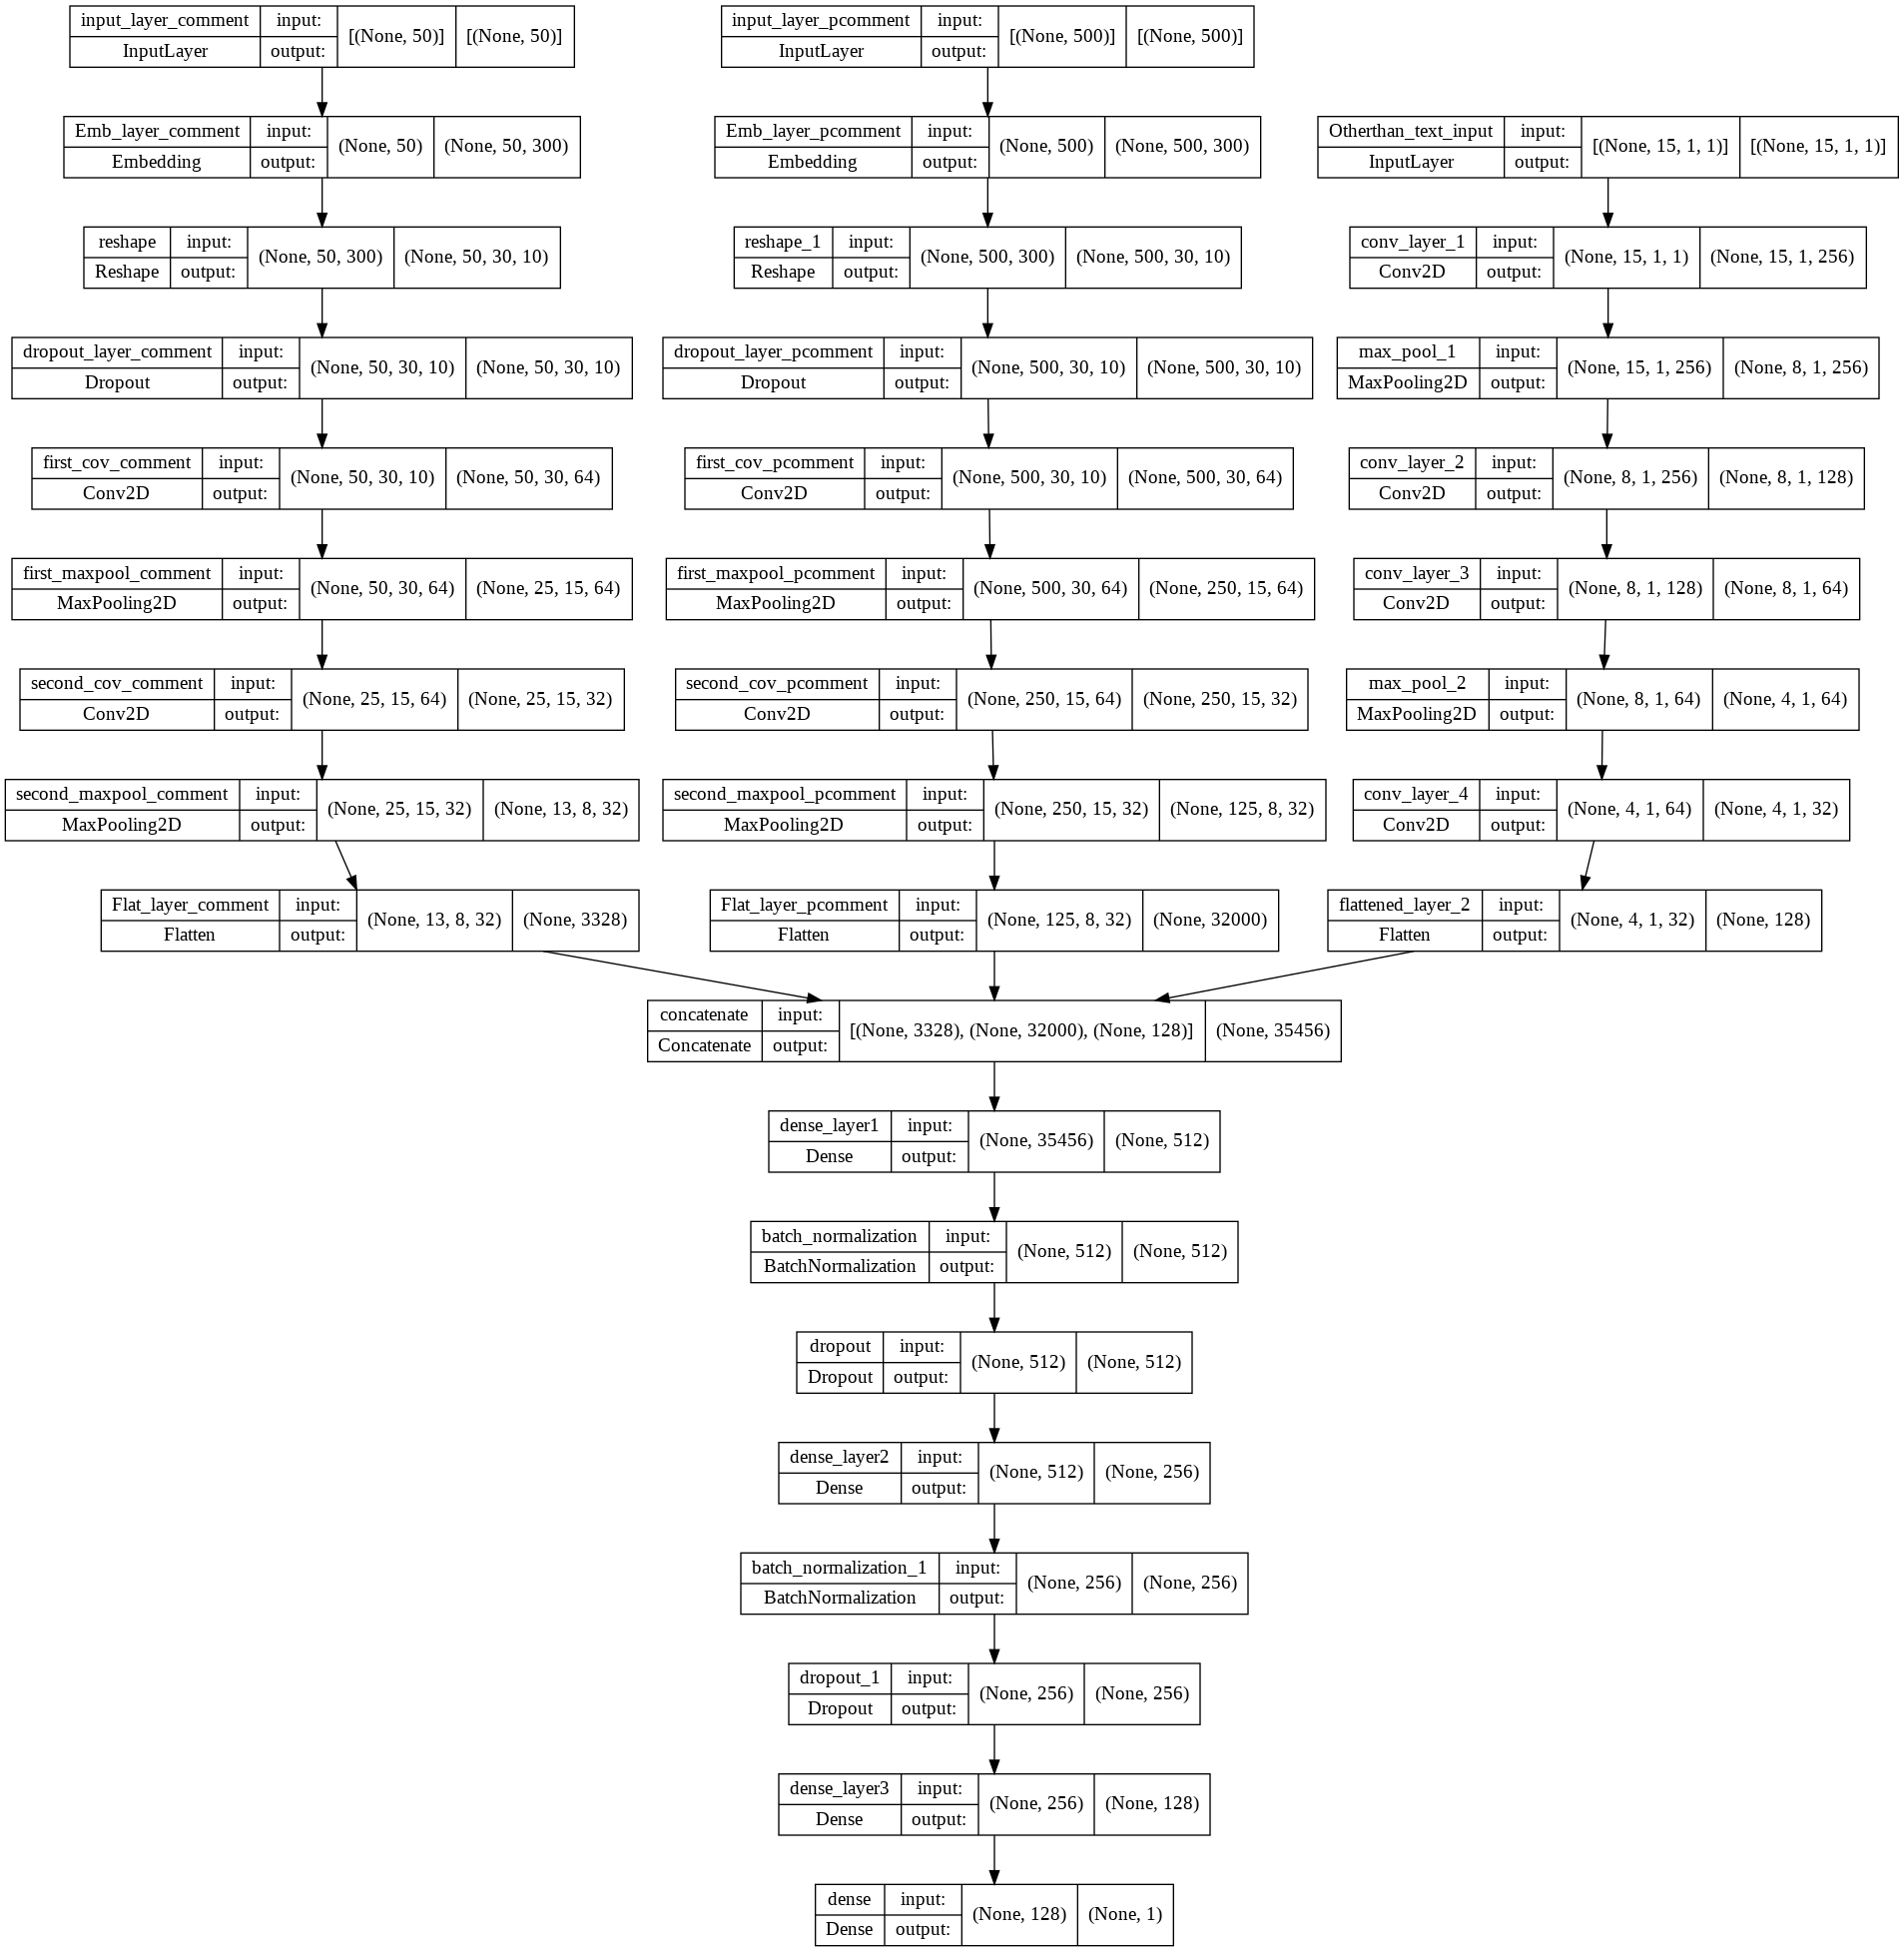

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
history = model.fit([x_train_padding_comment, x_train_padding_pcomment, train_data], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, cv_data], y_cv), 
           batch_size=150, epochs=50, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/50
4029/4029 [==============================] - 777s 189ms/step - loss: 2.0871 - accuracy: 0.6153 - val_loss: 0.6533 - val_accuracy: 0.6818 - lr: 1.0000e-04
Epoch 2/50
4029/4029 [==============================] - 765s 190ms/step - loss: 0.6150 - accuracy: 0.6850 - val_loss: 0.5907 - val_accuracy: 0.6990 - lr: 1.0000e-04
Epoch 3/50
4029/4029 [==============================] - 767s 190ms/step - loss: 0.5855 - accuracy: 0.7032 - val_loss: 0.5862 - val_accuracy: 0.7008 - lr: 1.0000e-04
Epoch 4/50
4029/4029 [==============================] - 732s 182ms/step - loss: 0.5705 - accuracy: 0.7159 - val_loss: 0.5829 - val_accuracy: 0.7037 - lr: 1.0000e-04
Epoch 5/50
4029/4029 [==============================] - 733s 182ms/step - loss: 0.5573 - accuracy: 0.7260 - val_loss: 0.5720 - val_accuracy: 0.7118 - lr: 1.0000e-04
Epoch 6/50
4029/4029 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.7358
Epoch 6: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
4

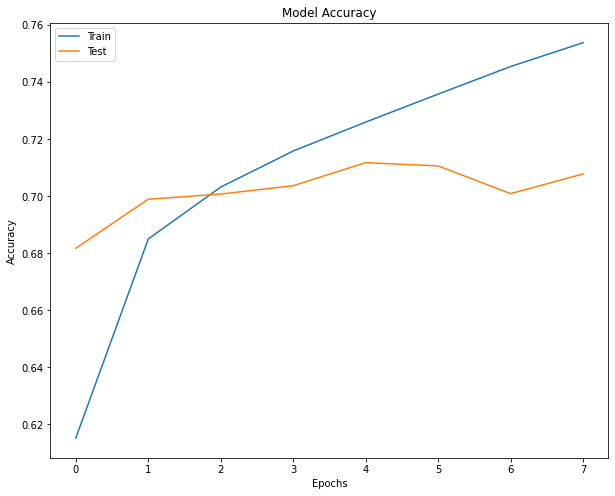

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

# Table of all model scores

In [ ]:
model_list = ["CNN1D 1 layer on text features and Dense 5 layers on numerical features", "CNN1D 1 layer on text features and Dense 5 layers on numerical features", 
                                "CNN1D 1 layer on text features and Dense 5 layers on numerical features", "CNN1D 1 layer on text features and Dense 5 layers on numerical features",
                                "LSTM 1 layer on text features and Dense 5 layers on numerical features", "LSTM 1 layer on text features and Dense 5 layers on numerical features", 
                                "LSTM 1 layer on text features and Dense 5 layers on numerical features", "LSTM 1 layer on text features and Dense 5 layers on numerical features",
                                "LSTM 1 layer on text features and Dense 8 layers on numerical features", "LSTM 2 parallel layers on text features and Dense 5 layers on numerical features",
                                "LSTM 2 parallel layers on text features followed by 2 dense layers and Dense 5 layers on numerical features", 
                                "LSTM 2 layers on text features and Dense 5 layers on numerical features", "CNN1D 2 layers on text features and Dense 5 layers on numerical features",
                                "LSTM 2 parallel layers on text features and Dense 6 layers on numerical features", "CNN1D 2 parallel layers on text features and Dense 5 layers on numerical features",
                                "CNN1D 2 layers on text features and Dense 4 layers on numerical features", "CNN1D 2 layers on text features and Dense 8 layers on numerical features",
                                "Bi-LSTM 1 layers on text features and Dense 5 layers on numerical features", "Bi-LSTM 2 layers on text features and Dense 5 layers on numerical features",
                                "LSTM on text features and CNN1D on numerical features", "CNN1D on text features and CNN1D on numerical features", "CNN2D on text features and CNN2D on numerical features"]
len(model_list)

22

In [ ]:
embedding = ["Glove", "Glove", "FastText", "FastText", "Glove", "Glove", "FastText", "FastText", "FastText", "FastText", "FastText", "FastText", "FastText", "FastText", "FastText", 
             "FastText", "FastText", "FastText", "FastText", "FastText", "FastText", "FastText"]
len(embedding)

22

In [ ]:
trainable = ["False", "True", "False", "True", "False", "True", "False", "True", "True", "True", "True", "True", "True", "True", "True", 
             "True", "True", "True", "True", "True", "True", "True"]
len(trainable)

22

In [ ]:
train_loss = ["0.4834", "0.4705", "0.3883", "0.4499", "0.5053", "0.5263", "0.5164", "0.5188", "0.8426", "0.5917", "0.6161", "0.5328", "0.4678", "0.5252", "0.5246", 
             "0.5362", "0.5375", "0.5832", "0.6410", "0.5786", "0.5054", "0.5573"]
len(train_loss)

22

In [ ]:
train_acc = ["76.21", "77.31", "76.83", "78.60", "77.08", "77.13", "76.73", "78.39", "74.04", "75.44", "75.58", "76.23", "78.36", "77.11", "77.52", 
             "74.95", "77.36", "76.64", "74.26", "71.81", "75.97", "72.60"]
len(train_acc)

22

In [ ]:
test_loss = ["0.7049", "0.7046", "0.8138", "0.7137", "0.7350", "0.7281", "0.7469", "0.7479", "0.9770", "0.7227", "0.7603", "0.6692", "0.6755", "0.6999", "0.7422", 
             "0.6710", "0.7685", "0.7538", "0.7718", "0.5790", "0.5617", "0.5720"]
len(test_loss)

22

In [ ]:
test_acc = ["63.73", "64.99", "64.13", "65.15", "65.55", "66.20", "65.77", "66.83", "65.76", "66.64", "66.20", "66.81", "67.25", "66.36", "66.63", 
             "66.79", "66.71", "66.76", "65.82", "71.59", "72.18", "71.18"]
len(test_acc)

22

In [ ]:
from prettytable import PrettyTable
  
columns = ["S. No", "Models", "Embedding", "Trainable", "Train Loss", "Train Accuracy", "Test Loss", "Test Accuracy"]
  
myTable = PrettyTable()
  
# Add Columns
myTable.add_column(columns[0], list(range(1,23)))
myTable.add_column(columns[1], model_list)
myTable.add_column(columns[2], embedding)
myTable.add_column(columns[3], trainable)
myTable.add_column(columns[4], train_loss)
myTable.add_column(columns[5], train_acc)
myTable.add_column(columns[6], test_loss)
myTable.add_column(columns[7], test_acc)

  
print(myTable)

+-------+-------------------------------------------------------------------------------------------------------------+-----------+-----------+------------+----------------+-----------+---------------+
| S. No |                                                    Models                                                   | Embedding | Trainable | Train Loss | Train Accuracy | Test Loss | Test Accuracy |
+-------+-------------------------------------------------------------------------------------------------------------+-----------+-----------+------------+----------------+-----------+---------------+
|   1   |                   CNN1D 1 layer on text features and Dense 5 layers on numerical features                   |   Glove   |   False   |   0.4834   |     76.21      |   0.7049  |     63.73     |
|   2   |                   CNN1D 1 layer on text features and Dense 5 layers on numerical features                   |   Glove   |    True   |   0.4705   |     77.31      |   0.7046  |     64

## Best model is CNN1D on text features and CNN1D on numerical features. Now, we will tune and then test the model on test data.

In [ ]:
train_data = x_train_num[:,:,np.newaxis]
cv_data = x_cv_num[:,:,np.newaxis]

print(train_data.shape)
print(cv_data.shape)

(604320, 15, 1)
(201440, 15, 1)


In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_layer_comment = Input(shape=(50,), name='input_layer_comment')
embedding_layer_comment = Embedding(len(token_comment.word_index)+1,300,weights=[embedding_matrix_comment_fast],input_length=50,trainable=True, name='Emb_layer_comment')(input_layer_comment)
dropout_layer_comment = Dropout(0.4, name='dropout_layer_comment')(embedding_layer_comment)

first_cov_comment = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_comment', kernel_initializer=glorot_uniform())(dropout_layer_comment)
first_maxpool_comment = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_comment')(first_cov_comment)
second_cov_comment = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_comment', kernel_initializer=glorot_uniform())(first_maxpool_comment)
second_maxpool_comment = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_comment')(second_cov_comment)
flat_layer_comment = Flatten(name='Flat_layer_comment')(second_maxpool_comment)


input_layer_pcomment = Input(shape=(500,), name='input_layer_pcomment')
embedding_layer_pcomment = Embedding(len(token_pcomment.word_index)+1,300,weights=[embedding_matrix_pcomment_fast],input_length=500,trainable=True, name='Emb_layer_pcomment')(input_layer_pcomment)
dropout_layer_pcomment = Dropout(0.4, name='dropout_layer_pcomment')(embedding_layer_pcomment)

first_cov_pcomment = Conv1D(256, 3, activation='relu',padding="same", name='first_cov_pcomment', kernel_initializer=glorot_uniform())(dropout_layer_pcomment)
first_maxpool_pcomment = MaxPooling1D(pool_size=2, padding='same', name='first_maxpool_pcomment')(first_cov_pcomment)
second_cov_pcomment = Conv1D(128, 3, activation='relu',padding="same", name='second_cov_pcomment', kernel_initializer=glorot_uniform())(first_maxpool_pcomment)
second_maxpool_pcomment = MaxPooling1D(pool_size=2, padding='same', name='second_maxpool_pcomment')(second_cov_pcomment)
flat_layer_pcomment = Flatten(name='Flat_layer_pcomment')(second_maxpool_pcomment)


otherthan_text_input = Input(shape=(15,1,), name='Otherthan_text_input')
conv_layer_1 = Conv1D(256, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_1', kernel_regularizer=l2(0.01))(otherthan_text_input)
max_pool_1 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_1')(conv_layer_1)
conv_layer_2 = Conv1D(128, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_2', kernel_regularizer=l2(0.01))(max_pool_1)
conv_layer_3 = Conv1D(64, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_3', kernel_regularizer=l2(0.01))(conv_layer_2)
max_pool_2 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_2')(conv_layer_3)
conv_layer_4 = Conv1D(32, 3, activation='relu',padding="same", kernel_initializer=glorot_uniform(), name='conv_layer_4', kernel_regularizer=l2(0.01))(max_pool_2)

flattened_layer_2 = Flatten(name= 'flattened_layer_2')(conv_layer_4)

merged_layer = Concatenate(axis=-1)([flat_layer_comment,flat_layer_pcomment,flattened_layer_2])

dense_layer1 = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense_layer1', kernel_regularizer=l2(0.01))(merged_layer)
batch_norm_1 = BatchNormalization()(dense_layer1)
drop_layer1 = Dropout(0.6)(batch_norm_1)
dense_layer2 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer2', kernel_regularizer=l2(0.01))(drop_layer1)
batch_norm_2 = BatchNormalization()(dense_layer2)
drop_layer2 = Dropout(0.3)(batch_norm_2)
dense_layer3 = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense_layer3', kernel_regularizer=l2(0.01))(drop_layer2)


output_layer = Dense(1, activation='sigmoid')(dense_layer3)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 1, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Model(inputs=[input_layer_comment, input_layer_pcomment, otherthan_text_input], outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_comment (InputLaye  [(None, 50)]        0           []                               
 r)                                                                                               
                                                                                                  
 input_layer_pcomment (InputLay  [(None, 500)]       0           []                               
 er)                                                                                              
                                                                                                  
 Otherthan_text_input (InputLay  [(None, 15, 1)]     0           []                               
 er)                                                                                          

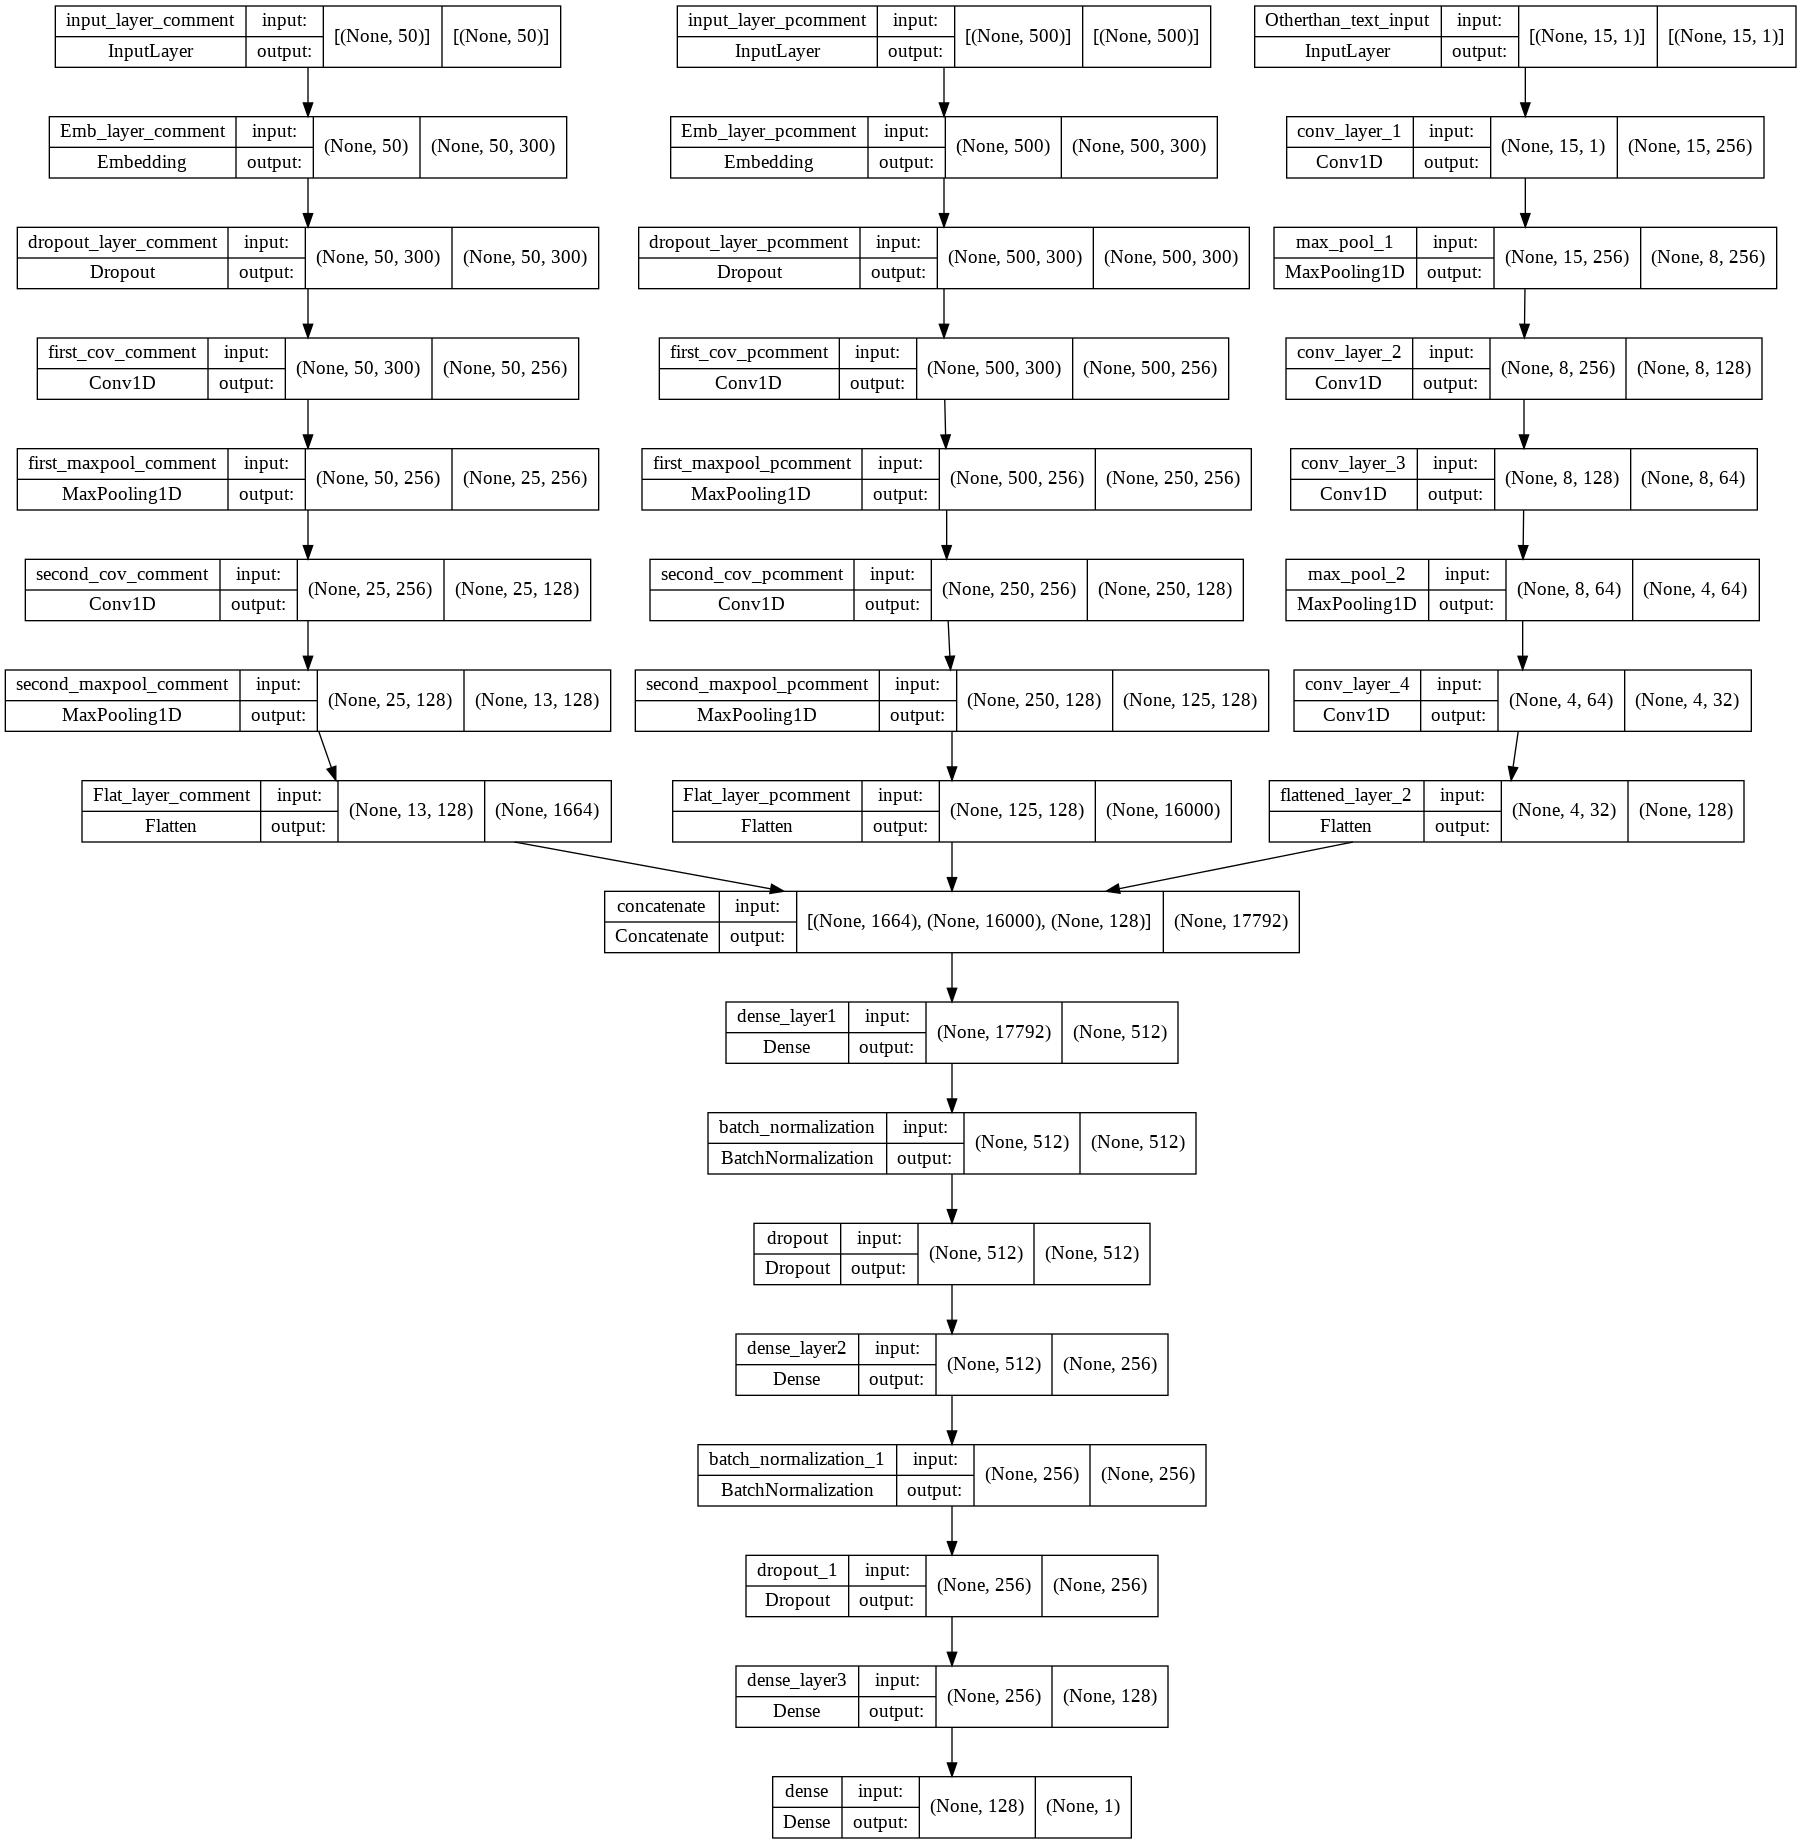

In [ ]:
path = '/content/drive/MyDrive/model.png'
plot_model(model, to_file=path, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
model.fit([x_train_padding_comment, x_train_padding_pcomment, train_data], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, cv_data], y_cv), 
           batch_size=256, epochs=5, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/5
2361/2361 [==============================] - 441s 179ms/step - loss: 3.9875 - accuracy: 0.6293 - val_loss: 0.9074 - val_accuracy: 0.6861 - lr: 1.0000e-04
Epoch 2/5
2361/2361 [==============================] - 412s 175ms/step - loss: 0.6790 - accuracy: 0.6935 - val_loss: 0.5885 - val_accuracy: 0.7020 - lr: 1.0000e-04
Epoch 3/5
2361/2361 [==============================] - 424s 180ms/step - loss: 0.5751 - accuracy: 0.7100 - val_loss: 0.5691 - val_accuracy: 0.7094 - lr: 1.0000e-04
Epoch 4/5
2361/2361 [==============================] - 425s 180ms/step - loss: 0.5578 - accuracy: 0.7216 - val_loss: 0.5593 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 5/5
2361/2361 [==============================] - 424s 180ms/step - loss: 0.5453 - accuracy: 0.7316 - val_loss: 0.5608 - val_accuracy: 0.7206 - lr: 1.0000e-04


In [ ]:
model.fit([x_train_padding_comment, x_train_padding_pcomment, train_data], y_train, 
          validation_data=([x_cv_padding_comment, x_cv_padding_pcomment, cv_data], y_cv), 
           batch_size=256, epochs=3, callbacks=[tensorboard_callback, earlystop, reduce_lr])

Epoch 1/3
2361/2361 [==============================] - 425s 180ms/step - loss: 0.5322 - accuracy: 0.7422 - val_loss: 0.5588 - val_accuracy: 0.7213 - lr: 1.0000e-04
Epoch 2/3
2361/2361 [==============================] - ETA: 0s - loss: 0.5199 - accuracy: 0.7519
Epoch 2: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
2361/2361 [==============================] - 424s 180ms/step - loss: 0.5199 - accuracy: 0.7519 - val_loss: 0.5634 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 3/3
2361/2361 [==============================] - ETA: 0s - loss: 0.5038 - accuracy: 0.7619
Epoch 3: ReduceLROnPlateau reducing learning rate to 6.399999838322402e-05.
2361/2361 [==============================] - 425s 180ms/step - loss: 0.5038 - accuracy: 0.7619 - val_loss: 0.5693 - val_accuracy: 0.7203 - lr: 8.0000e-05


In [ ]:
model.save('/content/drive/MyDrive/final_model.h5')

In [71]:
from tensorflow import keras
model = keras.models.load_model('final_model.h5')

In [72]:
X_test, x_test_padding_pcomment, x_test_padding_comment, y_test = pickle.load(open("complete_preprocessed_test_data.pkl", 'rb'))

In [73]:
test_data = X_test.values

In [74]:
y_hat_prob = model.predict([x_test_padding_comment, x_test_padding_pcomment, test_data])

y_hat_class = []

for i in list(y_hat_prob):
  if i >=0.5:
    y_hat_class.append(1)
  else:
    y_hat_class.append(0)

y_hat_class = np.array(y_hat_class)

accuracy = accuracy_score(y_test, y_hat_class)

print("Test accuracy is: ", accuracy)

6296/6296 [==============================] - 700s 111ms/step
Test accuracy is:  0.7218292204665386


In [ ]:
from prettytable import PrettyTable
  
columns = ["Models", "Embedding", "Trainable", "Train Accuracy", "CV Accuracy", "Test Accuracy"]
  
myTable = PrettyTable()
  
# Add Columns
myTable.add_column(columns[0], ['CNN1D on text features and CNN1D on numerical features'])
myTable.add_column(columns[1], ['FastText'])
myTable.add_column(columns[2], ['True'])
myTable.add_column(columns[3], ['74.22'])
myTable.add_column(columns[4], ['72.13'])
myTable.add_column(columns[5], ['72.18'])

  
print(myTable)

+--------------------------------------------------------+-----------+-----------+----------------+-------------+---------------+
|                         Models                         | Embedding | Trainable | Train Accuracy | CV Accuracy | Test Accuracy |
+--------------------------------------------------------+-----------+-----------+----------------+-------------+---------------+
| CNN1D on text features and CNN1D on numerical features |  FastText |    True   |     74.22      |    72.13    |     72.18     |
+--------------------------------------------------------+-----------+-----------+----------------+-------------+---------------+


# Now, we will do error analysis on this model using LIME.

In [2]:
from tensorflow import keras
model = keras.models.load_model('final_model.h5')

In [43]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer
from sklearn.pipeline import make_pipeline
from lime.lime_base import LimeBase
from lime.lime_text import explanation

In [4]:
def preprocessing_comment(text):
    
    text = [text]
    token_comment, token_pcomment =  pickle.load(open('tokens.pkl','rb'))
    sequence_com = token_comment.texts_to_sequences(text)
    pad_comment = pad_sequences(sequence_com, maxlen=50, padding='post')   
    
    return pad_comment

In [5]:
def preprocessing_pcomment(text):
    
    text = [text]
    token_comment, token_pcomment =  pickle.load(open('tokens.pkl','rb'))
    sequence_com = token_pcomment.texts_to_sequences(text)
    pad_pcomment = pad_sequences(sequence_com, maxlen=500, padding='post')    
    
    return pad_pcomment

In [6]:
def preprocessing_num(data):
    
    cat_author, cat_subreddit = pickle.load(open("cat.pkl", 'rb'))
    data['author'] = cat_author.transform(data['author'])
    data['subreddit'] = cat_subreddit.transform(data['subreddit'])
    
    data = data[['author', 'subreddit', 'score', 'ups', 'downs', 'Neg_comment',
       'Neu_comment', 'Pos_comment', 'Compound_comment', 'Neg_pcomment',
       'Neu_pcomment', 'Pos_pcomment', 'Compound_pcomment', 'comment_len',
       'pcomment_len']]

    num_features = data.values    
    
    return num_features

In [54]:
df = pd.read_csv('cleaned_data.csv')

In [66]:
sample_data = df.sample(1)
sample_data.head()

label       author      subreddit  score  ups  downs  \
487956      0  drinktusker  todayilearned      4    4      0   

          preprocessed_comments             preprocessed_pcomments  \
487956  lack of caow and chikin  were they eating the poor doge is   

        Neg_comment  Neu_comment  Pos_comment  Compound_comment  Neg_pcomment  \
487956        0.365        0.635          0.0           -0.3182         0.341   

        Neu_pcomment  Pos_pcomment  Compound_pcomment  comment_len  \
487956         0.659           0.0            -0.4767            5   

        pcomment_len  
487956             7

In [67]:
model.predict([preprocessing_comment(sample_data['preprocessed_comments'].values[0]), preprocessing_pcomment(sample_data['preprocessed_pcomments'].values[0]), preprocessing_num(sample_data)])

1/1 [==============================] - 0s 25ms/step


array([[0.12670954]], dtype=float32)

In [59]:
# https://github.com/marcotcr/lime/issues/24
# keeping tabular data constant and explaining text data only
def get_classifier_fn(continuous_features):  
    def classifier_fn(text_list):
        ret = []
        for text in text_list: 
            sentence1, sentence2 = text.split('/')
            pred = model.predict([preprocessing_comment(sentence1), preprocessing_pcomment(sentence2), 
                                  preprocessing_num(continuous_features)])
            ret.append(pred[0])
        return np.array(ret)
    return classifier_fn

In [68]:
text = '%s %s %s' % (sample_data.preprocessed_comments.values[0], '/', sample_data.preprocessed_pcomments.values[0])
fn = get_classifier_fn(sample_data)
explainer = LimeTextExplainer(class_names= ['Sarcastic', 'Non-Sarcastic'])
exp = explainer.explain_instance(text, fn, labels=(0,), num_features=15)

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 33ms/step


In [69]:
exp.show_in_notebook(text=text)

#### Observation:
    Words like doge, and, the, caow & chikin are of the reasons for Sarcastic comment prediction. Words like lack, poor & 
    they are one of the reasons for non-sarcastic comment prediction. 

# Epoch vs Accuracy

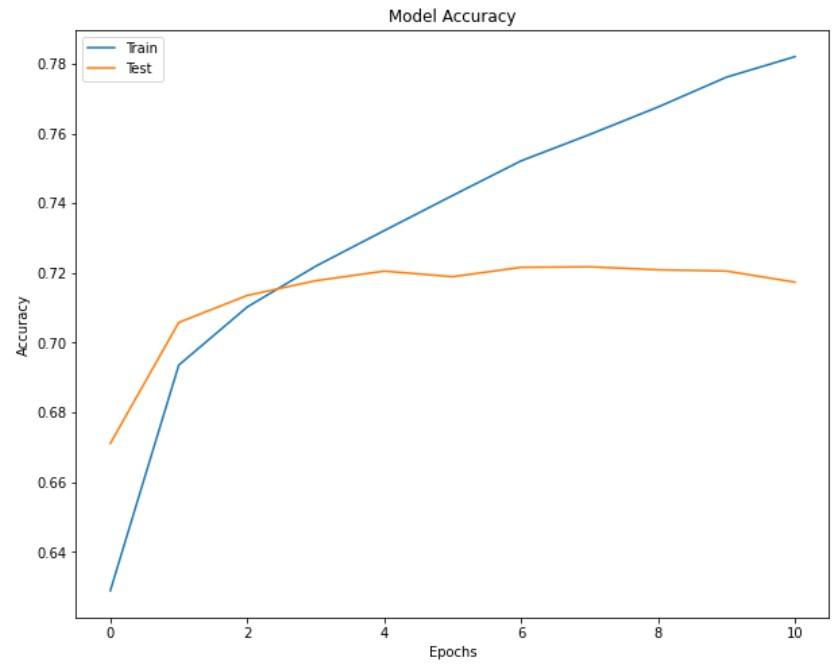

In [98]:
from IPython.display import display, Image
display(Image(filename='final_model_epoch_v_acc.jpg'))

#### Observation:
    We can observe that model is not overfitted or underfitted.

# Confusion Matrix on test dataset

<IPython.core.display.Javascript object>


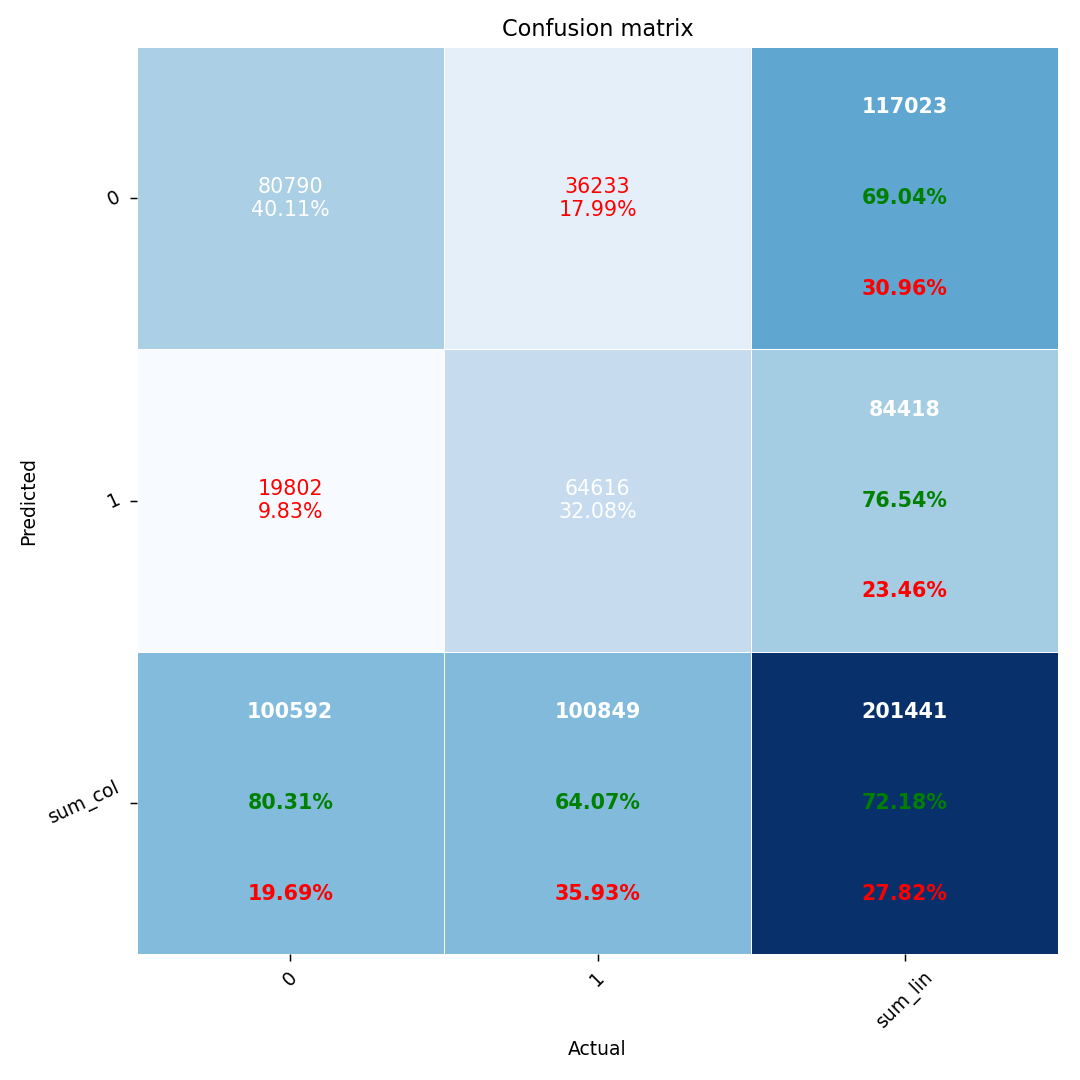

In [86]:
# https://github.com/wcipriano/pretty-print-confusion-matrix
from sklearn.metrics import confusion_matrix
from pretty_confusion_matrix import pp_matrix

con_mat = confusion_matrix(y_test, y_hat_class)
pp_matrix(df_con_mat, cmap='Blues')

#### Observation:
    72.18% of total data points are correctly classified and 27.82% of total data points are incorrectly classified.
    
    True Positive = 32.08% 
    True Negative = 40.11%
    False Positive = 9.83%
    False Negative = 17.99%
    
    False negative is almost double than false positive.